In [1]:
# from mobster_mv2 import mobster_MV
from model_no_probs import mobster_MV
import numpy as np
import pandas as pd
import pyro.distributions as dist

import torch
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics.cluster import normalized_mutual_info_score

from plot_functions import *
from BoundedPareto import BoundedPareto
from create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_paretos_1(mb):
    alpha_pareto = mb.params["alpha_pareto_param"].detach().numpy()
    fig, ax = plt.subplots(nrows=alpha_pareto.shape[0], ncols=alpha_pareto.shape[1])
    fig.tight_layout()
    x = np.arange(0,0.5,0.001)
    k = 0
    for d in range(alpha_pareto.shape[1]):
        pdf = pareto.pdf(x, alpha_pareto[k,d], scale=0.01)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d} - alpha {round(float(alpha_pareto[k,d]), ndigits=2)}")

def plot_betas_1(mb):
    phi_beta = mb.params["phi_beta_param"].detach().numpy()
    kappa_beta = mb.params["k_beta_param"].detach().numpy()

    fig, ax = plt.subplots(nrows=phi_beta.shape[0], ncols=phi_beta.shape[1])
    fig.tight_layout()
    x = np.arange(0,1,0.001)
    k = 0
    for d in range(phi_beta.shape[1]):
        a = phi_beta[k,d]*kappa_beta[k,d]
        b = (1-phi_beta[k,d])*kappa_beta[k,d]
        pdf = beta.pdf(x, a, b)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d}")

In [3]:
def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

def beta_lk(data, DP, a_beta, b_beta, weights):
    # return torch.log(weights) + dist.Beta(a_beta, b_beta).log_prob(probs_beta) + dist.Binomial(total_count=DP, probs = probs_beta).log_prob(data) # simply does log(weights) + log(density)
    return torch.log(weights) + dist.BetaBinomial(a_beta, b_beta, total_count=DP).log_prob(data) # simply does log(weights) + log(density)


# def pareto_lk(data, DP, alpha, weights):
#     # return torch.log(weights) + BoundedPareto(0.01, alpha, 0.55).log_prob(probs_pareto) + dist.Binomial(total_count=DP, probs = probs_pareto).log_prob(data) # simply does log(weights) + log(density)
#     probs = BoundedPareto(0.01, alpha, 0.55).sample()
#     return torch.log(weights) + dist.Binomial(total_count=DP, probs = probs).log_prob(data) # simply does log(weights) + log(density)
def pareto_lk(data, DP, alpha, weights):
    LINSPACE = 2000
    x = torch.linspace(0.01, 0.999, LINSPACE)
    y_1 = BoundedPareto(0.01, alpha, 0.55).log_prob(x).exp()
    y_2 = dist.Binomial(probs = x.repeat([data.shape[0],1]).reshape([LINSPACE,-1]), total_count=DP).log_prob(data).exp()
    pareto = torch.log(weights) + torch.trapz(y_1.reshape([LINSPACE, 1]) * y_2, x =  x, dim = 0).log()
    return pareto

def compute_likelihood(mb, beta = True, dim = 0, k = 0):
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    weights = mb.params["weights_param"][k]
    if beta == True:
        phi_beta = mb.params["phi_beta_param"][k, dim]
        k_beta = mb.params["k_beta_param"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        return log_sum_exp(beta_lk(NV, DP, a_beta, b_beta, weights)).sum()
    else:
        alpha = mb.params["alpha_pareto_param"][k, dim]
        return log_sum_exp(pareto_lk(NV, DP, alpha, weights)).sum()

### One beta component

Trying to understand if the problem is the $\delta$ or the parameter convergence:
- if one dim of the cluster is assigned to the pareto but the likelihood of beta is higher, then the $\delta$ is wrong
- if one dim of the cluster is assigned to the pareto and the likelihood of pareto is higher, then the parameter convergence is wrong

In [4]:
N1 = 1000
seed = 123
# Component 1
phi_beta_x = 0.1
k_beta_x = 250
phi_beta_y = 0.1
k_beta_y= 250
n1=150
NV, DP = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n1, N=N1, seed=seed)
# 
print(DP.shape)

torch.Size([1000, 2])


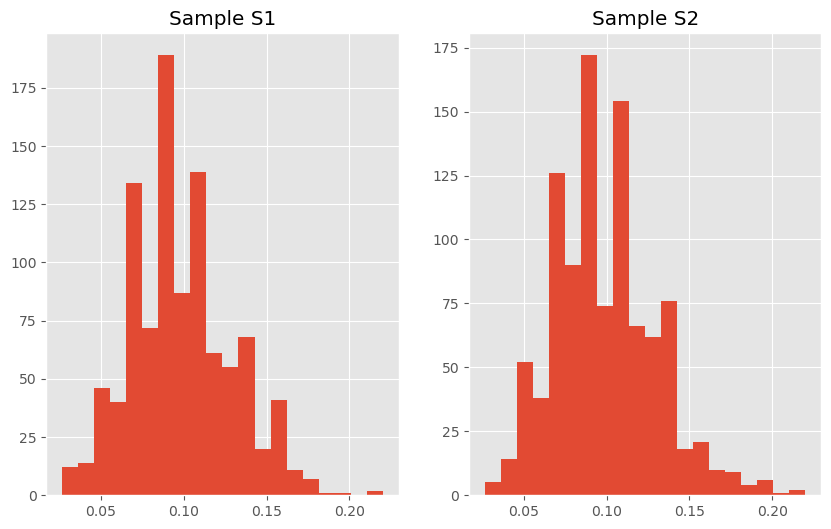

In [5]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [6]:
labels = np.zeros(N1)

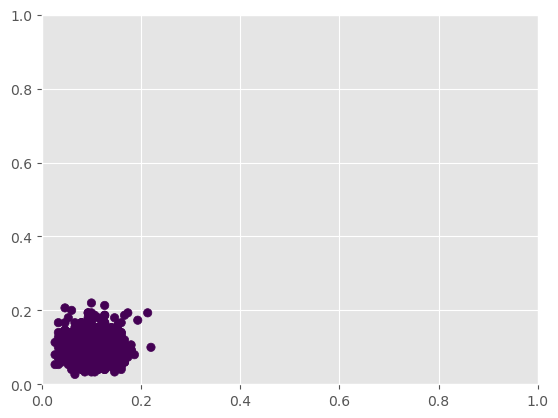

In [7]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0986, 0.0994]])
Iteration 0: Loss = 13595.388671875
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0201, 2.0201]], grad_fn=<AddBackward0>)
alpha_pareto_param tensor([[1.9801, 1.9801]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0979, 0.0986]], grad_fn=<AddBackward0>)
k_beta_param tensor([[100.6294, 100.7775]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3553, 0.6447],
         [0.3279, 0.6721]]], grad_fn=<DivBackward0>)


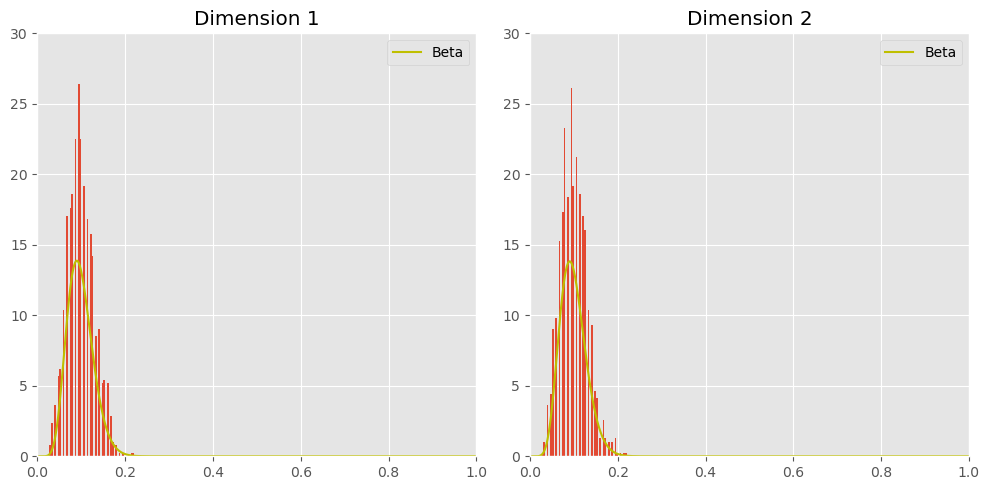

Iteration 200: Loss = -908.1563110351562
Iteration 400: Loss = -1028.996826171875
phi_beta [[0.09601206 0.09664458]]
delta [[[0.04970584 0.9502942 ]
  [0.04456276 0.95543724]]]


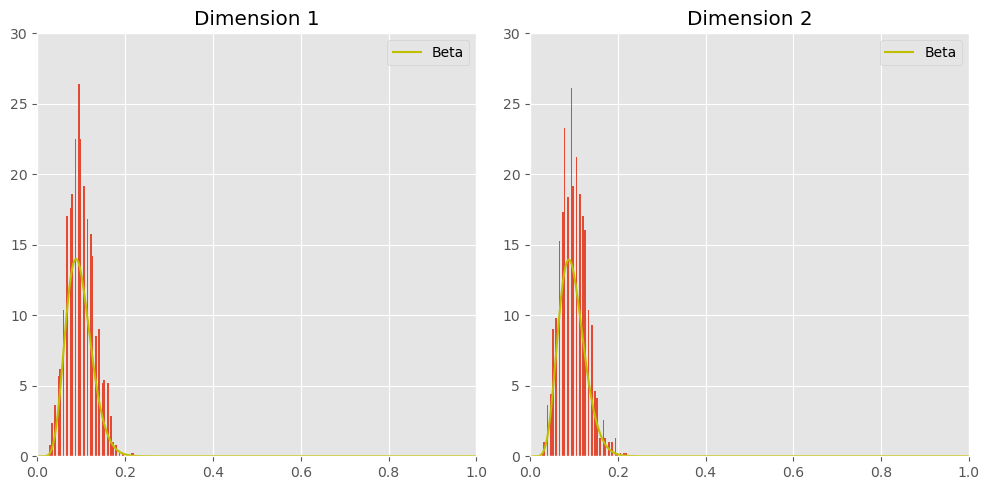

Iteration 600: Loss = -1072.1015625
Iteration 800: Loss = -1091.58984375
phi_beta [[0.09601298 0.09664945]]
delta [[[0.01895546 0.9810446 ]
  [0.01697078 0.9830292 ]]]


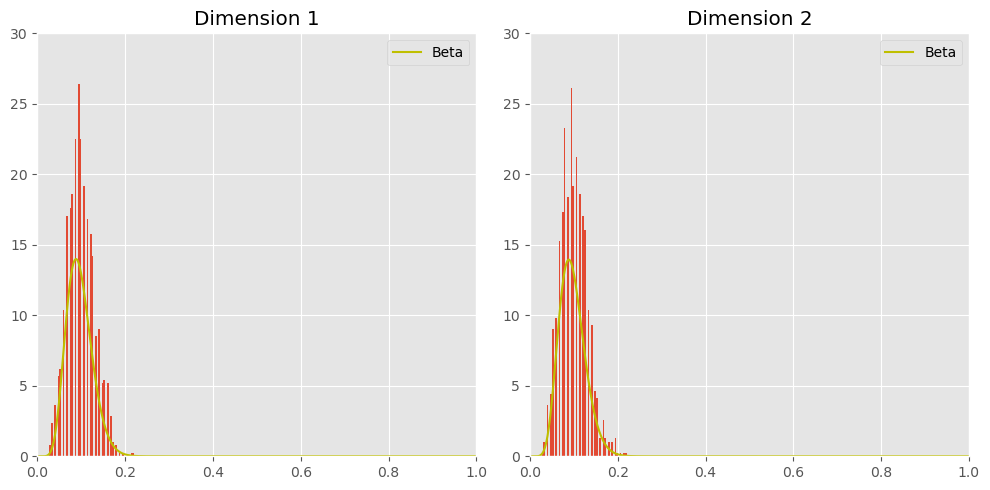

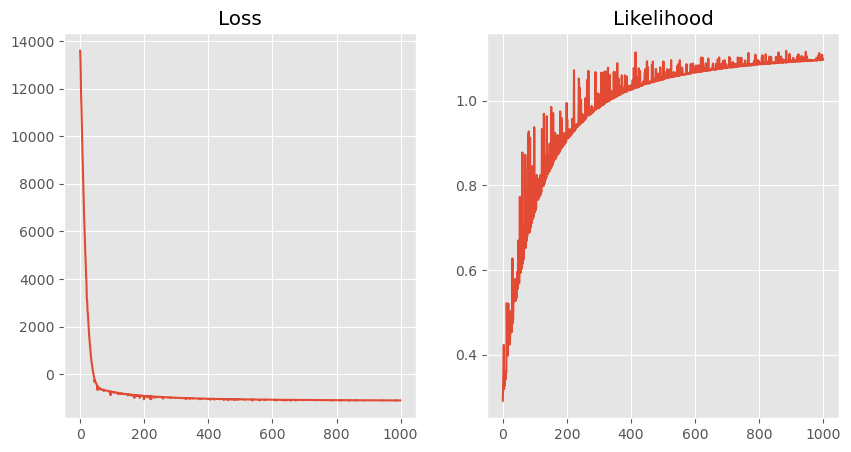

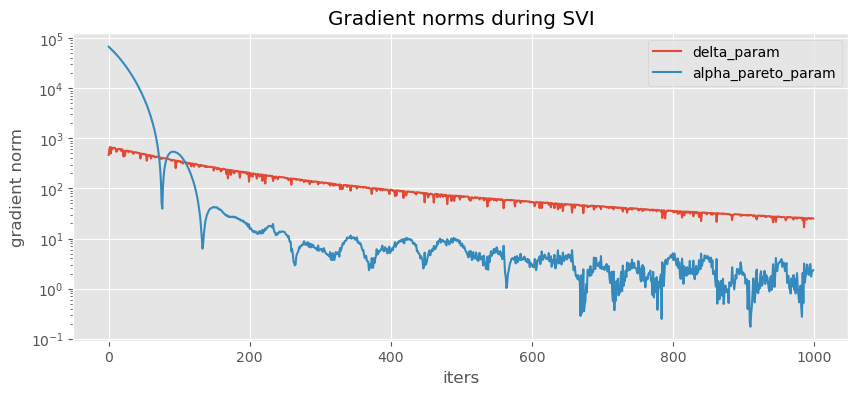

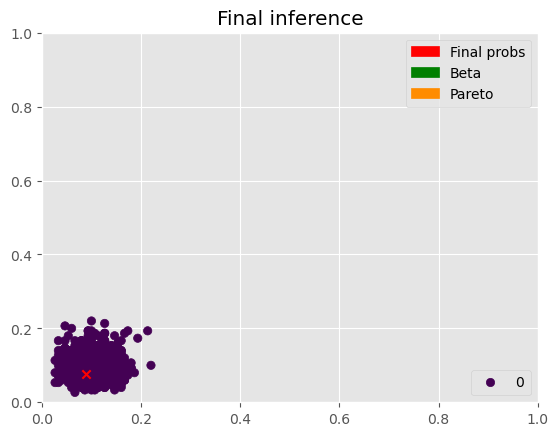

In [8]:
mb = mobster_MV(NV, DP, K = 1, seed = 53)
mb.fit(num_iter = 1000, lr = 0.005)

In [9]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(mb, beta = False, dim = 1, k = 0))

tensor(4.0109, grad_fn=<SumBackward0>)
tensor(1.9795, grad_fn=<SumBackward0>)
tensor(4.0139, grad_fn=<SumBackward0>)
tensor(1.8912, grad_fn=<SumBackward0>)


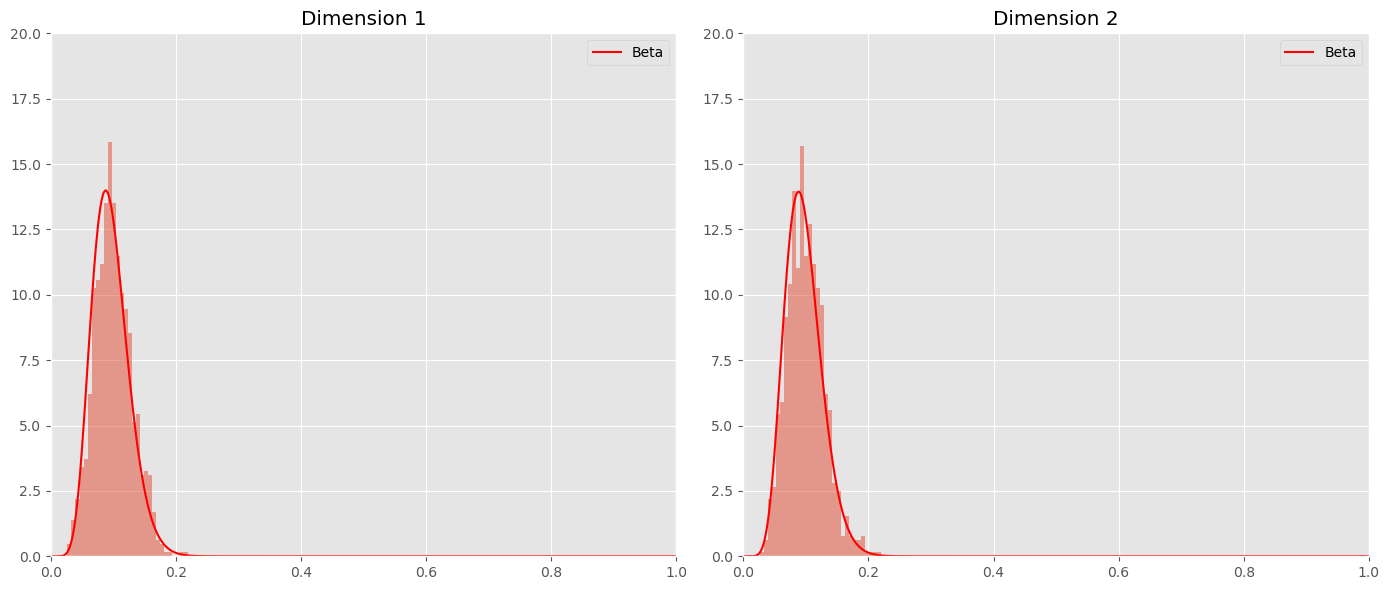

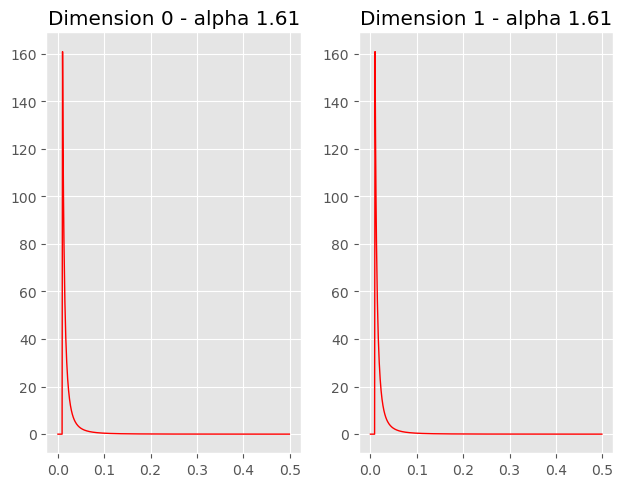

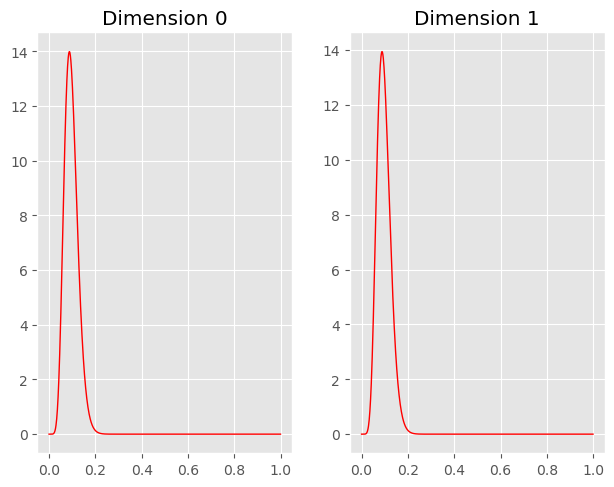

In [10]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [11]:
mb.params

{'weights_param': tensor([1.], grad_fn=<DivBackward0>),
 'alpha_prior_param': tensor([[2.4979, 2.4979]], grad_fn=<AddBackward0>),
 'alpha_pareto_param': tensor([[1.6086, 1.6086]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.0960, 0.0966]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[100.4407, 100.4508]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.0134, 0.9866],
          [0.0120, 0.9880]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
          0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
          0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
          0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
          0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
          0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
          0.0025, 0.0025, 0.0025, 0.0025, 0.0025

### One pareto-pareto component

In [12]:
N1 = 1000
seed = 123

n1=100
NV, DP = only_pareto_binomial_component(alpha_x=2, L_x=0.01, H_x=0.5, alpha_y=2, L_y=0.01, H_y=0.5, n=n1, N=N1, seed = 123)

print(DP.shape)

torch.Size([1000, 2])


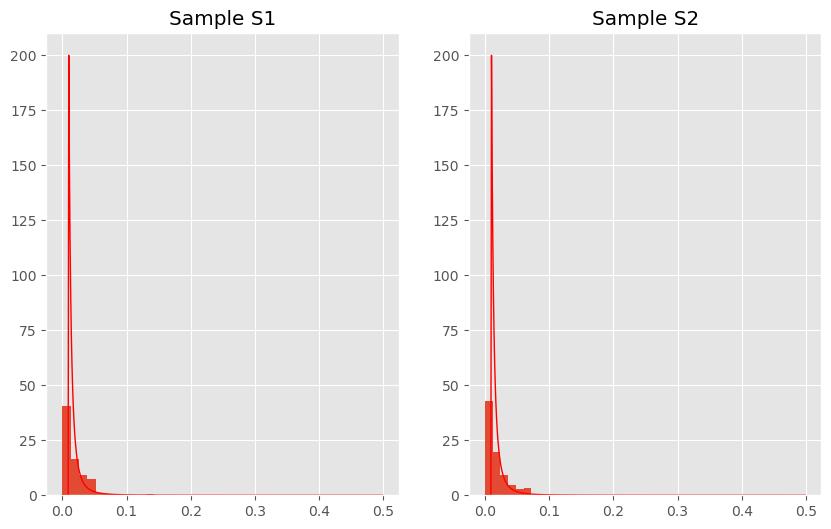

In [14]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), density = True, bins = 20)
axes[0].set_title("Sample S1")

x = np.arange(0, 0.5, 0.001)
pdf = pareto.pdf(x, 2.0, scale=0.01)
axes[0].plot(x, pdf, 'r-', lw=1)

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), density = True, bins = 20)
axes[1].set_title("Sample S2")
axes[1].plot(x, pdf, 'r-', lw=1)
plt.show()

In [15]:
labels = np.zeros(N1)

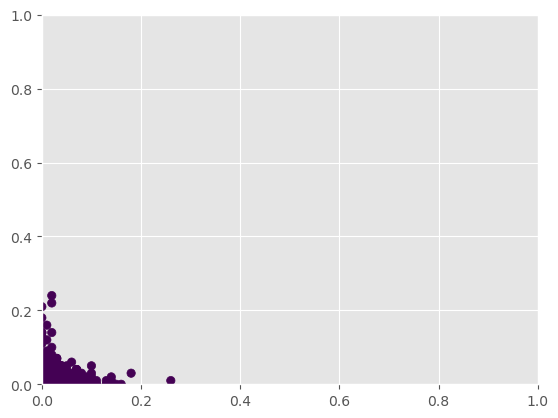

In [16]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0191, 0.0195]])
Iteration 0: Loss = 11577.724609375
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0040, 2.0040]], grad_fn=<AddBackward0>)
alpha_pareto_param tensor([[1.9960, 1.9960]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0190, 0.0194]], grad_fn=<AddBackward0>)
k_beta_param tensor([[100.0802, 100.0926]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3592, 0.6408],
         [0.3317, 0.6683]]], grad_fn=<DivBackward0>)


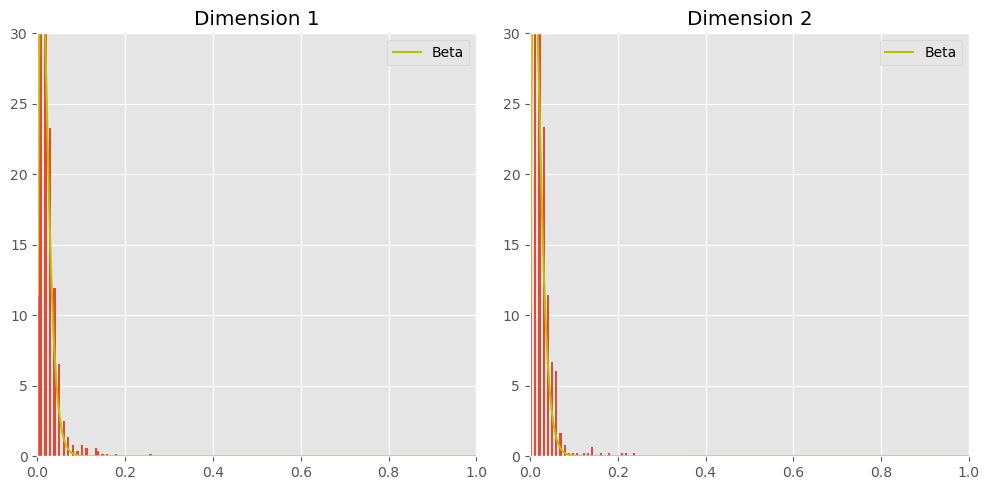

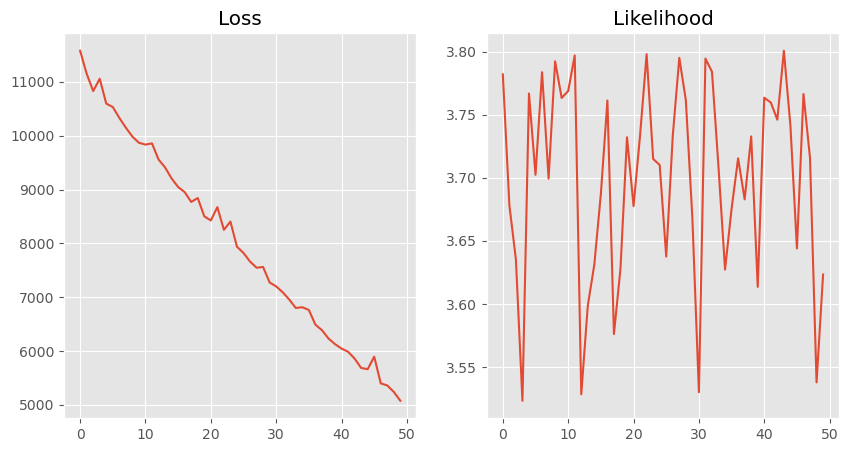

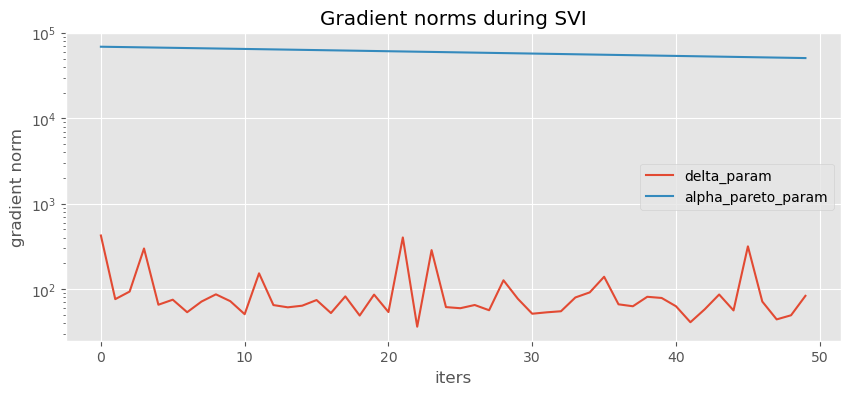

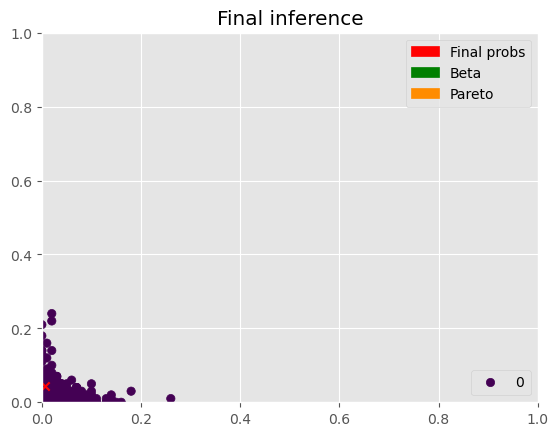

In [17]:
mb = mobster_MV(NV, DP, K = 1, seed = 53)
mb.fit(num_iter = 3000, lr = 0.001)

In [18]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(mb, beta = False, dim = 1, k = 0))

tensor(5.3006, grad_fn=<SumBackward0>)
tensor(2.0481, grad_fn=<SumBackward0>)
tensor(5.2875, grad_fn=<SumBackward0>)
tensor(2.0386, grad_fn=<SumBackward0>)


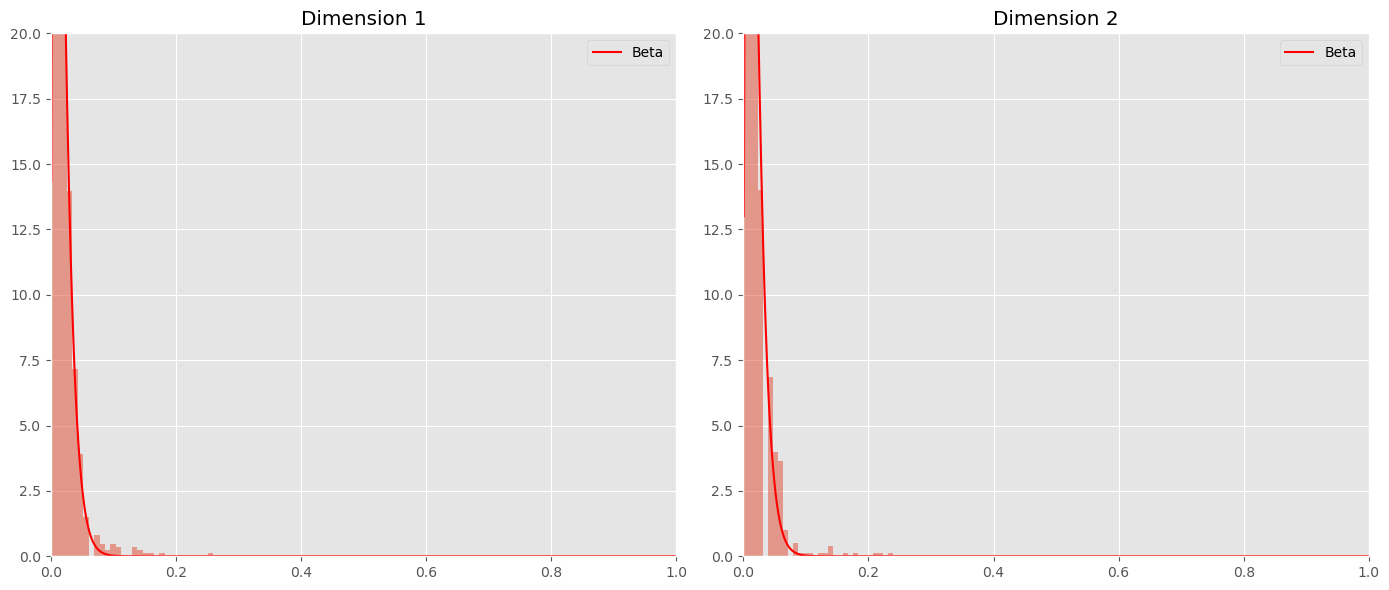

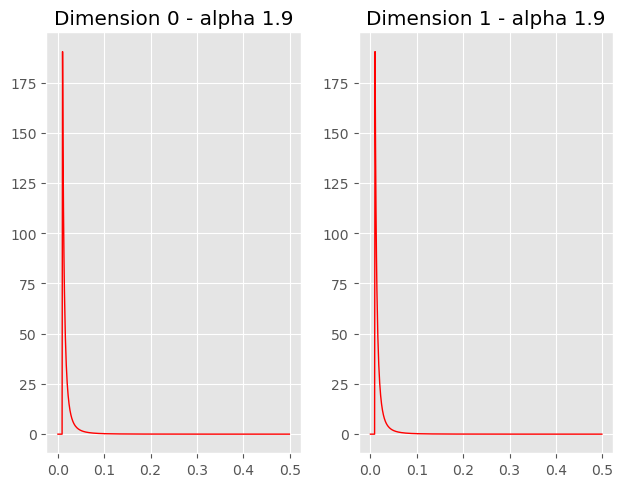

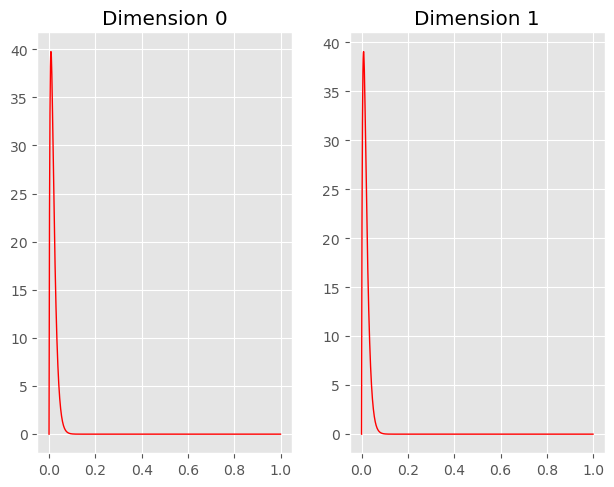

In [19]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [20]:
mb.params

{'weights_param': tensor([1.], grad_fn=<DivBackward0>),
 'alpha_prior_param': tensor([[2.1011, 2.1011]], grad_fn=<AddBackward0>),
 'alpha_pareto_param': tensor([[1.9044, 1.9044]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.0182, 0.0185]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[100.0361, 100.0493]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.3627, 0.6373],
          [0.3317, 0.6683]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003

### One beta-pareto component

In [21]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.1
k_beta = 200
n1 = 100
NV, DP = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

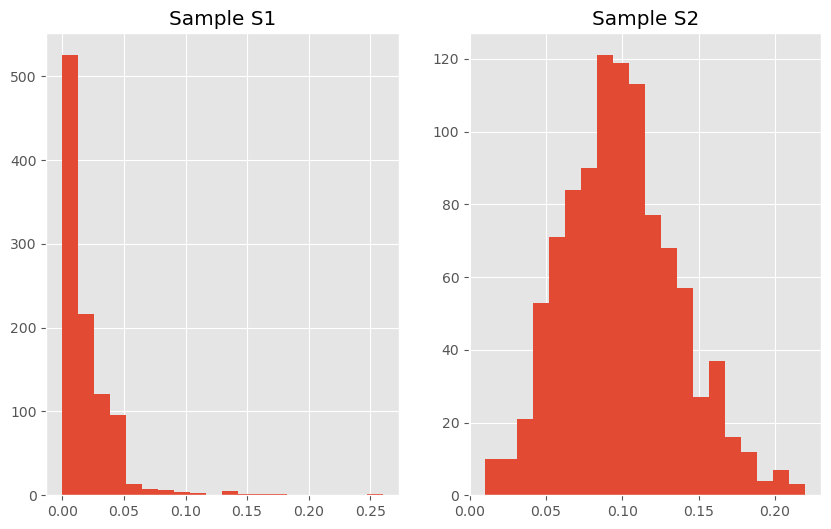

In [22]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [23]:
labels = np.zeros(N1)

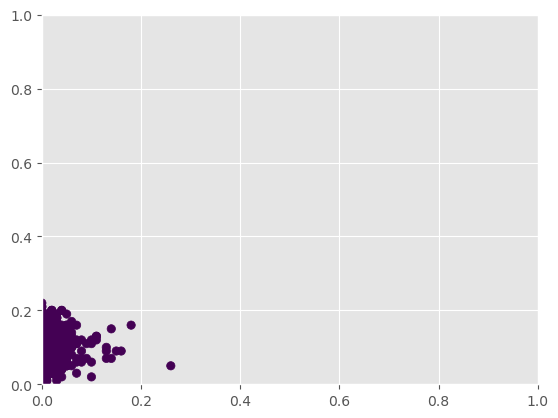

In [24]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0191, 0.1002]])
Iteration 0: Loss = 11690.4990234375
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0201, 2.0201]], grad_fn=<AddBackward0>)
alpha_pareto_param tensor([[1.9801, 1.9801]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0189, 0.0994]], grad_fn=<AddBackward0>)
k_beta_param tensor([[100.1724, 100.6442]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.0473, 0.9527],
         [0.0490, 0.9510]]], grad_fn=<DivBackward0>)


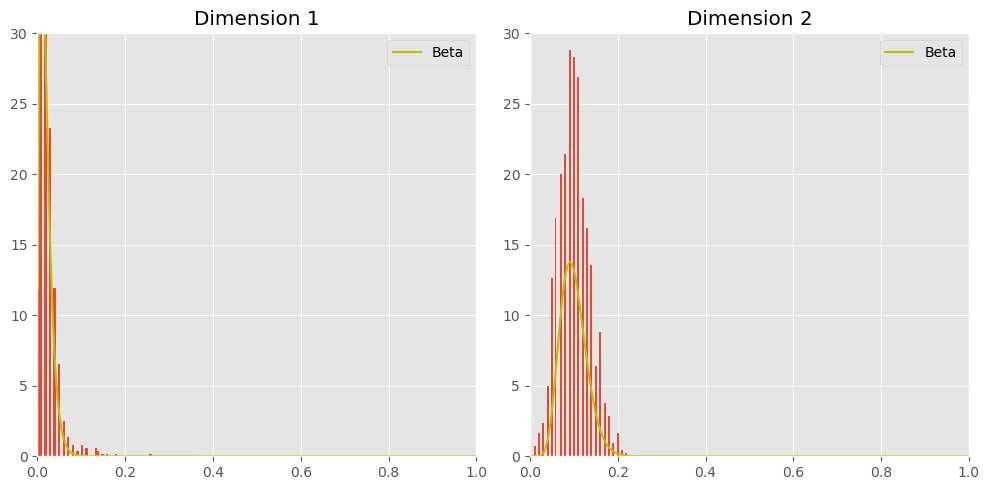

Iteration 200: Loss = -2809.60302734375
Iteration 400: Loss = -2813.76318359375
phi_beta [[0.00690094 0.09498084]]
delta [[[0.03149866 0.96850127]
  [0.00570739 0.9942926 ]]]


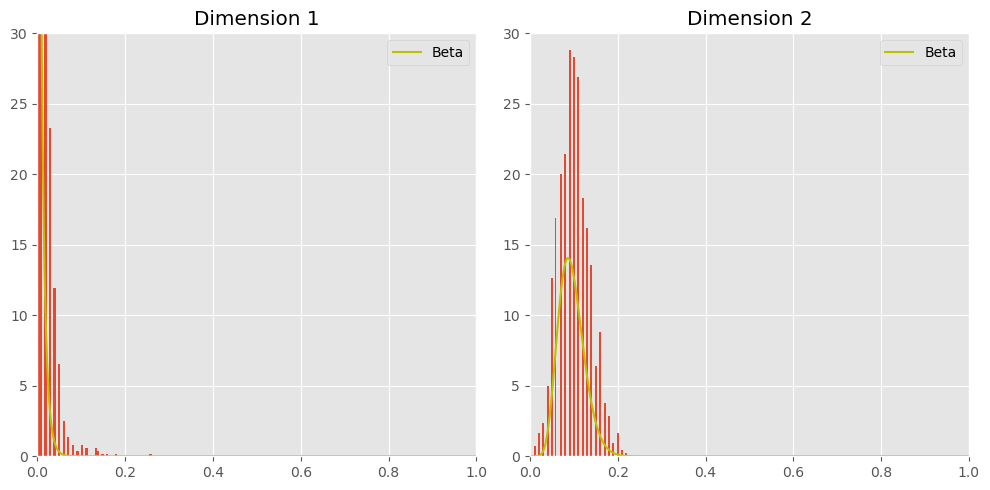

Iteration 600: Loss = -2834.798095703125
Iteration 800: Loss = -2836.76953125
phi_beta [[0.00532682 0.09490581]]
delta [[[0.01533506 0.984665  ]
  [0.00219691 0.99780303]]]


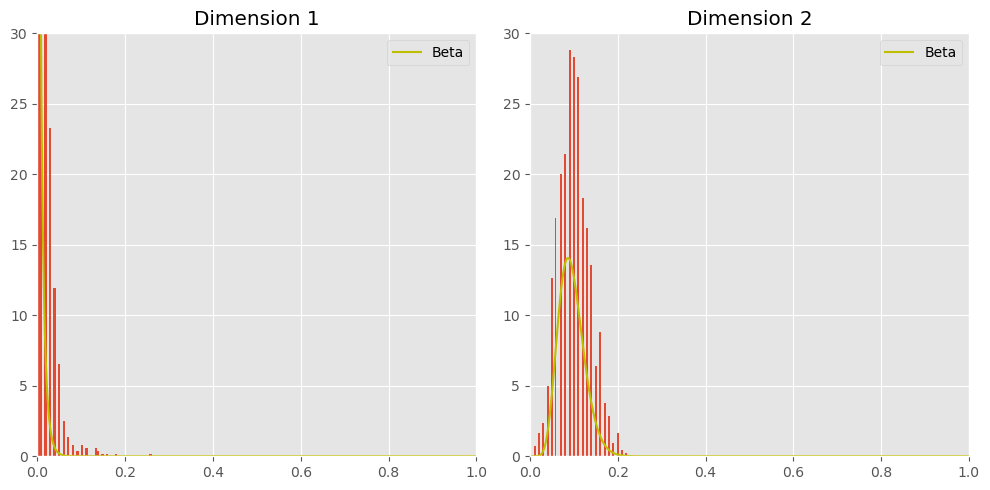

Iteration 1000: Loss = -2837.599853515625
Iteration 1200: Loss = -2837.435791015625
phi_beta [[0.00496015 0.09487928]]
delta [[[0.00848231 0.9915177 ]
  [0.00118728 0.9988128 ]]]


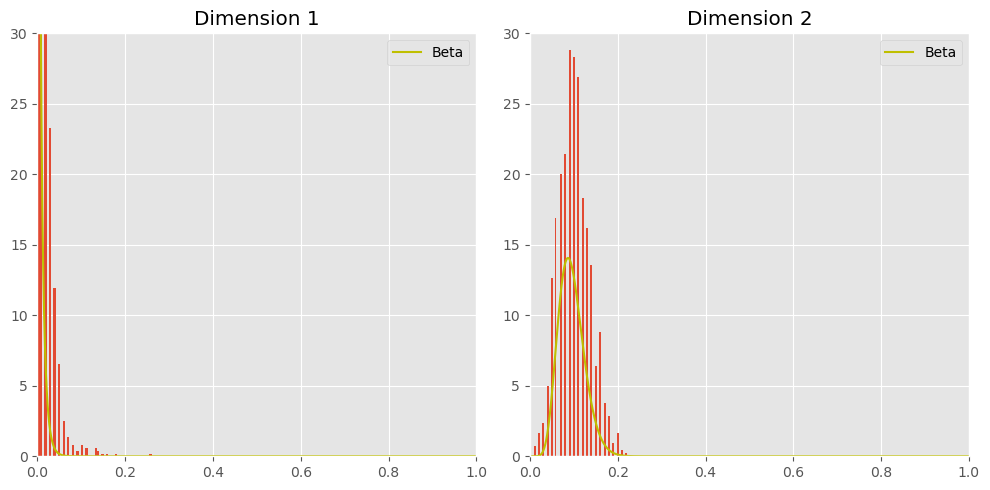

Iteration 1400: Loss = -2838.057861328125
Iteration 1600: Loss = -2838.49560546875
phi_beta [[0.00488908 0.09487689]]
delta [[[5.7381038e-03 9.9426198e-01]
  [7.3164213e-04 9.9926835e-01]]]


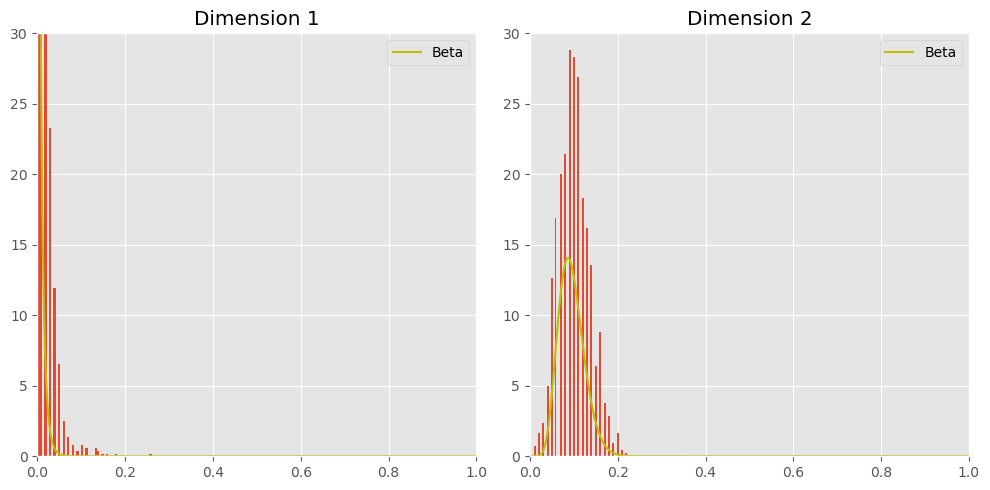

Iteration 1800: Loss = -2838.417724609375
Iteration 2000: Loss = -2838.778564453125
phi_beta [[0.00488008 0.09487361]]
delta [[[3.9578634e-03 9.9604213e-01]
  [4.8997061e-04 9.9951005e-01]]]


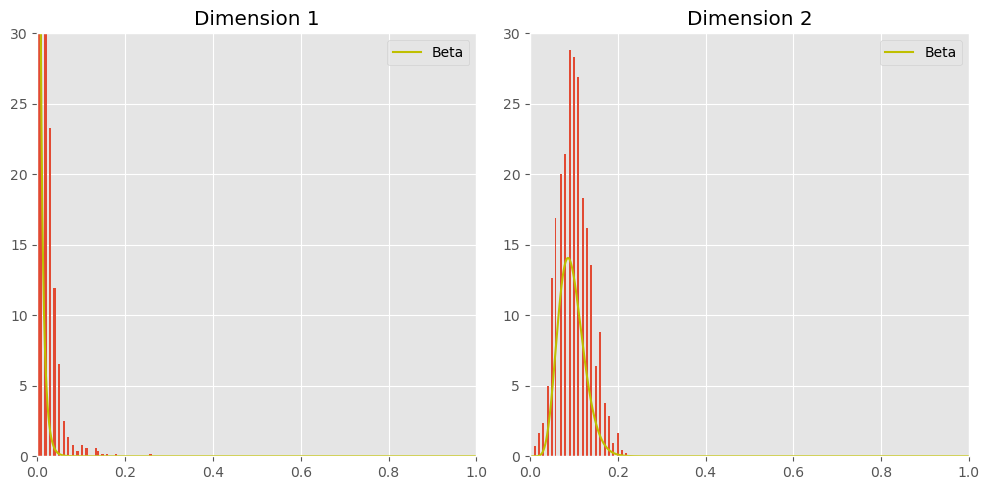

Iteration 2200: Loss = -2838.689697265625
Iteration 2400: Loss = -2838.800537109375
phi_beta [[0.00487926 0.09487516]]
delta [[[3.0898829e-03 9.9691015e-01]
  [3.4762773e-04 9.9965239e-01]]]


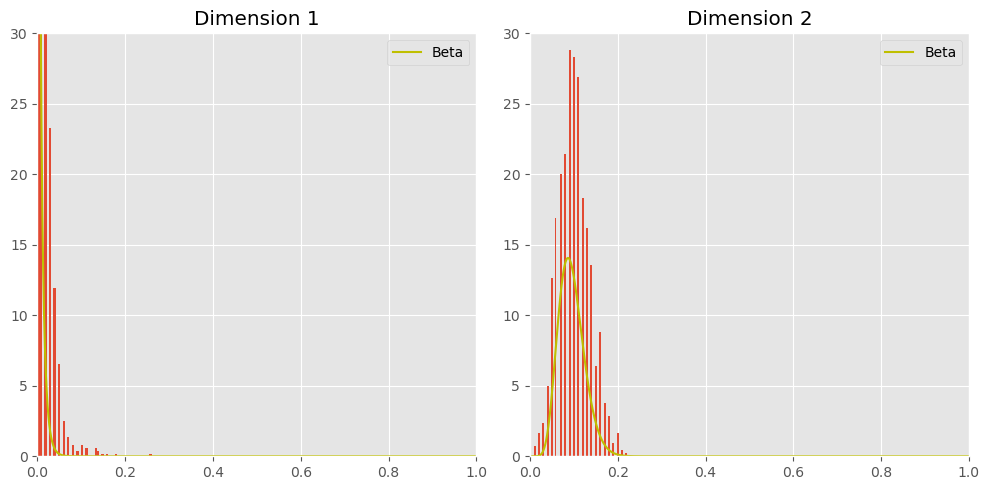

Iteration 2600: Loss = -2838.744873046875
Iteration 2800: Loss = -2838.797607421875
phi_beta [[0.00487915 0.09487155]]
delta [[[2.302026e-03 9.976980e-01]
  [2.549566e-04 9.997451e-01]]]


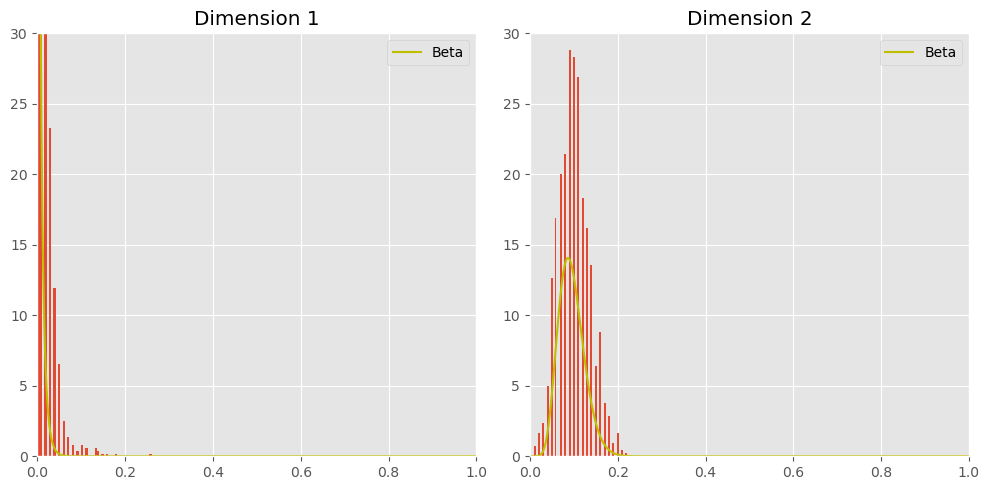

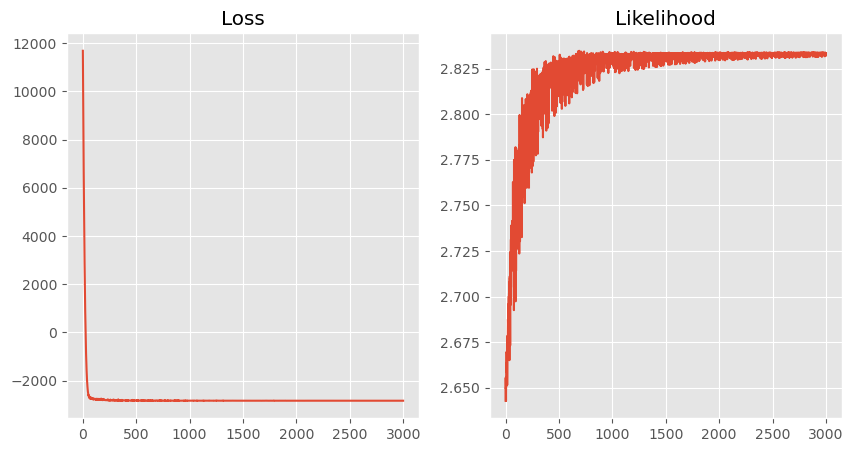

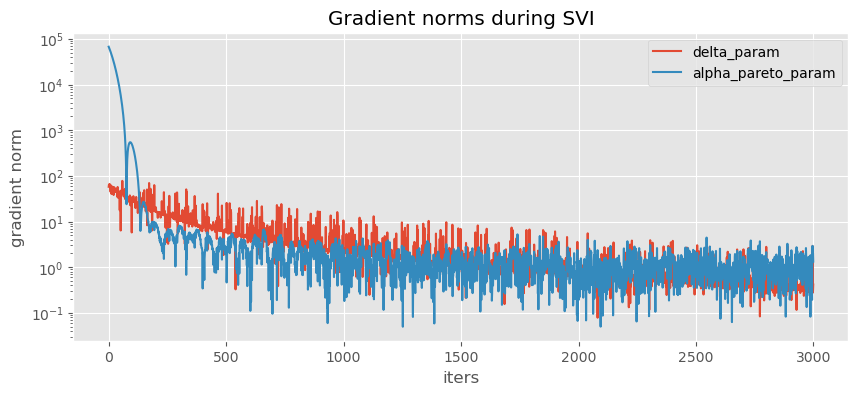

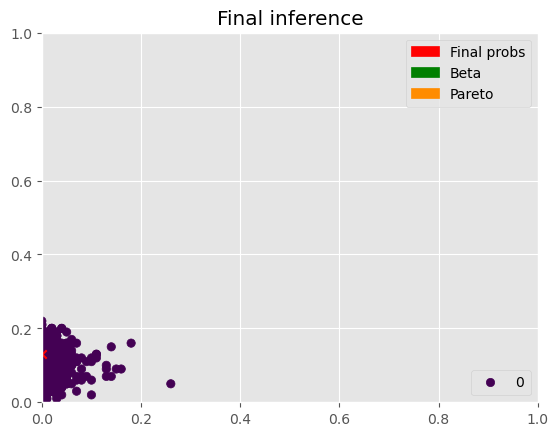

In [25]:
mb = mobster_MV(NV, DP, K = 1, seed = 13)
mb.fit(num_iter = 3000, lr = 0.005)

In [26]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0)) # x axis, beta
print(compute_likelihood(mb, beta = False, dim = 0, k = 0)) # x axis, pareto
print(compute_likelihood(mb, beta = True, dim = 1, k = 0)) # y axis, beta
print(compute_likelihood(mb, beta = False, dim = 1, k = 0)) # y axis, pareto

tensor(5.4398, grad_fn=<SumBackward0>)
tensor(2.0460, grad_fn=<SumBackward0>)
tensor(4.2997, grad_fn=<SumBackward0>)
tensor(2.3295, grad_fn=<SumBackward0>)


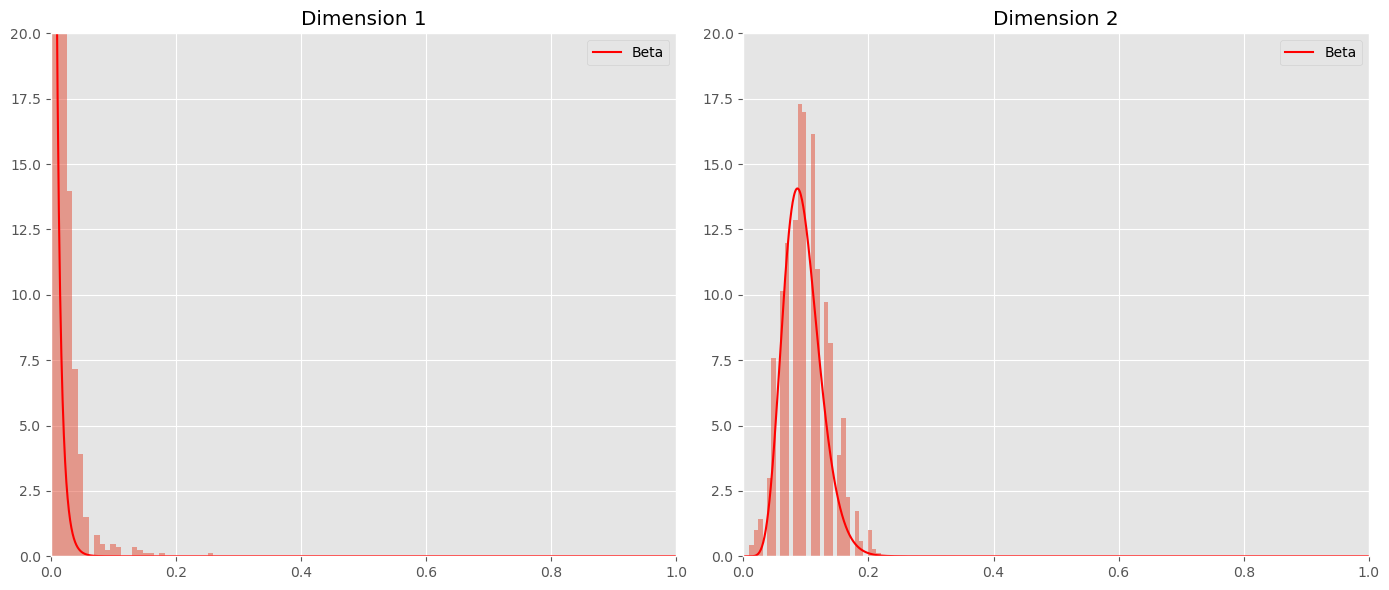

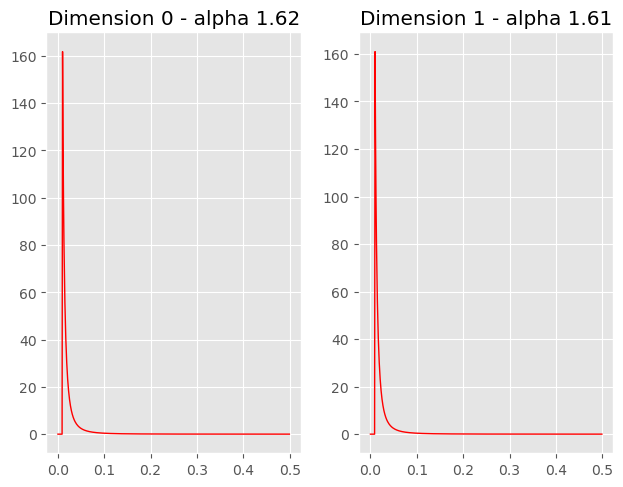

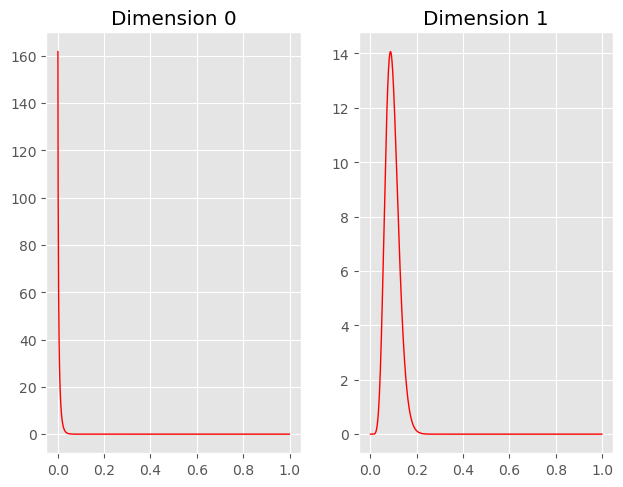

In [27]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [28]:
mb.params

{'weights_param': tensor([1.], grad_fn=<DivBackward0>),
 'alpha_prior_param': tensor([[2.5194, 2.5006]], grad_fn=<AddBackward0>),
 'alpha_pareto_param': tensor([[1.6171, 1.6097]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.0049, 0.0949]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[100.0837, 100.3504]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[2.0401e-03, 9.9796e-01],
          [2.2039e-04, 9.9978e-01]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045,
          0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045,
          0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045,
          0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045,
          0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045,
          0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045,
          0.0045, 0.0045, 0.0045

### 2 beta-pareto components

In [4]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.2
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Sample S2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([1500, 2])
torch.Size([1500, 2])


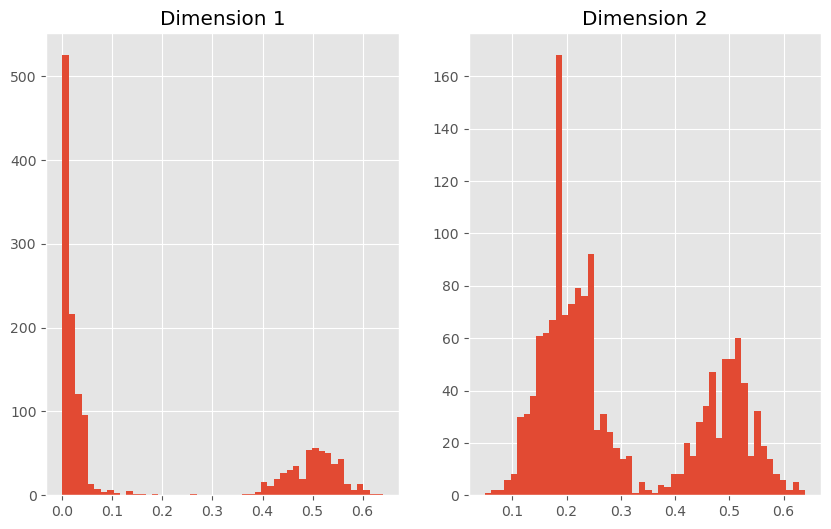

In [5]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [6]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

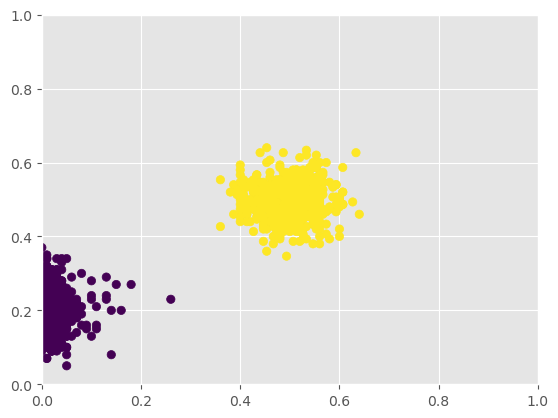

In [7]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])


Text(0.5, 1.0, 'kmeans')

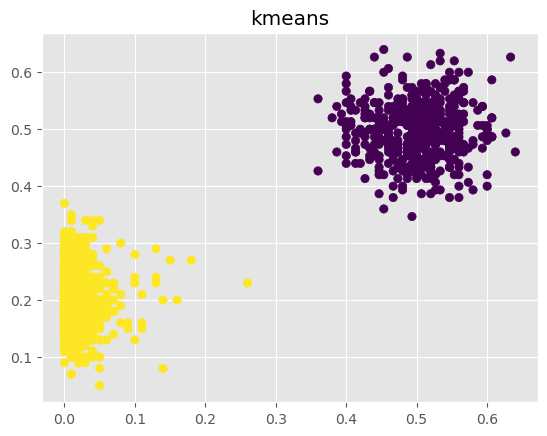

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.title("kmeans")

In [9]:
# x = torch.linspace(0.01, 0.999, LINSPACE)
# y_1_0 = BoundedPareto(0.01, alpha[0], 0.55).log_prob(x).exp() # dim 0
# y_1_1 = BoundedPareto(0.01, alpha[1], 0.55).log_prob(x).exp() # dim 1
# y_2_0 = dist.Binomial(probs = x.repeat([self.NV.shape[0],1]).reshape([LINSPACE,-1]), total_count=self.DP[:,0]).log_prob(self.NV[:,0]).exp()
# y_2_1 = dist.Binomial(probs = x.repeat([self.NV.shape[0],1]).reshape([LINSPACE,-1]), total_count=self.DP[:,1]).log_prob(self.NV[:,1]).exp()
# pareto_0 = torch.trapz(y_1_0.reshape([LINSPACE, 1]) * y_2_0, x =  x, dim = 0).log()
# pareto_1 = torch.trapz(y_1_1.reshape([LINSPACE, 1]) * y_2_1, x =  x, dim = 0).log()
# ParetoBin = torch.stack([pareto_0, pareto_1], dim=1)

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])
Iteration 0: Loss = 17628124.0
weights_param tensor([0.4941, 0.5059], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0201, 2.0201],
        [2.0189, 2.0201]], grad_fn=<AddBackward0>)
alpha_pareto_param tensor([[1.9801, 1.9801],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.5019, 0.4977],
        [0.0189, 0.2015]], grad_fn=<AddBackward0>)
k_beta_param tensor([[101.0049, 101.0047],
        [ 99.0466, 101.0051]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.9452, 0.0548],
         [0.6222, 0.3778]],

        [[0.3912, 0.6088],
         [0.2409, 0.7591]]], grad_fn=<DivBackward0>)


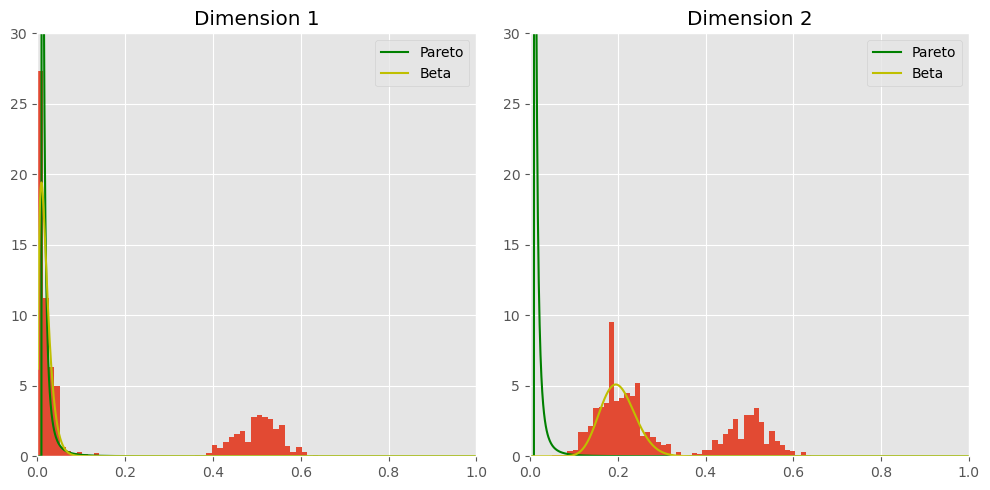

Iteration 200: Loss = 15142546.0
Iteration 400: Loss = 14371390.0
phi_beta [[0.5019884  0.4972369 ]
 [0.02132654 0.20171665]]
delta [[[0.3834321  0.61656785]
  [0.1126106  0.88738936]]

 [[0.28573525 0.71426475]
  [0.03198034 0.9680197 ]]]


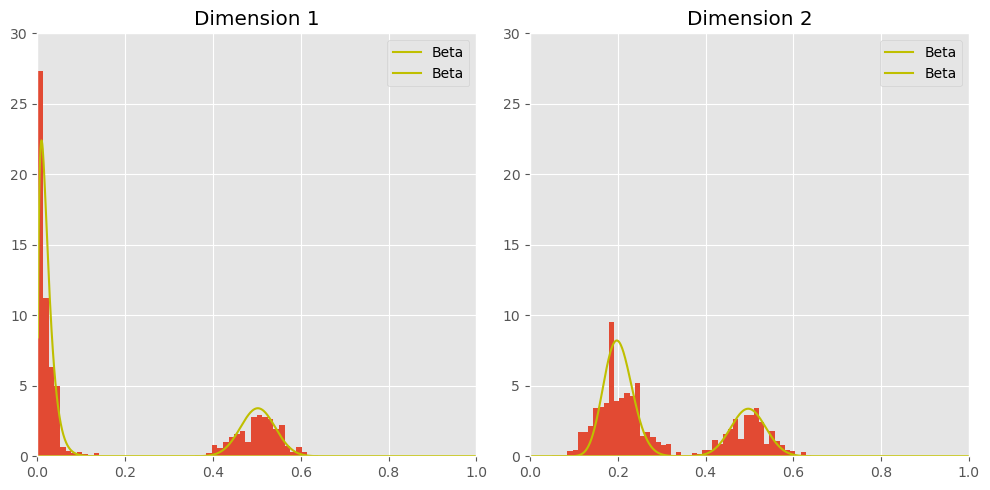

Iteration 600: Loss = 14092098.0
Iteration 800: Loss = 14025470.0
phi_beta [[0.50198966 0.4975589 ]
 [0.02212021 0.20142604]]
delta [[[0.12147339 0.8785266 ]
  [0.04112552 0.95887446]]

 [[0.388087   0.611913  ]
  [0.01270241 0.98729765]]]


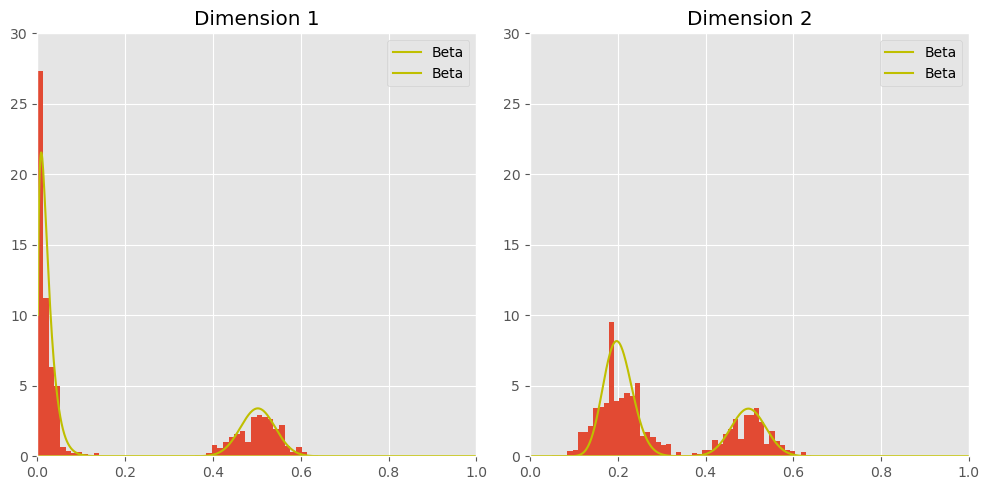

Iteration 1000: Loss = 13964362.0
Iteration 1200: Loss = 13940379.0
phi_beta [[0.50198185 0.49767488]
 [0.02468705 0.20119484]]
delta [[[0.05777369 0.94222635]
  [0.02126939 0.9787306 ]]

 [[0.47951263 0.5204873 ]
  [0.00705866 0.9929414 ]]]


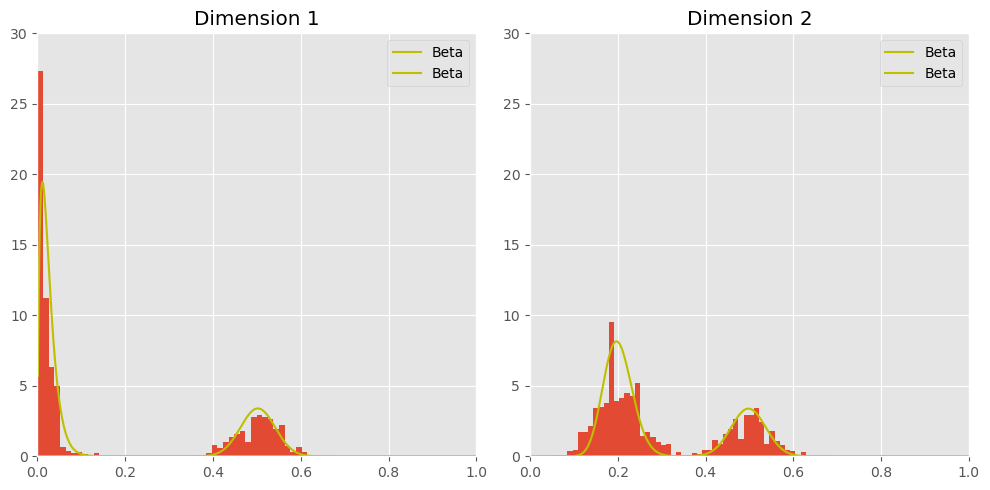

Iteration 1400: Loss = 13913246.0
Iteration 1600: Loss = 13905273.0
phi_beta [[0.5019903  0.49771953]
 [0.02672483 0.20119779]]
delta [[[0.03362305 0.96637696]
  [0.01291924 0.98708075]]

 [[0.55564725 0.44435272]
  [0.00455119 0.99544877]]]


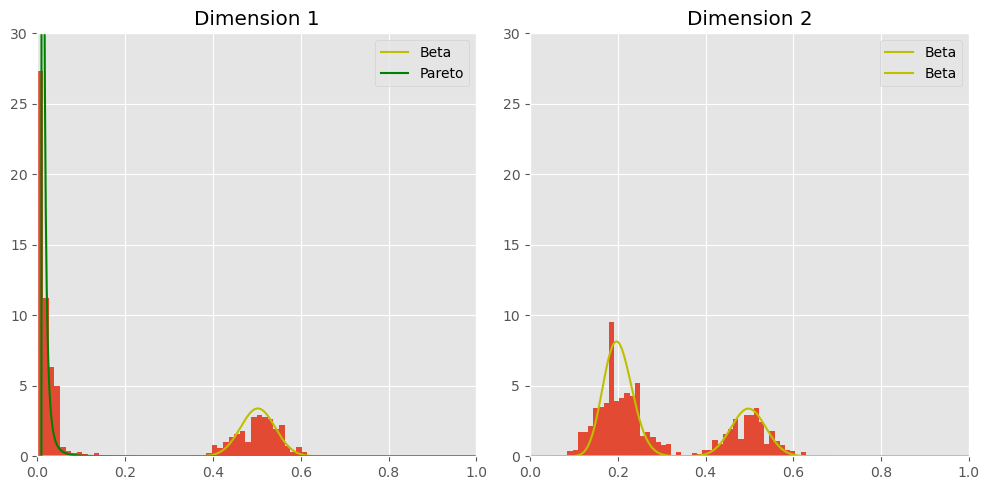

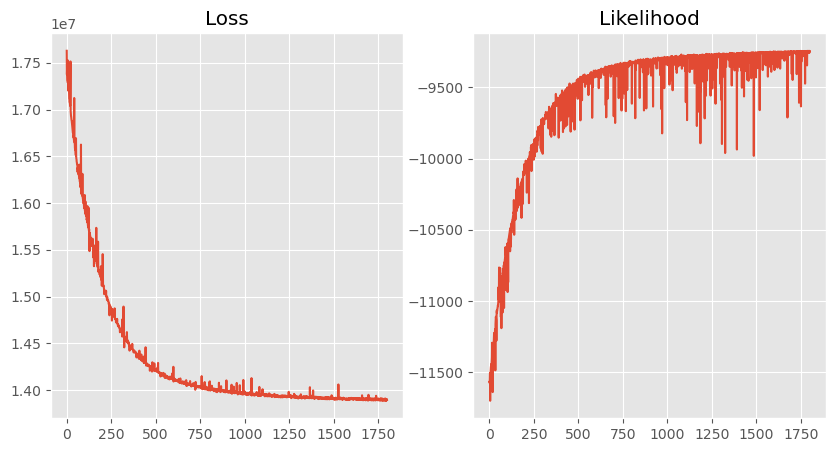

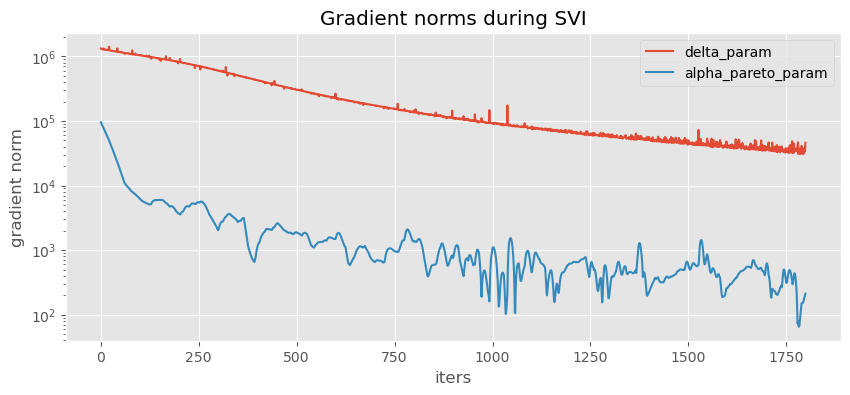

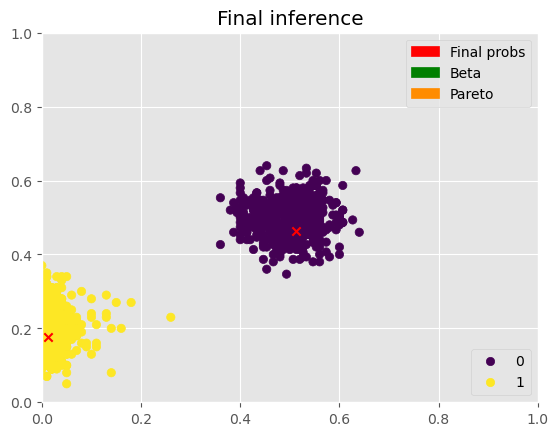

In [25]:
mb = mobster_MV(NV, DP, K = 2, seed = 56)
mb.fit(num_iter = 1800, lr = 0.005)

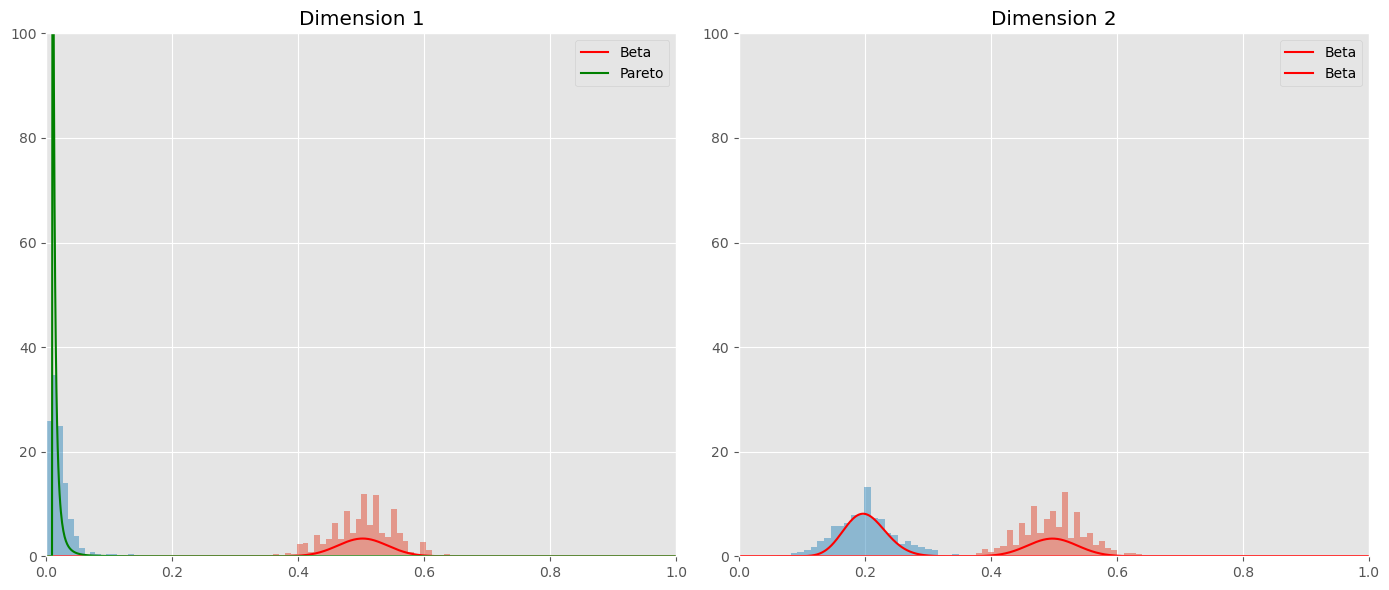

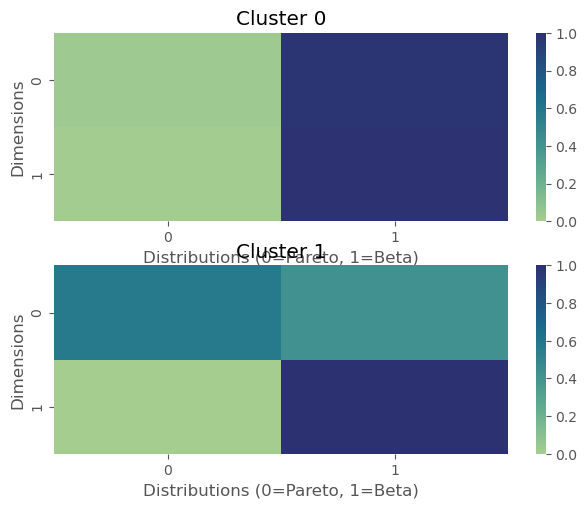

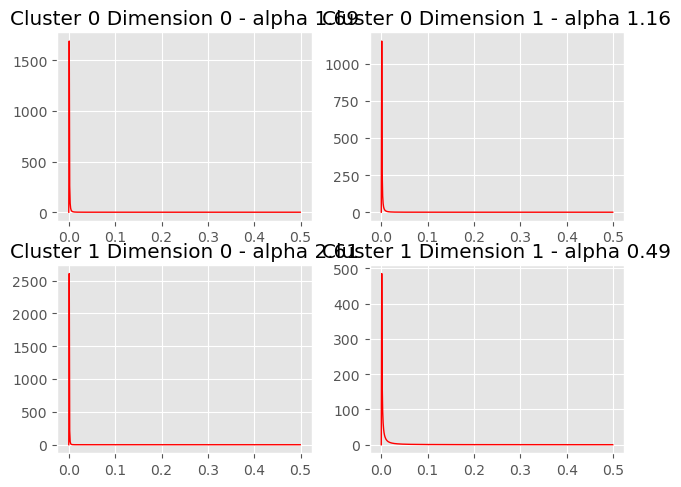

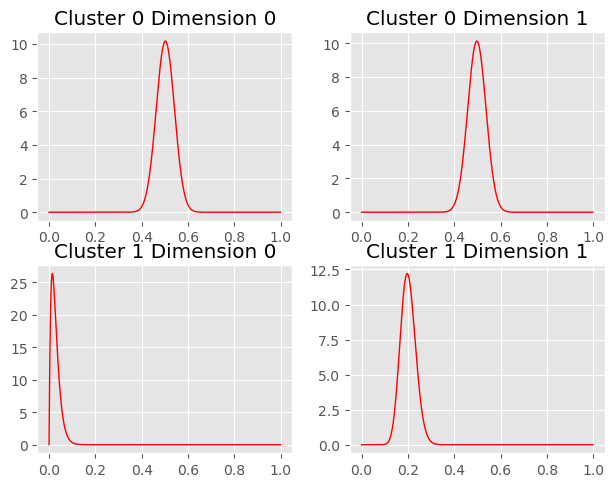

In [29]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [27]:
mb.params

{'weights_param': tensor([0.3335, 0.6665], grad_fn=<DivBackward0>),
 'alpha_prior_param': tensor([[2.7109, 1.5870],
         [6.7695, 0.8045]], grad_fn=<AddBackward0>),
 'alpha_pareto_param': tensor([[1.6905, 1.1553],
         [2.6062, 0.4855]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.5020, 0.4977],
         [0.0277, 0.2012]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[163.0388, 161.9739],
         [ 71.8967, 149.1158]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.0268, 0.9732],
          [0.0104, 0.9896]],
 
         [[0.5757, 0.4243],
          [0.0038, 0.9962]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[9.1619e-07, 3.0212e-05, 3.2849e-06,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [1.0000e+00, 9.9997e-01, 1.0000e+00,  ..., 1.8872e-19, 1.0854e-23,
          2.1201e-14]], grad_fn=<CopySlices>),
 'cluster_assignments': tensor([1, 1, 1,  ..., 0, 0, 0])}

### 4 beta-pareto components

In [40]:
N1 = 500
N2 = 300
N3 = 200
N4 = 200
N5 = 200
seed = 123
# Component 1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.5
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Component 2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n3=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))

# Component 4
phi_beta_x = 0.3
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n4=150
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV = torch.concat((NV,NV4))
print(NV.shape)
DP = torch.concat((DP,DP4))
print(DP.shape)

# Component 5
phi_beta_x = 0.1
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n5=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n5, N=N5, seed=seed)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))


torch.Size([1200, 2])
torch.Size([1200, 2])


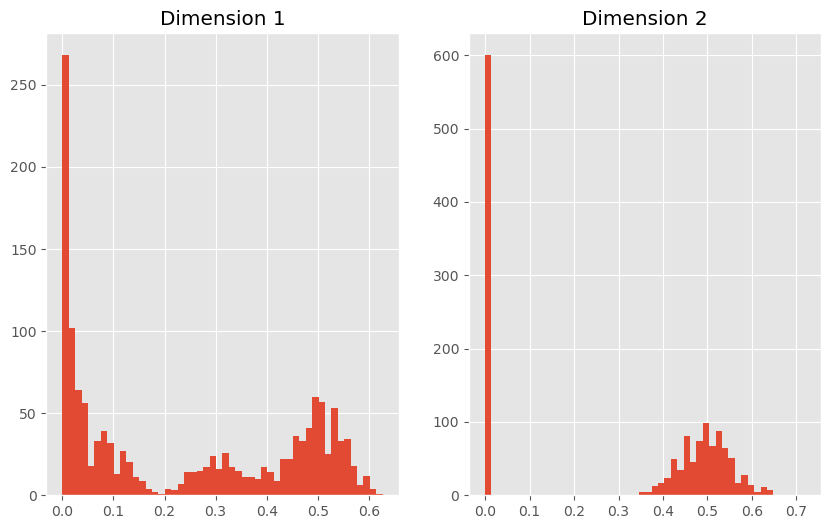

In [41]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [42]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N3)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N3)*4
labels = np.concatenate((labels, labels_5))

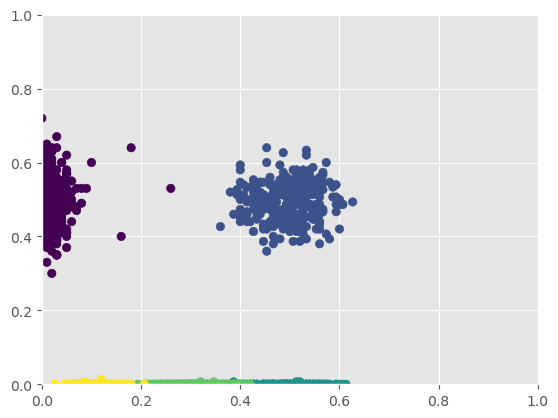

In [43]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[4.9805e-01, 6.7055e-05],
        [1.8076e-02, 4.9715e-01],
        [4.9825e-01, 4.9501e-01],
        [1.0017e-01, 9.9927e-05],
        [3.0304e-01, 9.8795e-05]])
inertia:  4.6338300704956055


(0.0, 1.0)

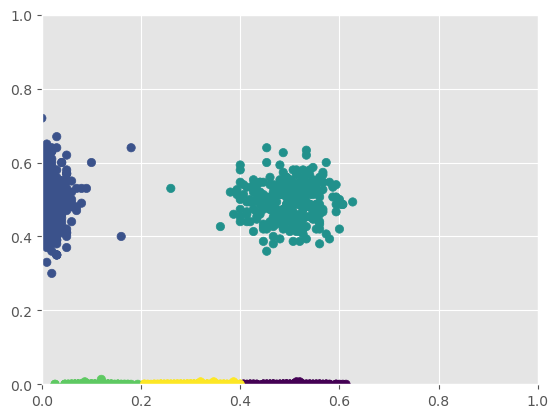

In [44]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)
print("inertia: ", kmeans.inertia_) # the lower the better

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.xlim([0,1])
plt.ylim([0,1])

kmeans_centers:  tensor([[1.0017e-01, 9.9927e-05],
        [1.8076e-02, 4.9715e-01],
        [4.9825e-01, 4.9501e-01],
        [5.0059e-01, 6.8814e-05],
        [3.0538e-01, 9.6411e-05]])
inertia:  4.6314496994018555


(0.0, 1.0)

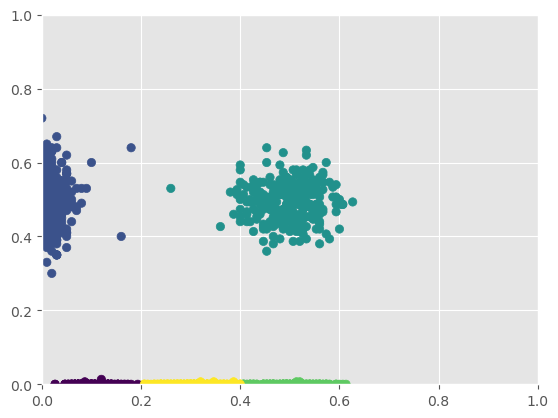

In [45]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=45, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)
print("inertia: ", kmeans.inertia_) # the lower the better

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.xlim([0,1])
plt.ylim([0,1])

kmeans_centers:  tensor([[4.9805e-01, 6.7055e-05],
        [1.8076e-02, 4.9715e-01],
        [4.9825e-01, 4.9501e-01],
        [1.0017e-01, 9.9927e-05],
        [3.0304e-01, 9.8795e-05]])
Iteration 0: Loss = 16854142.0
weights_param tensor([0.1774, 0.2376, 0.0278, 0.2609, 0.2962], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0201, 2.0201],
        [2.0201, 2.0200],
        [2.0179, 2.0201],
        [2.0200, 2.0199],
        [2.0201, 2.0195]], grad_fn=<AddBackward0>)
alpha_pareto_param tensor([[1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[4.9816e-01, 6.6388e-05],
        [1.8248e-02, 4.9723e-01],
        [4.9836e-01, 4.9514e-01],
        [1.0097e-01, 9.8934e-05],
        [3.0426e-01, 9.7818e-05]], grad_fn=<AddBackward0>)
k_beta_param tensor([[101.0030,  99.0169],
        [ 99.7991, 100.9988],
        [101.0055, 100.9973],
        [101.0029,  99.0209],
    

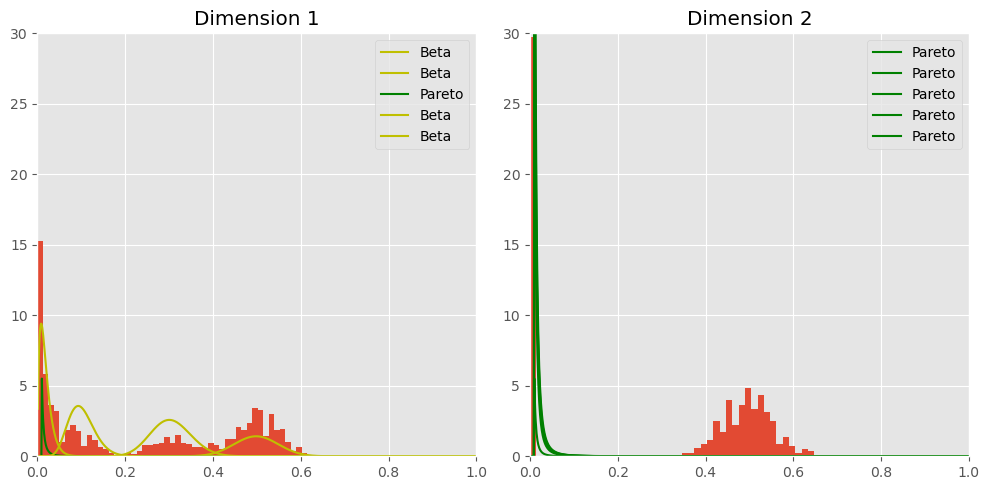

Iteration 200: Loss = 13437211.0
Iteration 400: Loss = 12525243.0
phi_beta [[5.0057602e-01 1.5926531e-05]
 [2.8271096e-02 4.9871540e-01]
 [4.9838510e-01 4.9563569e-01]
 [1.0233625e-01 2.4355677e-05]
 [3.0907854e-01 2.3335584e-05]]
delta [[[0.05891878 0.9410812 ]
  [0.13036774 0.8696322 ]]

 [[0.11428843 0.88571155]
  [0.45926824 0.5407317 ]]

 [[0.51971376 0.48028627]
  [0.08643413 0.9135658 ]]

 [[0.05288839 0.9471116 ]
  [0.08866436 0.9113357 ]]

 [[0.00435589 0.9956441 ]
  [0.1787404  0.82125956]]]


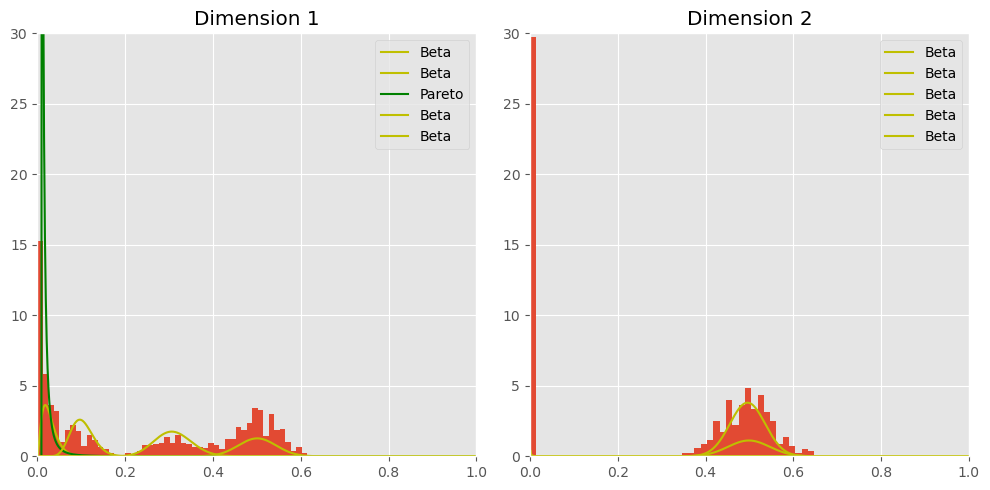

Iteration 600: Loss = 12332824.0
Iteration 800: Loss = 12271602.0
phi_beta [[4.9773490e-01 7.4480290e-06]
 [4.5900062e-02 4.9944261e-01]
 [4.9838737e-01 4.9595746e-01]
 [1.0194726e-01 1.1603074e-05]
 [3.0675533e-01 1.1607423e-05]]
delta [[[0.02379765 0.9762023 ]
  [0.04686458 0.95313543]]

 [[0.04413548 0.95586455]
  [0.287994   0.712006  ]]

 [[0.5864354  0.41356462]
  [0.02781063 0.97218937]]

 [[0.02142307 0.9785769 ]
  [0.03520599 0.96479404]]

 [[0.00178239 0.99821764]
  [0.06626797 0.933732  ]]]


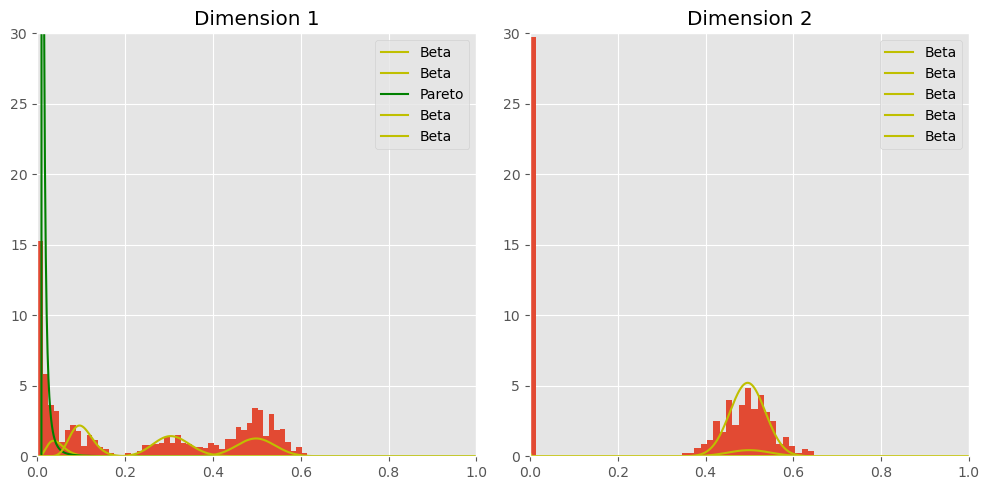

Iteration 1000: Loss = 12256019.0
Iteration 1200: Loss = 12215422.0
phi_beta [[4.97708023e-01 4.81262305e-06]
 [4.55716439e-02 4.99133557e-01]
 [4.98383462e-01 4.95997936e-01]
 [1.01847164e-01 7.13579948e-06]
 [3.06600153e-01 8.12697817e-06]]
delta [[[1.32896295e-02 9.86710370e-01]
  [2.57043391e-02 9.74295676e-01]]

 [[2.29928382e-02 9.77007151e-01]
  [1.97246075e-01 8.02753866e-01]]

 [[5.85222840e-01 4.14777100e-01]
  [1.42762158e-02 9.85723794e-01]]

 [[1.18501997e-02 9.88149762e-01]
  [2.00267825e-02 9.79973197e-01]]

 [[9.89866443e-04 9.99010086e-01]
  [3.74967270e-02 9.62503314e-01]]]


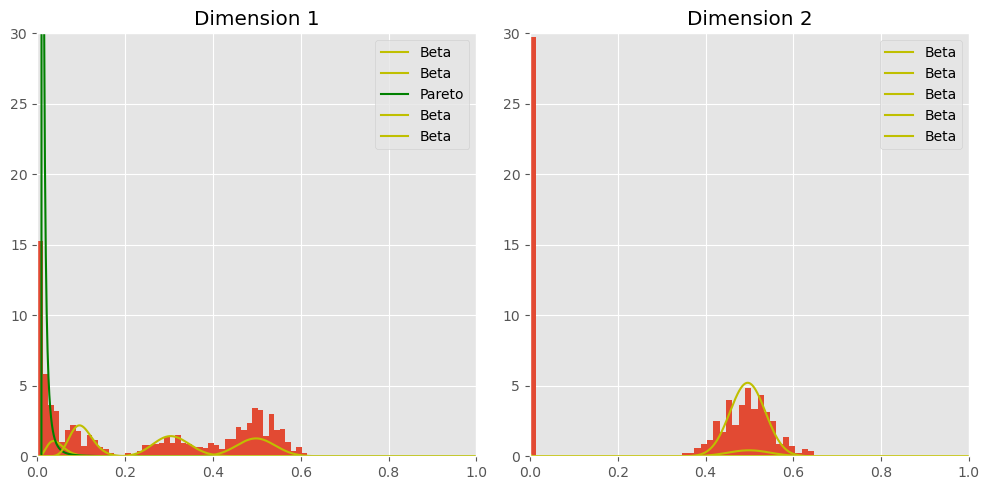

Iteration 1400: Loss = 12245051.0
Iteration 1600: Loss = 12227269.0
phi_beta [[4.9766463e-01 3.8474705e-06]
 [4.1217070e-02 4.9790171e-01]
 [4.9838358e-01 4.9605832e-01]
 [1.0161008e-01 5.1531524e-06]
 [3.0660522e-01 7.1843206e-06]]
delta [[[8.6980276e-03 9.9130189e-01]
  [1.7247288e-02 9.8275268e-01]]

 [[1.5314140e-02 9.8468590e-01]
  [1.3024990e-01 8.6975014e-01]]

 [[5.7770282e-01 4.2229715e-01]
  [8.9646969e-03 9.9103528e-01]]

 [[7.6457830e-03 9.9235415e-01]
  [1.3942482e-02 9.8605746e-01]]

 [[6.3222490e-04 9.9936777e-01]
  [2.6100617e-02 9.7389936e-01]]]


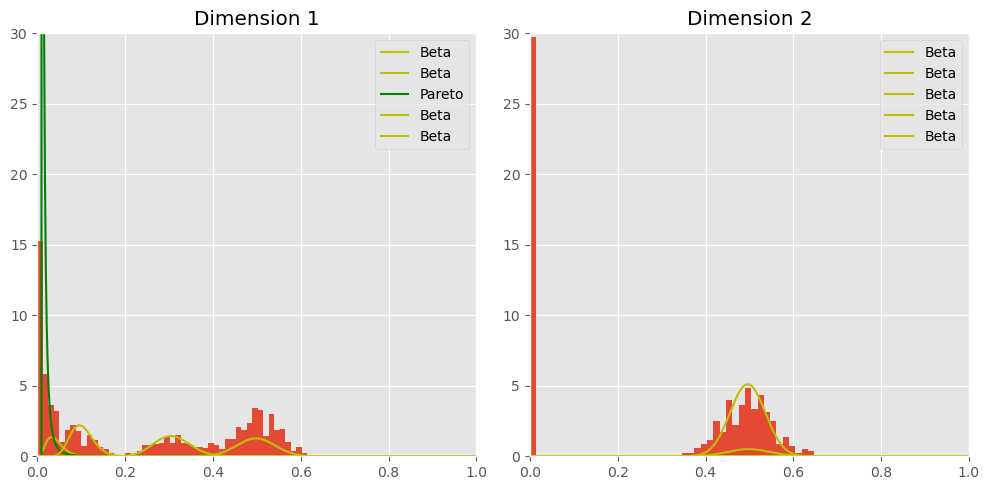

Iteration 1800: Loss = 12224465.0
Iteration 2000: Loss = 12206024.0
phi_beta [[4.9768627e-01 3.6731847e-06]
 [3.6007456e-02 4.9702728e-01]
 [4.9838859e-01 4.9625513e-01]
 [1.0155983e-01 4.2441134e-06]
 [3.0650565e-01 8.0473792e-06]]
delta [[[6.1087646e-03 9.9389124e-01]
  [1.3209887e-02 9.8679012e-01]]

 [[1.1593837e-02 9.8840618e-01]
  [8.1346162e-02 9.1865391e-01]]

 [[5.6284273e-01 4.3715724e-01]
  [6.2983246e-03 9.9370170e-01]]

 [[5.2776150e-03 9.9472237e-01]
  [1.1191431e-02 9.8880857e-01]]

 [[4.3628368e-04 9.9956375e-01]
  [2.0585012e-02 9.7941500e-01]]]


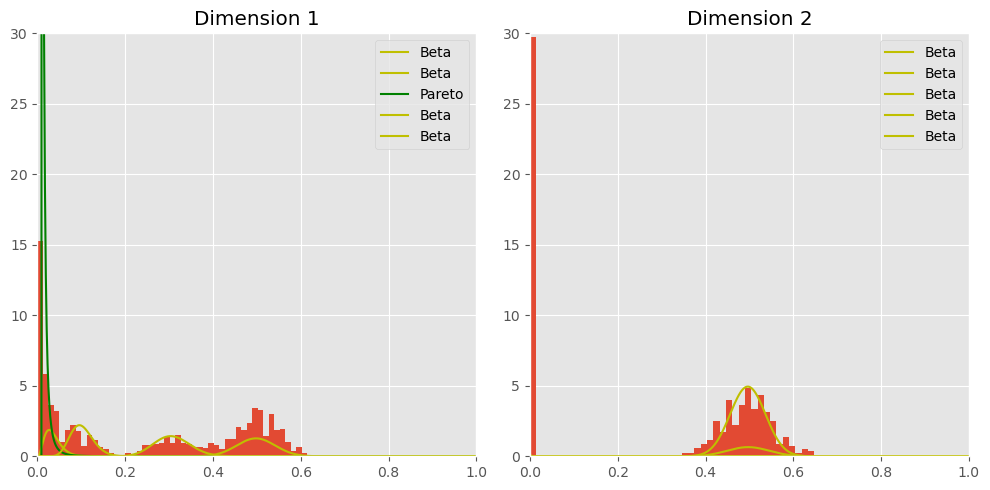

Iteration 2200: Loss = 12212040.0
Iteration 2400: Loss = 12197253.0
phi_beta [[4.9768141e-01 4.5565544e-06]
 [3.3465602e-02 4.9638894e-01]
 [4.9839735e-01 4.9622989e-01]
 [1.0128531e-01 3.9725705e-06]
 [3.0660313e-01 1.4394971e-05]]
delta [[[4.48947586e-03 9.95510578e-01]
  [1.09877242e-02 9.89012241e-01]]

 [[1.00037055e-02 9.89996314e-01]
  [5.14581017e-02 9.48541939e-01]]

 [[5.48939526e-01 4.51060474e-01]
  [4.74282028e-03 9.95257199e-01]]

 [[3.82016227e-03 9.96179819e-01]
  [1.01134330e-02 9.89886642e-01]]

 [[3.14817706e-04 9.99685168e-01]
  [1.73944570e-02 9.82605577e-01]]]


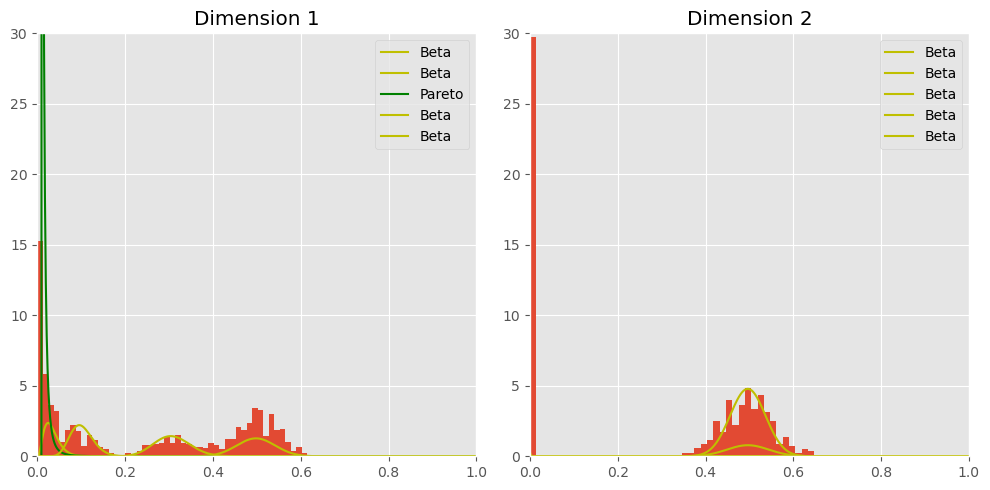

Iteration 2600: Loss = 12197956.0
Iteration 2800: Loss = 12193891.0
phi_beta [[4.9771297e-01 9.8598393e-06]
 [3.1306036e-02 4.9607217e-01]
 [4.9840775e-01 4.9618459e-01]
 [1.0127429e-01 4.1930125e-06]
 [3.0665705e-01 5.6656769e-05]]
delta [[[3.4026627e-03 9.9659735e-01]
  [9.6958643e-03 9.9030417e-01]]

 [[9.3409903e-03 9.9065900e-01]
  [3.3057060e-02 9.6694291e-01]]

 [[5.3478378e-01 4.6521616e-01]
  [3.7209520e-03 9.9627906e-01]]

 [[2.8981115e-03 9.9710184e-01]
  [9.9698268e-03 9.9003017e-01]]

 [[2.3575091e-04 9.9976426e-01]
  [1.4558732e-02 9.8544127e-01]]]


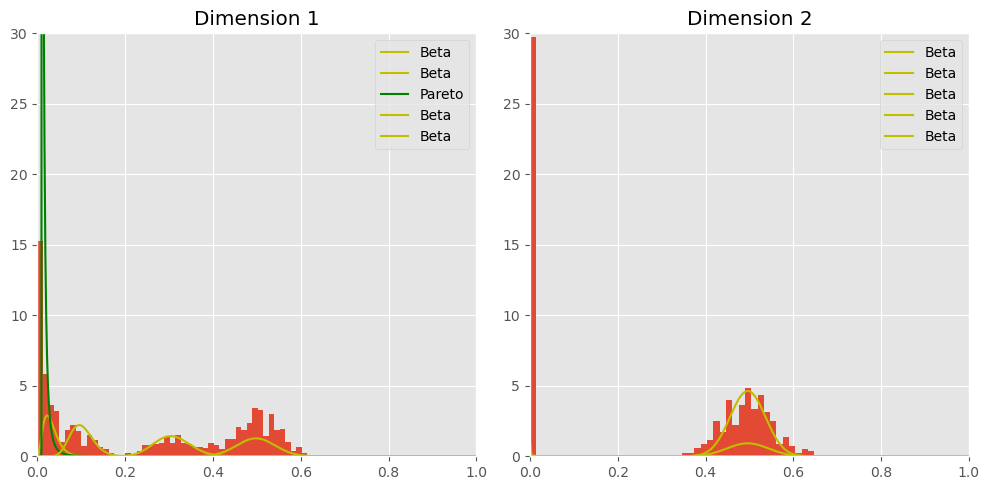

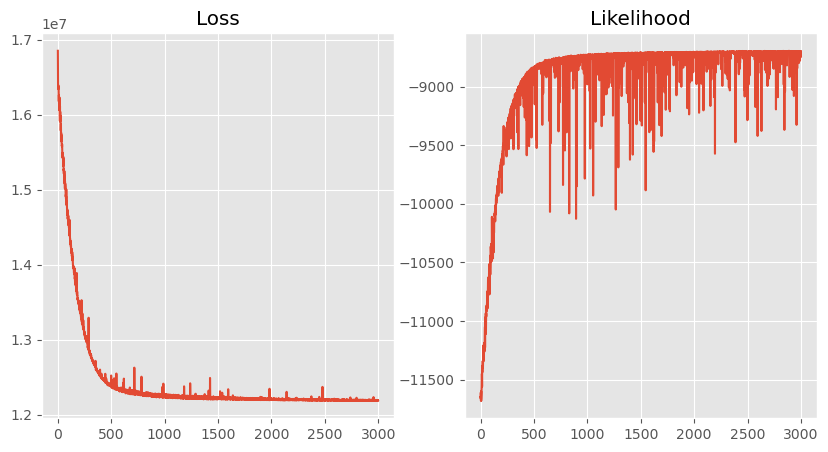

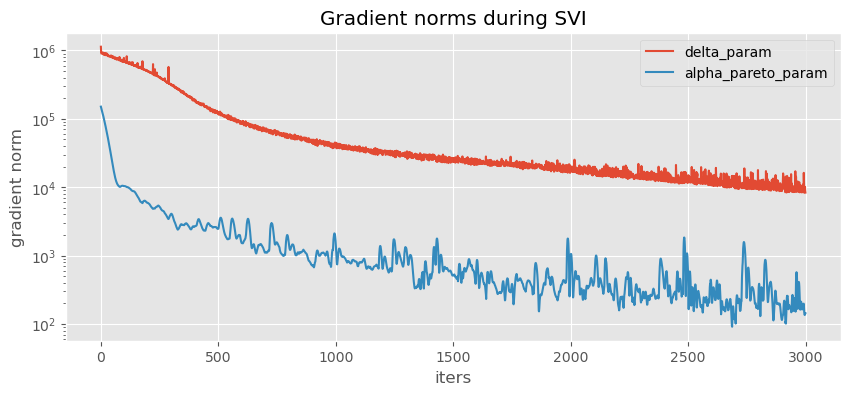

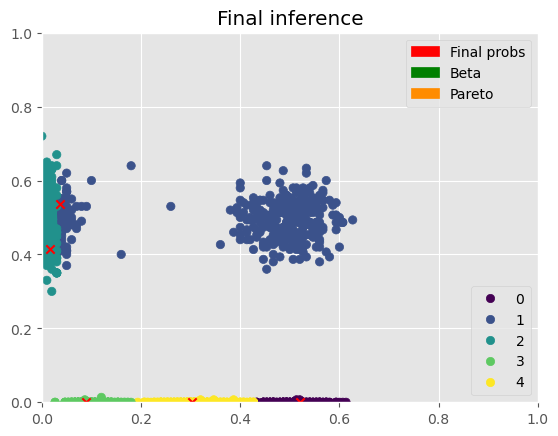

In [46]:
mb = mobster_MV(NV, DP, K = 5, seed = 123)
mb.fit(num_iter = 3000, lr = 0.005)

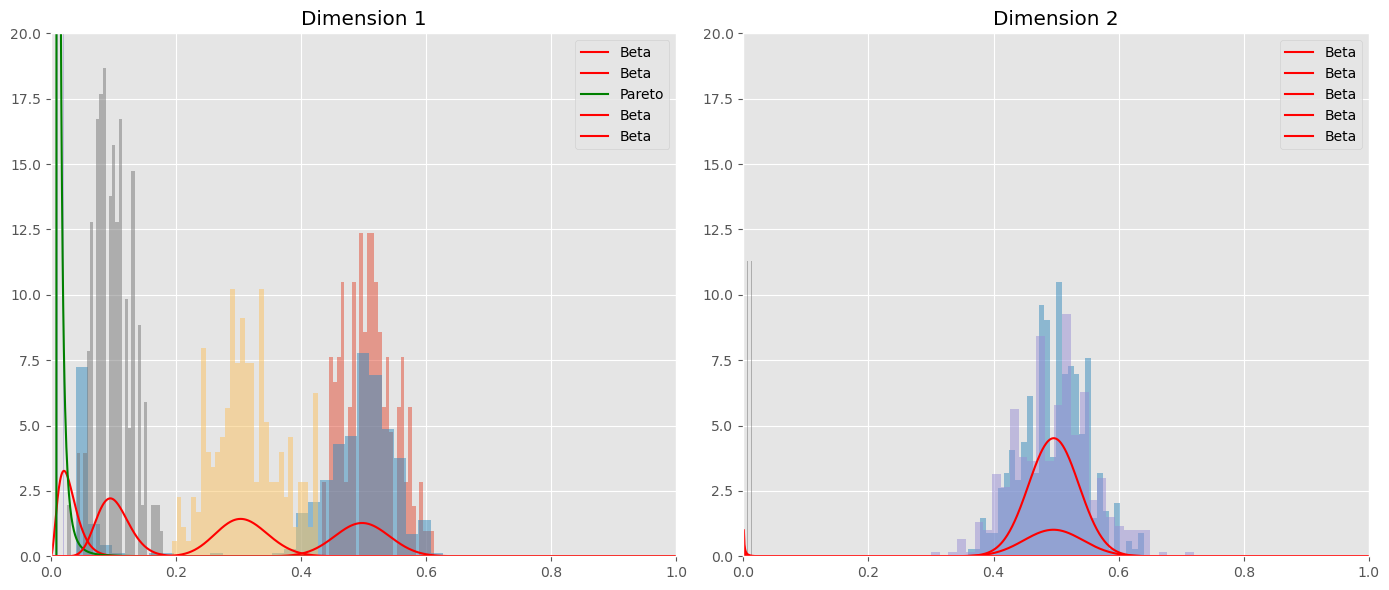

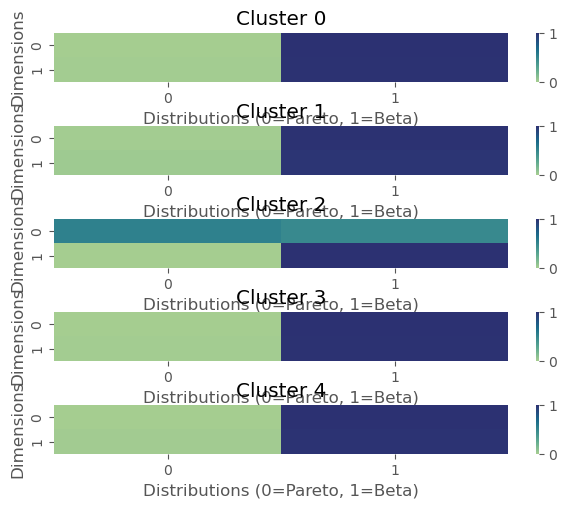

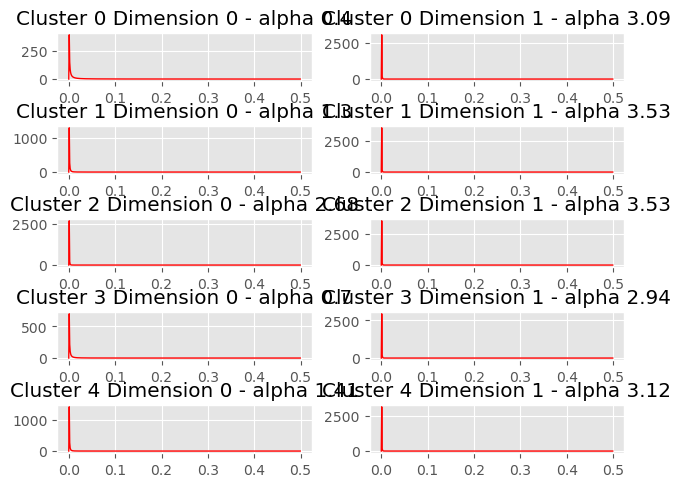

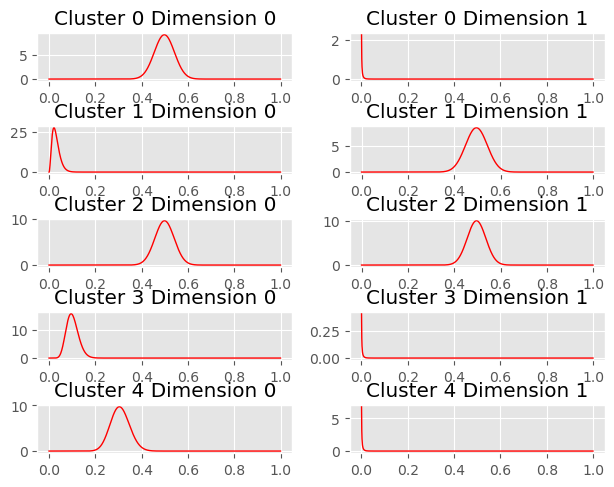

In [47]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [48]:
mb.params

{'weights_param': tensor([0.1383, 0.1191, 0.4534, 0.1419, 0.1472], grad_fn=<DivBackward0>),
 'alpha_prior_param': tensor([[ 0.7394, 10.9453],
         [ 1.8329, 17.1215],
         [ 7.2947, 17.1042],
         [ 1.0037,  9.5032],
         [ 2.0411, 11.3672]], grad_fn=<AddBackward0>),
 'alpha_pareto_param': tensor([[0.3950, 3.0860],
         [1.2985, 3.5334],
         [2.6797, 3.5323],
         [0.7004, 2.9448],
         [1.4068, 3.1236]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[4.9770e-01, 2.4801e-05],
         [3.0248e-02, 4.9584e-01],
         [4.9840e-01, 4.9626e-01],
         [1.0128e-01, 4.4530e-06],
         [3.0660e-01, 7.4449e-05]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[133.5729, 100.6059],
         [105.7089, 114.4856],
         [145.4098, 156.3176],
         [133.6825, 100.0651],
         [125.8940, 101.6424]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[2.9938e-03, 9.9701e-01],
          [9.0717e-03, 9.9093e-01]],
 
         [[8.9077e-03, 9.91

### With 3 beta components

In [49]:
N1 = 1000
N2 = 800
N3 = 1000

NV1, DP1 = beta_binomial_component(phi_beta_x = 0.1, k_beta_x = 250, phi_beta_y = 0.1, k_beta_y= 250, n=150, N=N1, seed=seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV3, DP3 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.3, k_beta_y= 250, n=150, N=N3, seed=seed)

NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP)

torch.Size([2800, 2])
torch.Size([2800, 2])


In [50]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

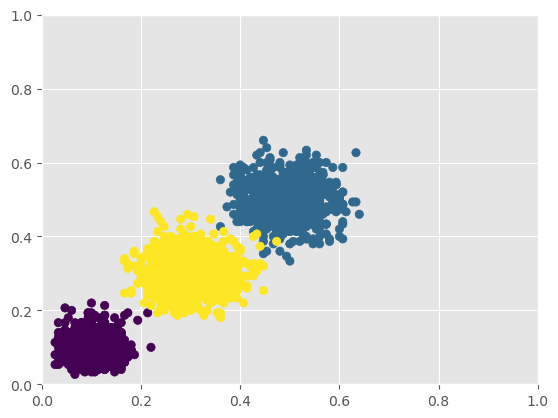

In [51]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

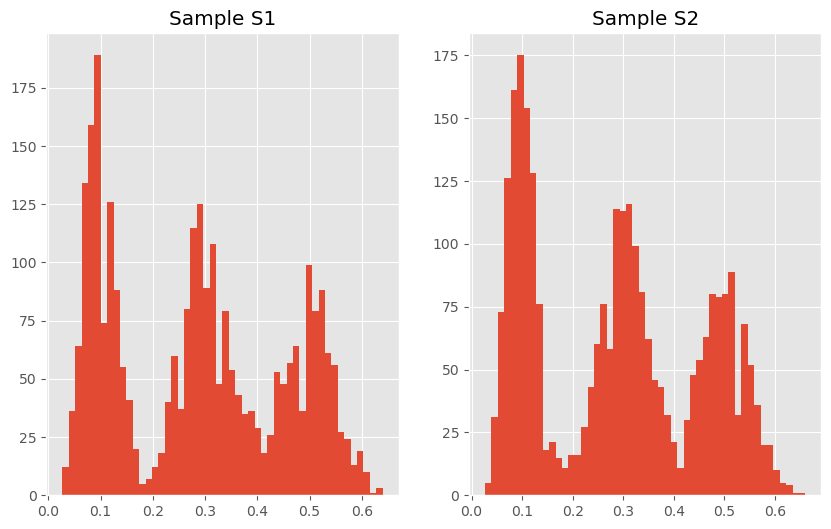

In [52]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

kmeans_centers:  tensor([[0.4994, 0.4985],
        [0.3003, 0.3027],
        [0.0985, 0.0993]])
Iteration 0: Loss = 79202336.0
weights_param tensor([0.5613, 0.1840, 0.2547], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[1.9837, 1.9836],
        [2.0042, 1.9837],
        [1.9824, 2.0026]], grad_fn=<AddBackward0>)
alpha_pareto_param tensor([[1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.4993, 0.4986],
        [0.2994, 0.3016],
        [0.0993, 0.1001]], grad_fn=<AddBackward0>)
k_beta_param tensor([[101.0050, 101.0050],
        [100.9712, 101.0033],
        [101.0051, 100.9965]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.7810, 0.2190],
         [0.6509, 0.3491]],

        [[0.3044, 0.6956],
         [0.3466, 0.6534]],

        [[0.5011, 0.4989],
         [0.9844, 0.0156]]], grad_fn=<DivBackward0>)


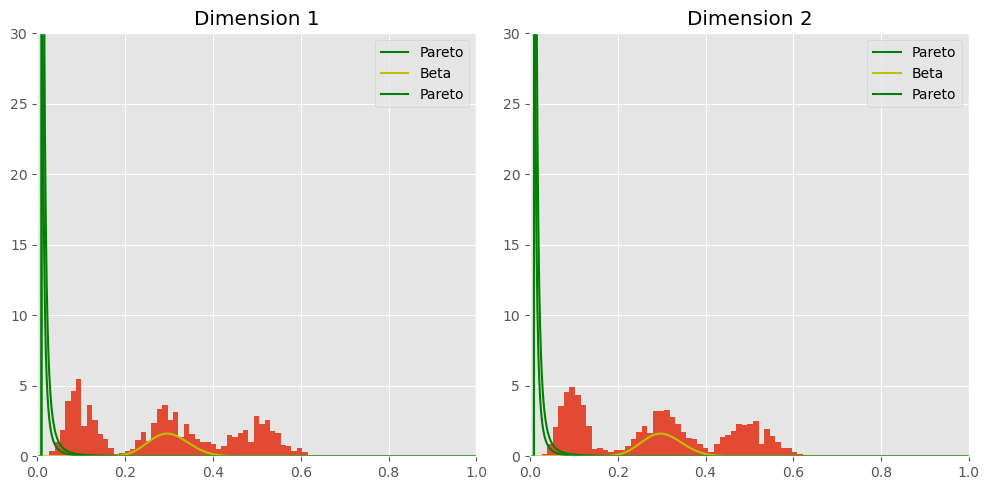

Iteration 200: Loss = 68339232.0
Iteration 400: Loss = 62709116.0
phi_beta [[0.49923444 0.49842772]
 [0.30034846 0.30280736]
 [0.09994832 0.10233338]]
delta [[[0.17886399 0.821136  ]
  [0.12091181 0.8790882 ]]

 [[0.04110901 0.9588909 ]
  [0.04822866 0.9517713 ]]

 [[0.08536565 0.91463435]
  [0.61415976 0.3858402 ]]]


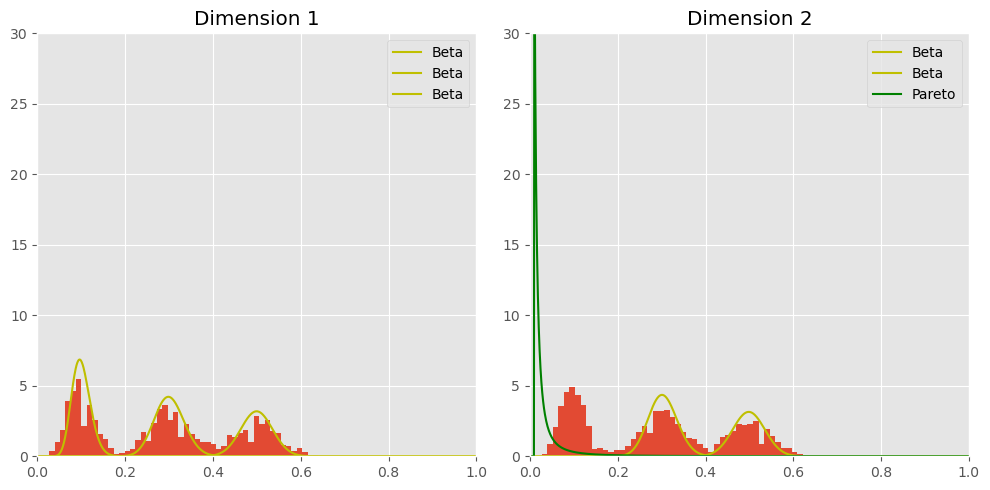

Iteration 600: Loss = 60979816.0
Iteration 800: Loss = 60254288.0
phi_beta [[0.4991589  0.49837804]
 [0.30036673 0.30270824]
 [0.09923887 0.10069788]]
delta [[[0.06233982 0.93766016]
  [0.04364459 0.9563554 ]]

 [[0.01568788 0.9843121 ]
  [0.01833375 0.98166627]]

 [[0.03399796 0.96600205]
  [0.18836841 0.8116316 ]]]


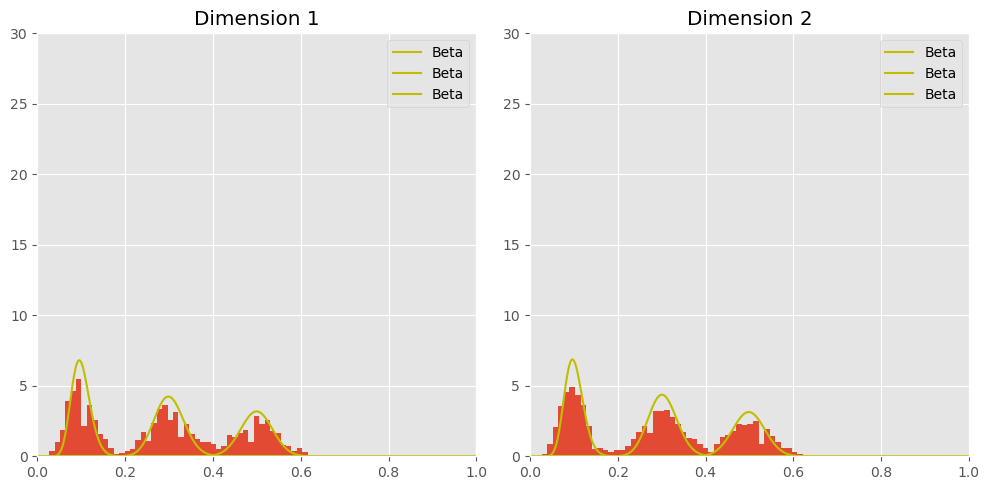

Iteration 1000: Loss = 59971196.0
Iteration 1200: Loss = 59786412.0
phi_beta [[0.49913812 0.49833834]
 [0.30041188 0.30276167]
 [0.09876028 0.10010835]]
delta [[[0.03154451 0.96845543]
  [0.02246006 0.9775399 ]]

 [[0.00828957 0.9917105 ]
  [0.00971243 0.99028754]]

 [[0.01911893 0.9808811 ]
  [0.08623467 0.9137654 ]]]


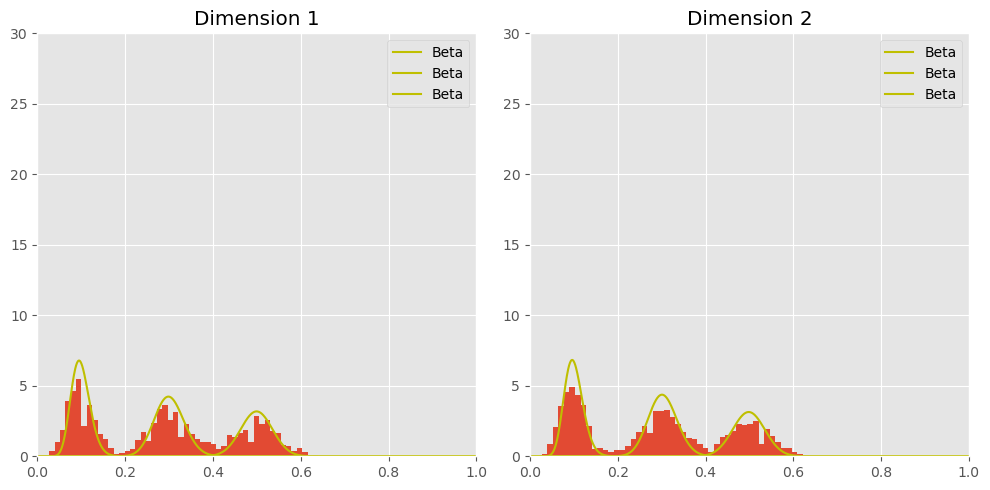

Iteration 1400: Loss = 59691536.0
Iteration 1600: Loss = 59618232.0
phi_beta [[0.49913958 0.49834383]
 [0.30032855 0.30278292]
 [0.09894866 0.10015783]]
delta [[[0.01892821 0.98107177]
  [0.01364029 0.9863598 ]]

 [[0.00511767 0.99488235]
  [0.00596432 0.9940356 ]]

 [[0.01217867 0.9878213 ]
  [0.0490915  0.95090854]]]


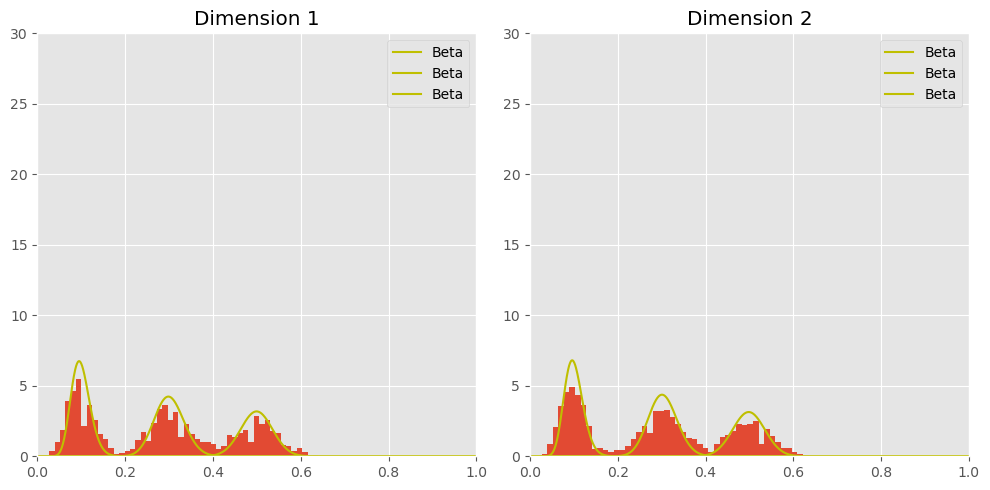

Iteration 1800: Loss = 59535560.0
Iteration 2000: Loss = 59518444.0
phi_beta [[0.49913692 0.49836814]
 [0.3003479  0.30274102]
 [0.09883597 0.09974134]]
delta [[[0.01247815 0.9875218 ]
  [0.00906317 0.9909368 ]]

 [[0.00342968 0.99657035]
  [0.00399104 0.996009  ]]

 [[0.00841096 0.991589  ]
  [0.03196773 0.9680323 ]]]


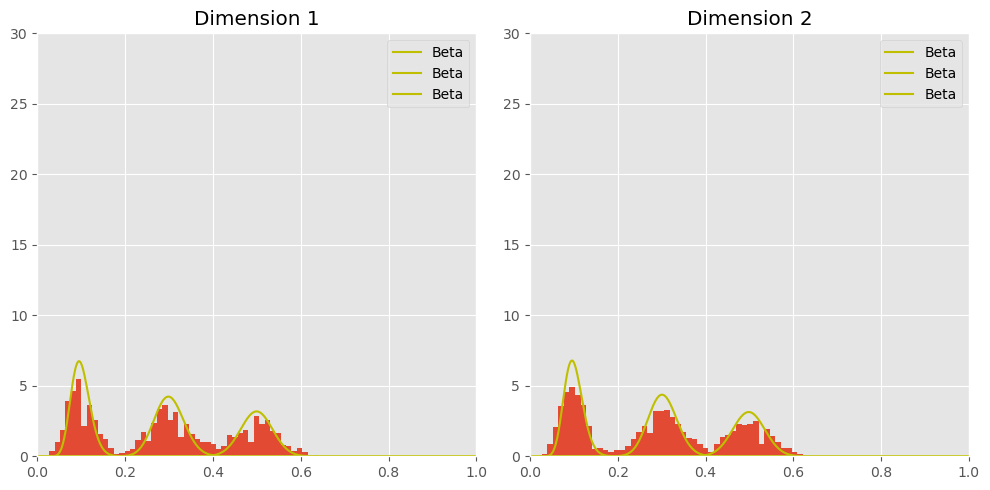

Iteration 2200: Loss = 59473640.0
Iteration 2400: Loss = 59462668.0
phi_beta [[0.49912998 0.49833757]
 [0.30033037 0.30274022]
 [0.09874505 0.09990378]]
delta [[[0.00873497 0.991265  ]
  [0.00636617 0.99363387]]

 [[0.00242331 0.99757665]
  [0.00282518 0.99717486]]

 [[0.00609975 0.9939003 ]
  [0.02221891 0.9777811 ]]]


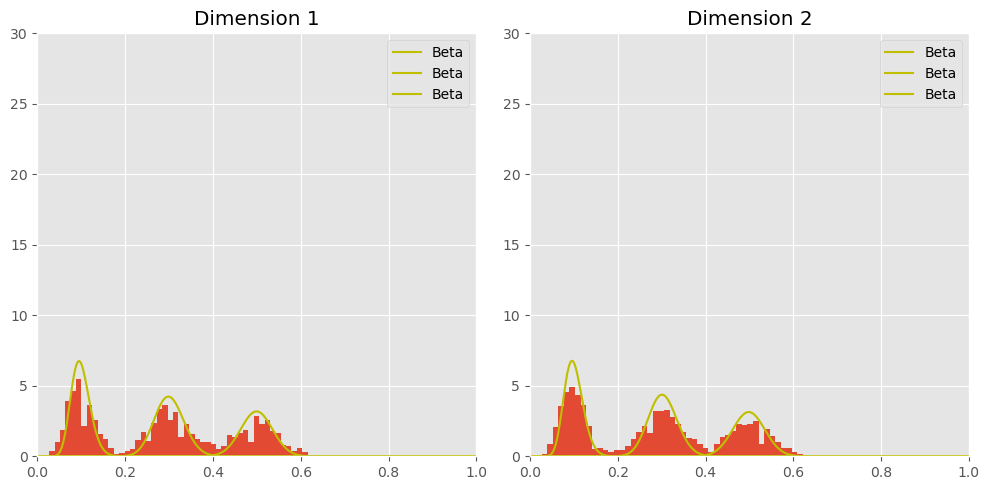

Iteration 2600: Loss = 59439932.0
Iteration 2800: Loss = 59436068.0
phi_beta [[0.49912915 0.4983414 ]
 [0.30031967 0.3027733 ]
 [0.09880338 0.09963892]]
delta [[[0.00635828 0.9936418 ]
  [0.00463891 0.99536115]]

 [[0.00177625 0.9982237 ]
  [0.0020709  0.9979291 ]]

 [[0.00455976 0.99544024]
  [0.01615492 0.983845  ]]]


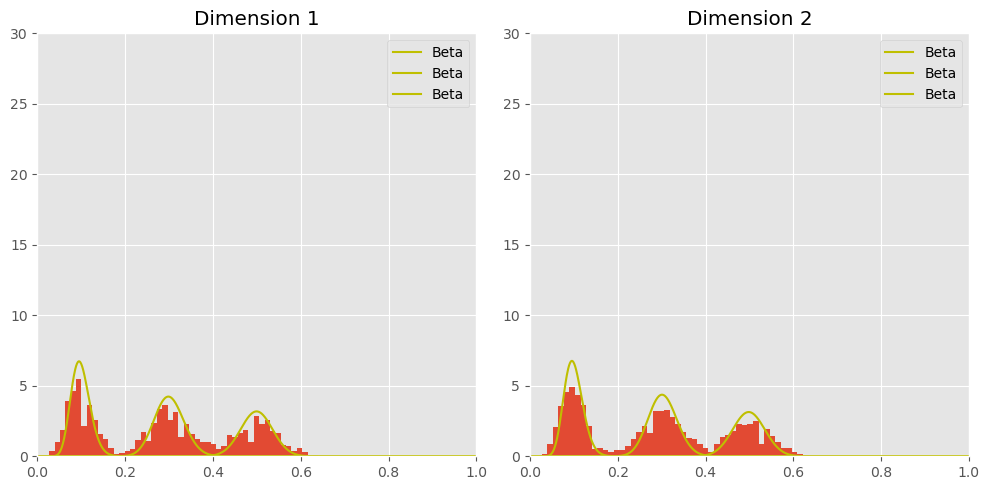

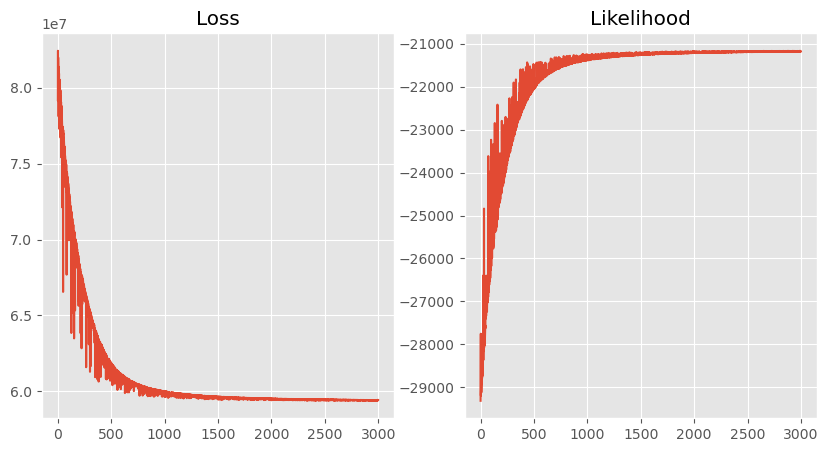

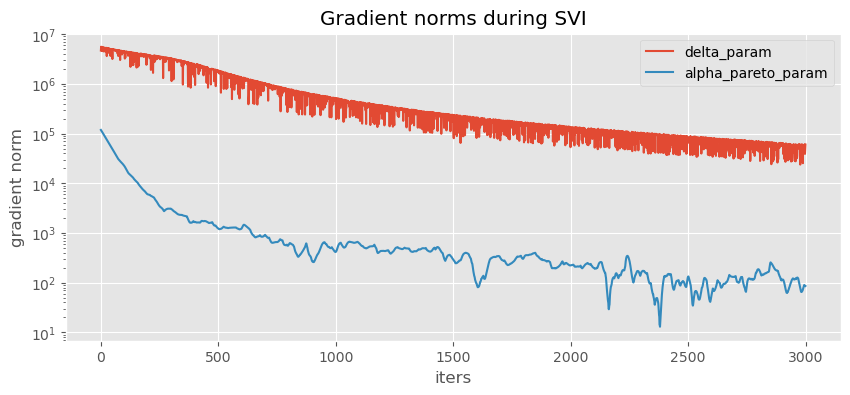

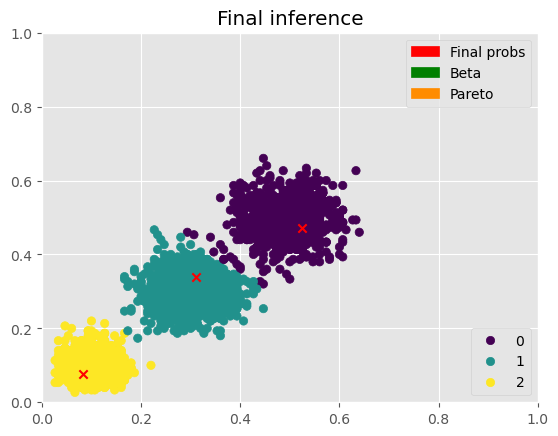

In [54]:
mb = mobster_MV(NV, DP, K = 3, seed = 821)
mb.fit(num_iter = 3000, lr = 0.005)

In [55]:
mb.params

{'weights_param': tensor([0.2868, 0.3566, 0.3566], grad_fn=<DivBackward0>),
 'alpha_prior_param': tensor([[1.4468, 1.2977],
         [1.6000, 1.4667],
         [0.8268, 1.1284]], grad_fn=<AddBackward0>),
 'alpha_pareto_param': tensor([[1.0624, 0.9541],
         [1.1633, 1.0759],
         [0.5070, 0.8146]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.4991, 0.4983],
         [0.3004, 0.3027],
         [0.0987, 0.0998]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[194.1899, 188.6720],
         [185.9140, 199.0217],
         [193.9142, 196.8948]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.0055, 0.9945],
          [0.0040, 0.9960]],
 
         [[0.0015, 0.9985],
          [0.0018, 0.9982]],
 
         [[0.0040, 0.9960],
          [0.0139, 0.9861]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[1.0608e-37, 3.7740e-35, 0.0000e+00,  ..., 6.0641e-11, 6.2465e-07,
          8.2417e-08],
         [1.2212e-15, 7.3959e-14, 2.0294e-21,  ..., 1.0000e+00, 1.0000e+00,
   

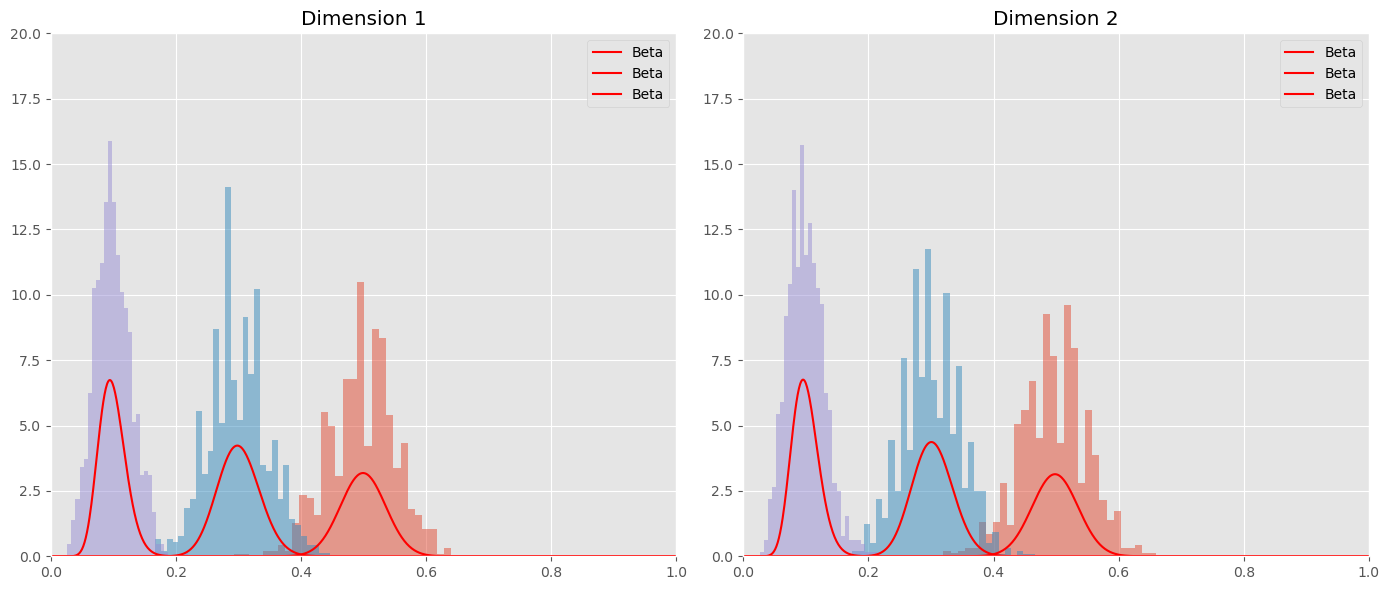

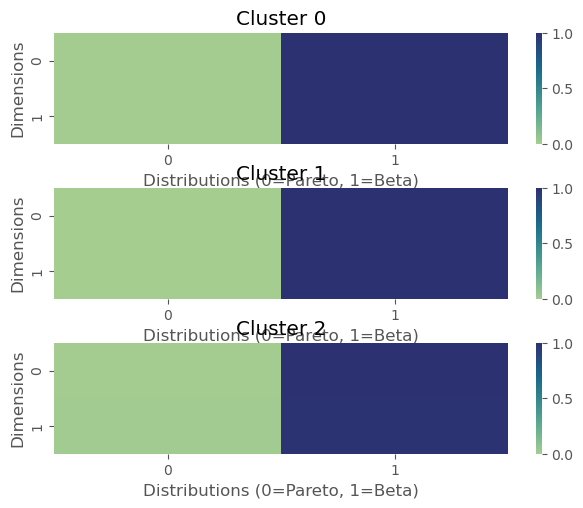

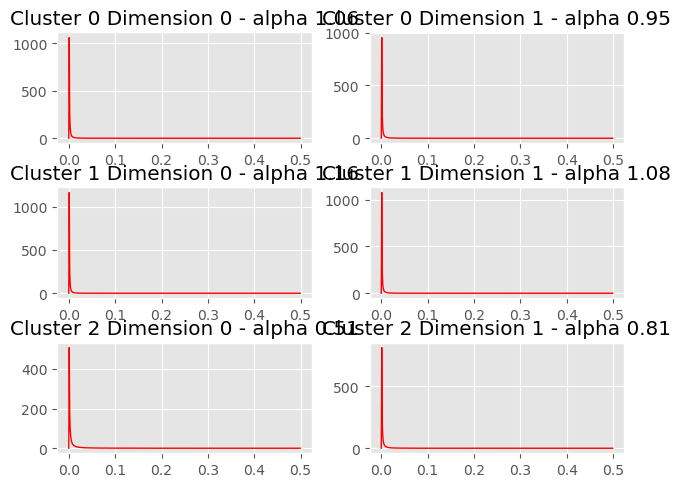

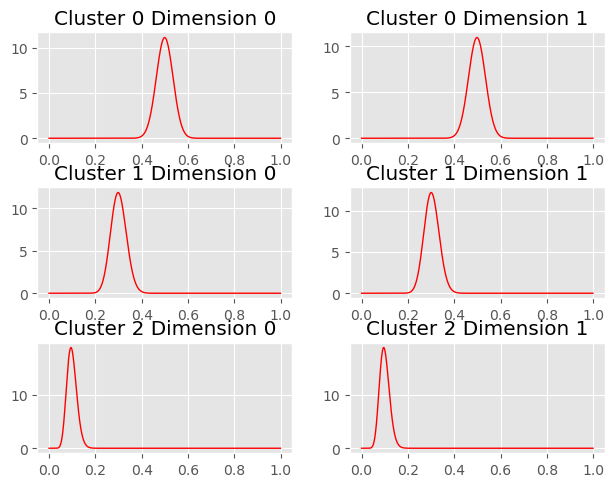

In [56]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

### With 3 beta components (1 private)

In [57]:
N1 = 1000
N2 = 800
N3 = 1000

NV1, DP1 = beta_binomial_component(phi_beta_x = 0.4, k_beta_x = 250, phi_beta_y = 0.0001, k_beta_y= 250, n=150, N=N1, seed=seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV3, DP3 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.3, k_beta_y= 250, n=150, N=N3, seed=seed)

NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP)

torch.Size([2800, 2])
torch.Size([2800, 2])


In [58]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

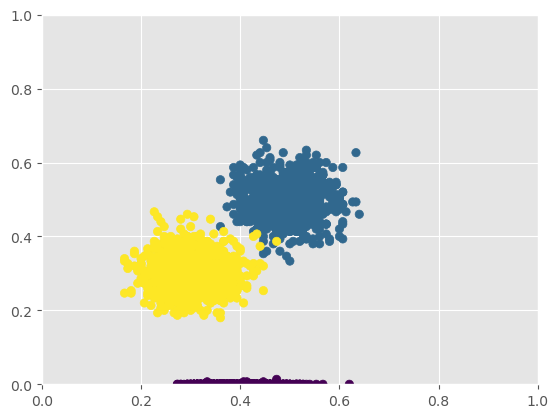

In [59]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

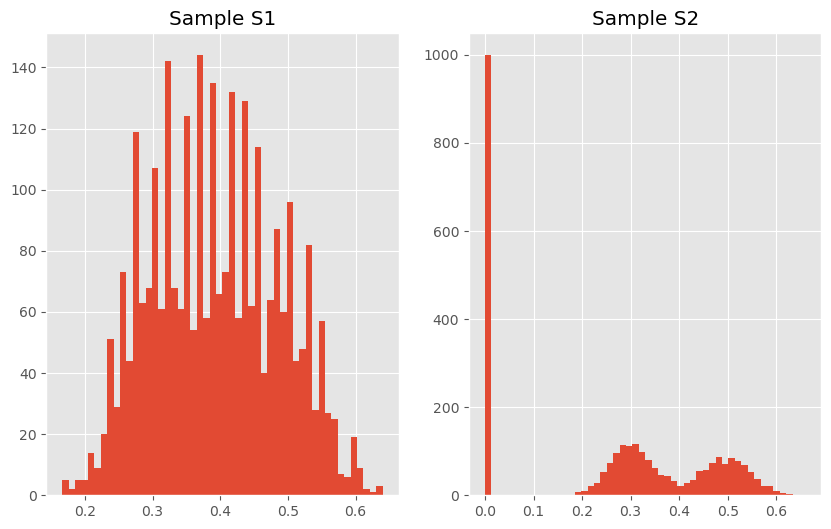

In [60]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

kmeans_centers:  tensor([[4.0035e-01, 3.9876e-05],
        [4.9931e-01, 4.9832e-01],
        [3.0027e-01, 3.0281e-01]])
Iteration 0: Loss = 64486392.0
weights_param tensor([0.3685, 0.3746, 0.2569], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0040, 2.0040],
        [2.0040, 2.0039],
        [2.0040, 2.0040]], grad_fn=<AddBackward0>)
alpha_pareto_param tensor([[1.9960, 1.9960],
        [1.9960, 1.9960],
        [1.9960, 1.9960]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[4.0018e-01, 3.9796e-05],
        [4.9929e-01, 4.9830e-01],
        [3.0050e-01, 3.0305e-01]], grad_fn=<AddBackward0>)
k_beta_param tensor([[100.2003,  99.8001],
        [100.2003, 100.2002],
        [100.2001, 100.2002]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.8904, 0.1096],
         [0.3560, 0.6440]],

        [[0.2733, 0.7267],
         [0.4858, 0.5142]],

        [[0.5250, 0.4750],
         [0.1265, 0.8735]]], grad_fn=<DivBackward0>)


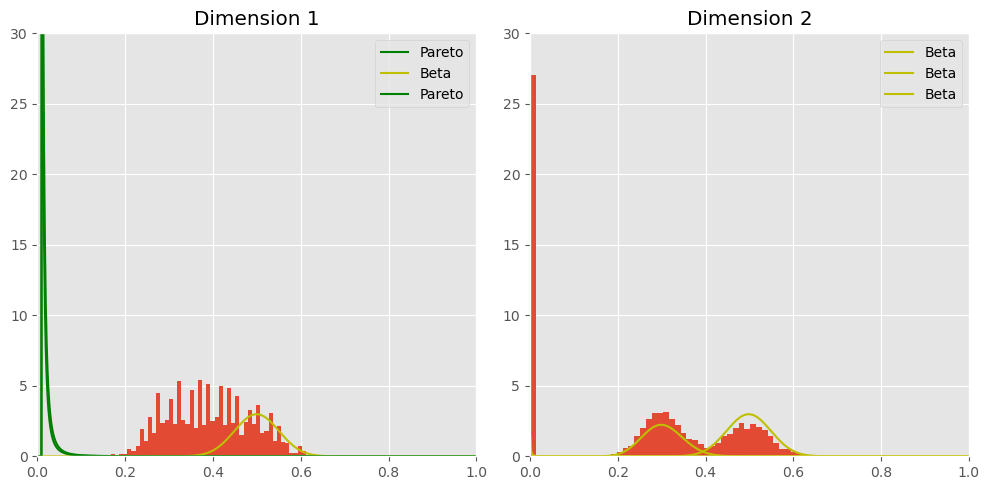

Iteration 200: Loss = 62095636.0
Iteration 400: Loss = 60043936.0
phi_beta [[3.9545560e-01 2.7345512e-05]
 [4.9603209e-01 4.9823460e-01]
 [3.0172852e-01 3.0315754e-01]]
delta [[[0.78615236 0.21384765]
  [0.21174839 0.7882516 ]]

 [[0.15875606 0.841244  ]
  [0.3181199  0.68188006]]

 [[0.34837884 0.65162116]
  [0.06874032 0.93125963]]]


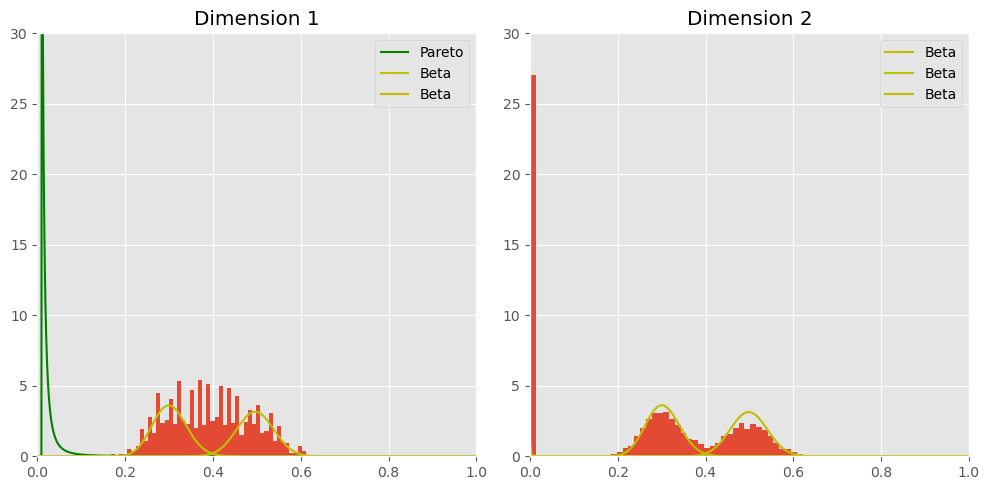

Iteration 600: Loss = 58257972.0
Iteration 800: Loss = 57215900.0
phi_beta [[3.9801350e-01 1.9577894e-05]
 [4.9625966e-01 4.9829397e-01]
 [3.0086207e-01 3.0298686e-01]]
delta [[[0.63323134 0.3667687 ]
  [0.13072503 0.869275  ]]

 [[0.10125149 0.8987486 ]
  [0.20582175 0.79417825]]

 [[0.22940758 0.77059245]
  [0.0418007  0.9581994 ]]]


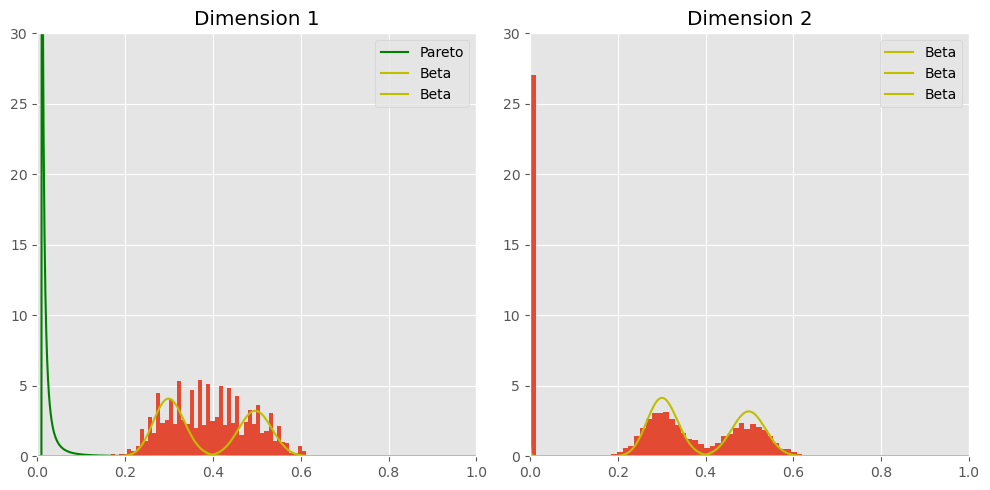

Iteration 1000: Loss = 56270348.0
Iteration 1200: Loss = 55483164.0
phi_beta [[3.98751438e-01 1.46098755e-05]
 [4.97643262e-01 4.98317003e-01]
 [3.00641298e-01 3.02931309e-01]]
delta [[[0.47164673 0.5283533 ]
  [0.08558823 0.9144118 ]]

 [[0.06903896 0.9309611 ]
  [0.1370029  0.8629971 ]]

 [[0.15577784 0.8442221 ]
  [0.0272989  0.9727011 ]]]


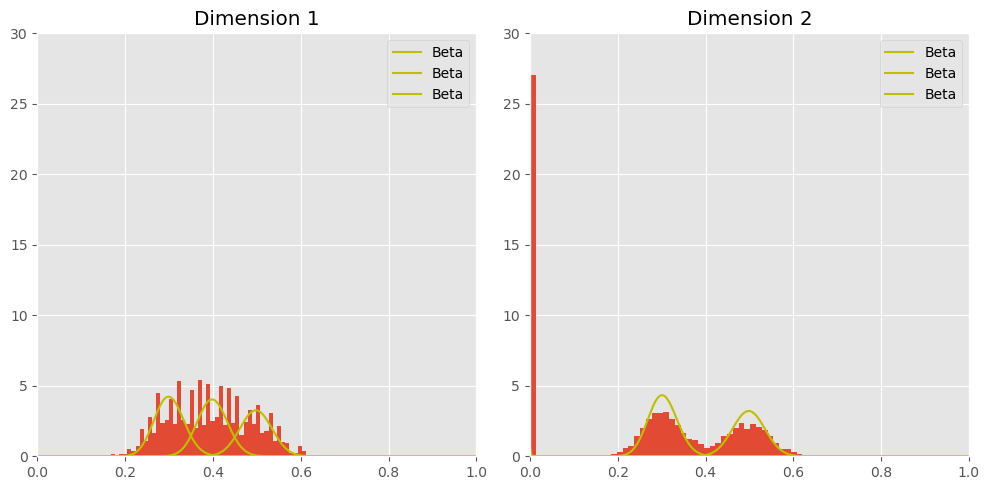

Iteration 1400: Loss = 54936712.0
Iteration 1600: Loss = 54522520.0
phi_beta [[3.9930227e-01 1.1285963e-05]
 [4.9845114e-01 4.9832508e-01]
 [3.0065832e-01 3.0292174e-01]]
delta [[[0.33900124 0.66099876]
  [0.05955606 0.940444  ]]

 [[0.04928767 0.95071226]
  [0.09502821 0.9049718 ]]

 [[0.10971146 0.8902886 ]
  [0.01877904 0.98122096]]]


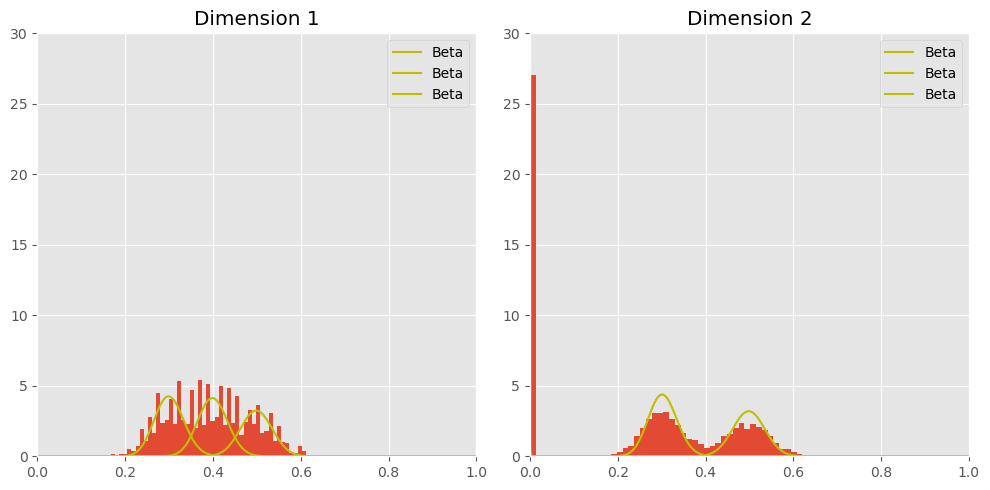

Iteration 1800: Loss = 54196888.0
Iteration 2000: Loss = 53920884.0
phi_beta [[3.9966094e-01 8.9617452e-06]
 [4.9881586e-01 4.9833024e-01]
 [3.0057460e-01 3.0292195e-01]]
delta [[[0.24348147 0.75651854]
  [0.04332324 0.9566768 ]]

 [[0.03638541 0.9636146 ]
  [0.06829882 0.9317012 ]]

 [[0.07982373 0.9201762 ]
  [0.01353541 0.9864646 ]]]


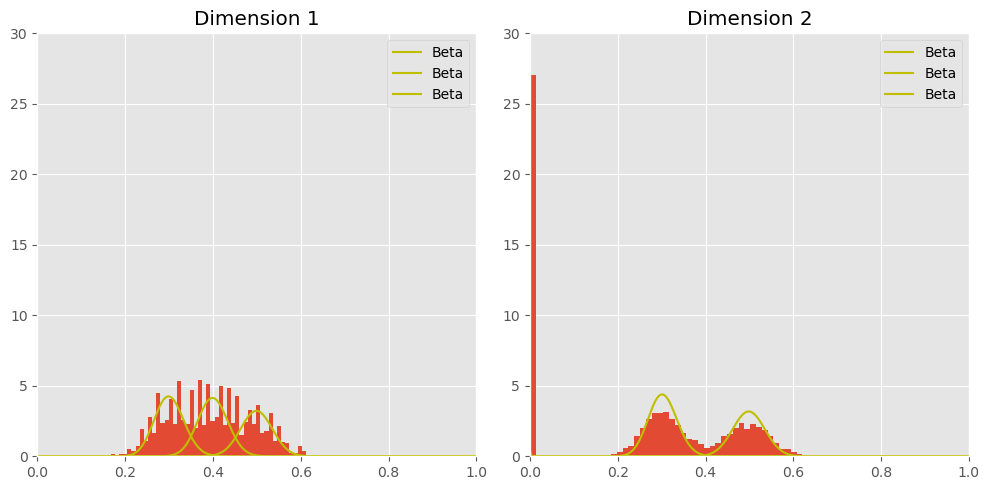

Iteration 2200: Loss = 53713060.0
Iteration 2400: Loss = 53542544.0
phi_beta [[3.9983043e-01 7.2707048e-06]
 [4.9894914e-01 4.9833176e-01]
 [3.0057284e-01 3.0292329e-01]]
delta [[[0.17762695 0.82237303]
  [0.03261253 0.9673875 ]]

 [[0.02753107 0.9724689 ]
  [0.05082608 0.94917387]]

 [[0.05962805 0.940372  ]
  [0.01010892 0.98989105]]]


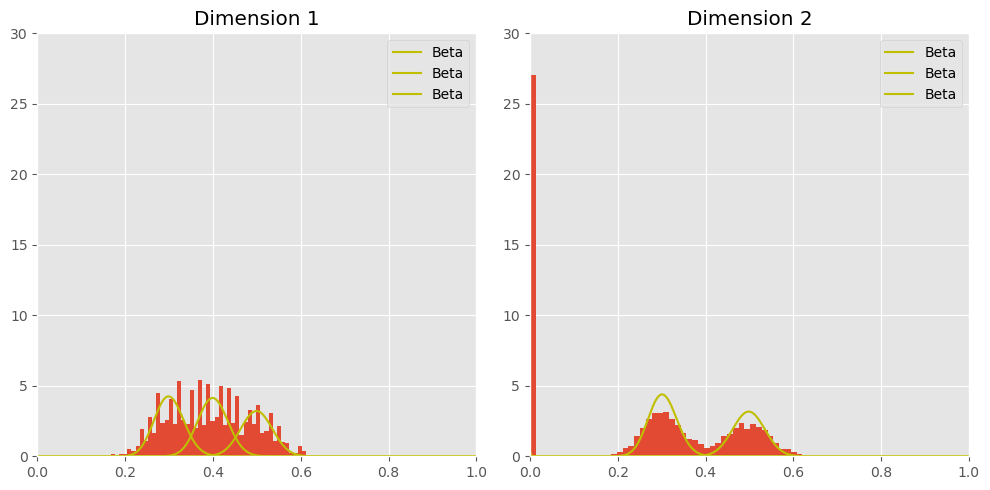

Iteration 2600: Loss = 53421612.0
Iteration 2800: Loss = 53324264.0
phi_beta [[3.9993349e-01 5.9982126e-06]
 [4.9900168e-01 4.9833012e-01]
 [3.0058125e-01 3.0292308e-01]]
delta [[[0.13212362 0.8678764 ]
  [0.02527677 0.9747233 ]]

 [[0.02122712 0.9787729 ]
  [0.03883276 0.9611672 ]]

 [[0.04555175 0.9544482 ]
  [0.00774394 0.99225605]]]


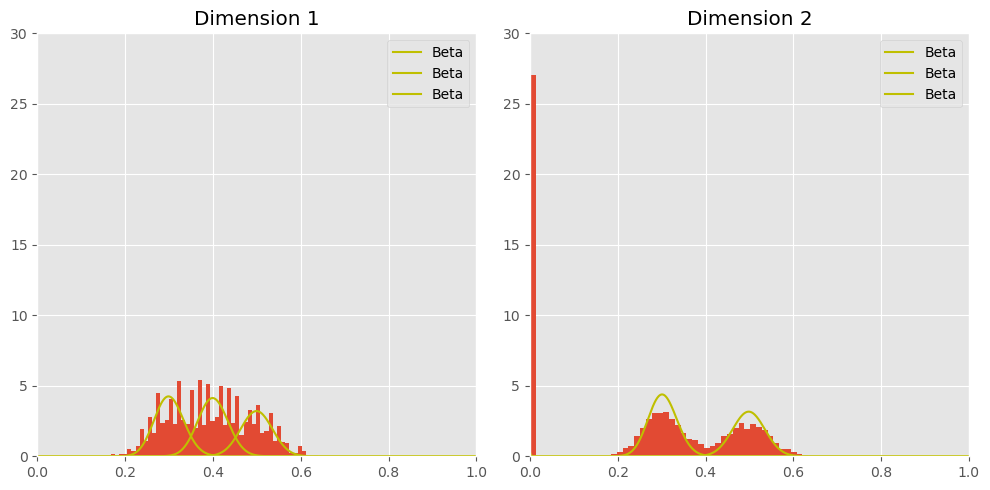

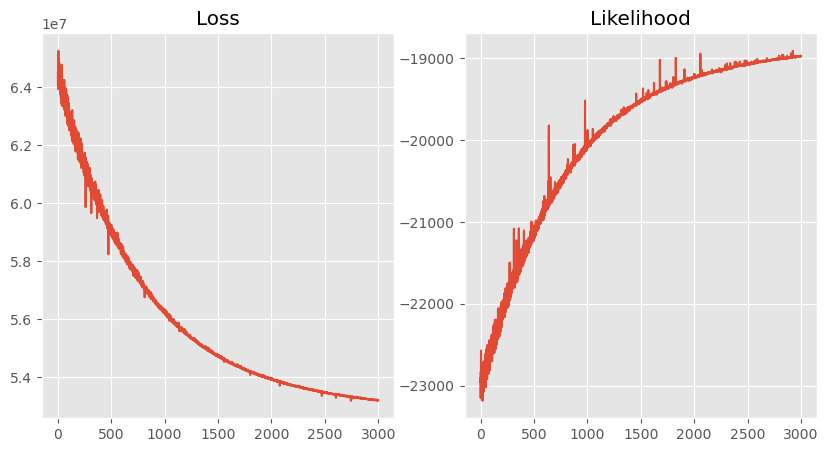

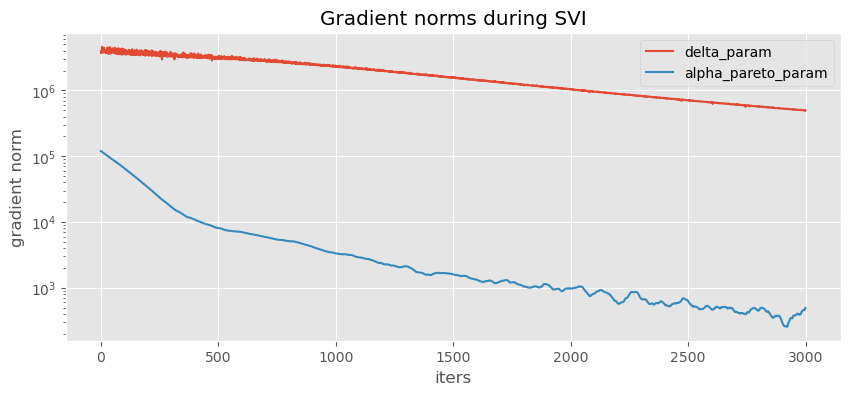

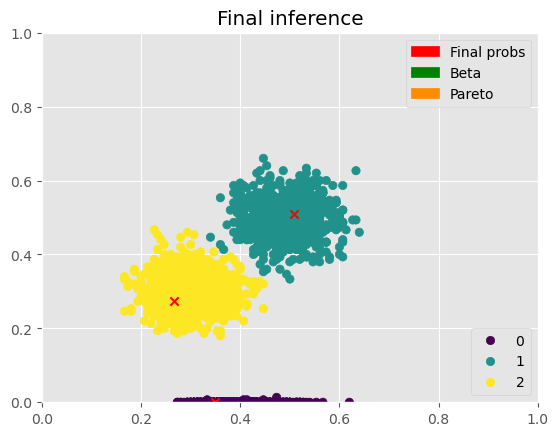

In [61]:
mb = mobster_MV(NV, DP, K = 3, seed = 48)
mb.fit(num_iter = 3000, lr = 0.001)

In [62]:
mb.params

{'weights_param': tensor([0.3546, 0.2890, 0.3564], grad_fn=<DivBackward0>),
 'alpha_prior_param': tensor([[2.5105, 6.2038],
         [2.3145, 4.2392],
         [1.8891, 3.8599]], grad_fn=<AddBackward0>),
 'alpha_pareto_param': tensor([[1.6136, 2.5141],
         [1.5323, 2.1356],
         [1.3301, 2.0414]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[3.9999e-01, 5.4827e-06],
         [4.9902e-01, 4.9833e-01],
         [3.0054e-01, 3.0292e-01]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[205.1708,  99.1211],
         [193.5093, 188.6357],
         [187.3332, 200.8703]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.1148, 0.8852],
          [0.0225, 0.9775]],
 
         [[0.0188, 0.9812],
          [0.0342, 0.9658]],
 
         [[0.0400, 0.9600],
          [0.0068, 0.9932]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.6

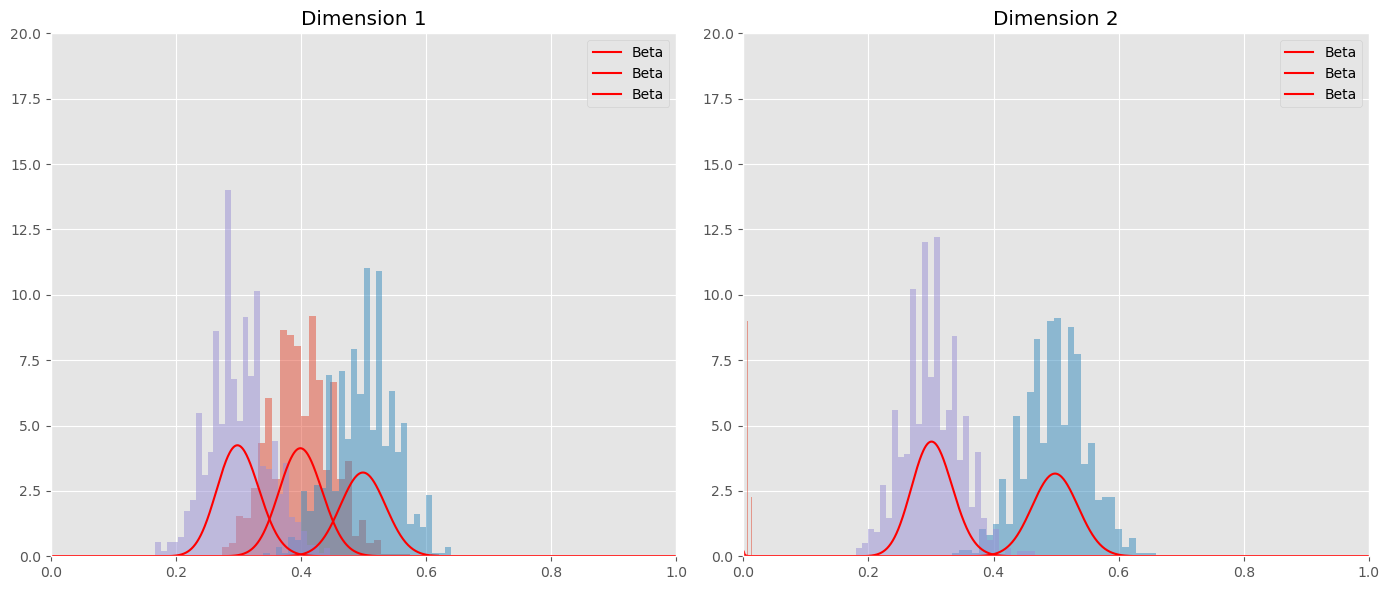

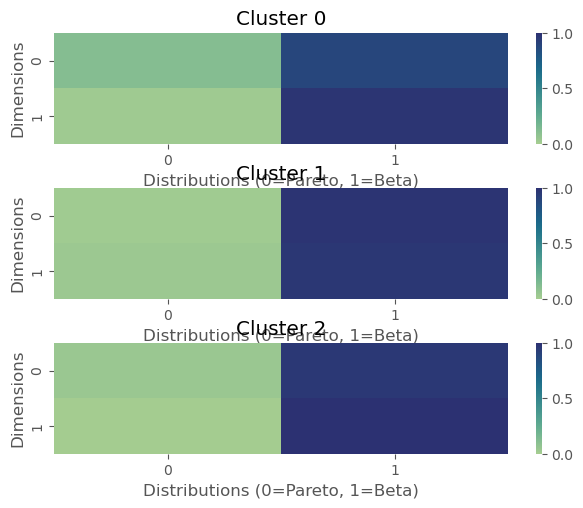

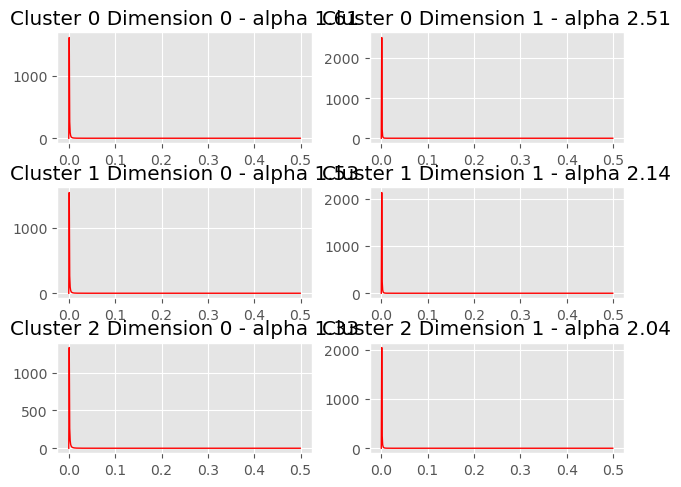

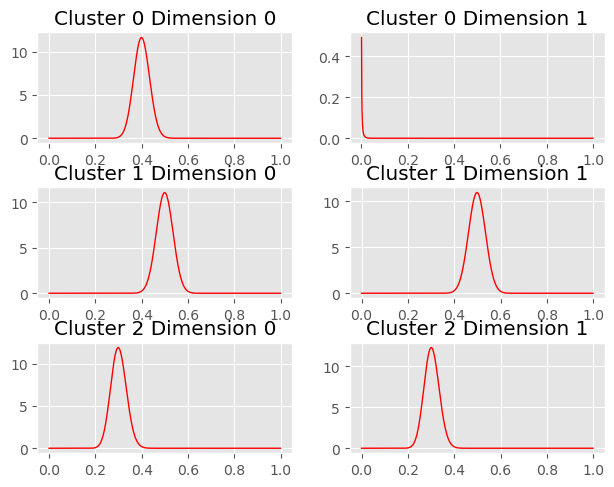

In [63]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

### rRACES data

In [64]:
NV_r = pd.read_csv("../rRACES_data/NV2.csv")
DP_r = pd.read_csv("../rRACES_data/DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([593, 2])
torch.Size([593, 2])


In [65]:
DP_r

S1  S2
0    79  85
1    85  85
2    86  64
3    82  76
4    96  78
..   ..  ..
588  82  81
589  78  69
590  94  83
591  96  85
592  89  71

[593 rows x 2 columns]

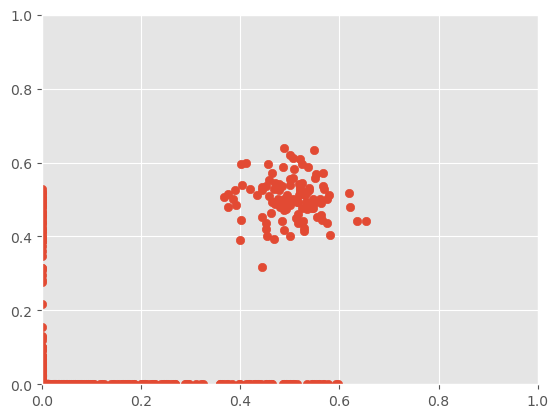

In [66]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

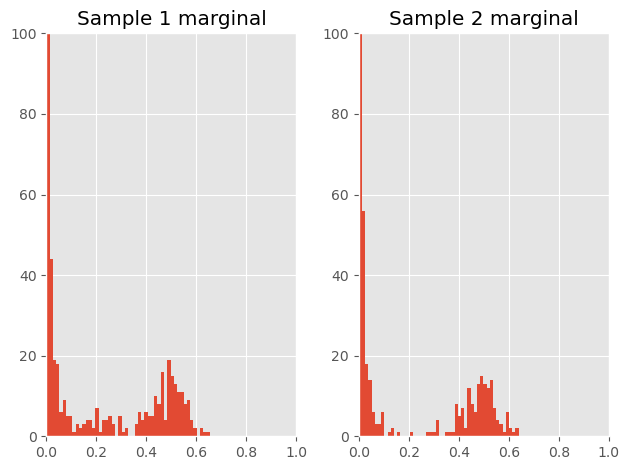

In [67]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


kmeans_centers:  tensor([[2.1703e-01, 1.0000e-03],
        [4.9993e-01, 5.0346e-01],
        [2.9802e-08, 4.2671e-01],
        [4.6957e-01, 1.0000e-03],
        [1.4685e-02, 1.4474e-02]])


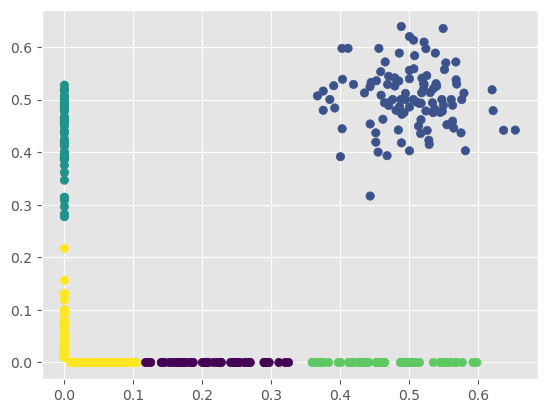

In [68]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


kmeans_centers:  tensor([[2.1703e-01, 1.0000e-03],
        [4.9993e-01, 5.0346e-01],
        [2.9802e-08, 4.2671e-01],
        [4.6957e-01, 1.0000e-03],
        [1.4685e-02, 1.4474e-02]])
Iteration 0: Loss = 2052438.75
weights_param tensor([0.1762, 0.2387, 0.0276, 0.2592, 0.2983], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0201, 2.0200],
        [2.0201, 2.0200],
        [2.0200, 2.0201],
        [2.0199, 2.0201],
        [2.0201, 2.0198]], grad_fn=<AddBackward0>)
alpha_pareto_param tensor([[1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[2.1579e-01, 9.9011e-04],
        [4.9983e-01, 5.0340e-01],
        [2.9506e-08, 4.2601e-01],
        [4.6920e-01, 9.9021e-04],
        [1.4553e-02, 1.4574e-02]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 99.0201,  99.0354],
        [101.0039, 101.0047],
        [ 99.8721,  99.0246],
        [100.3460,  99.0536],
    

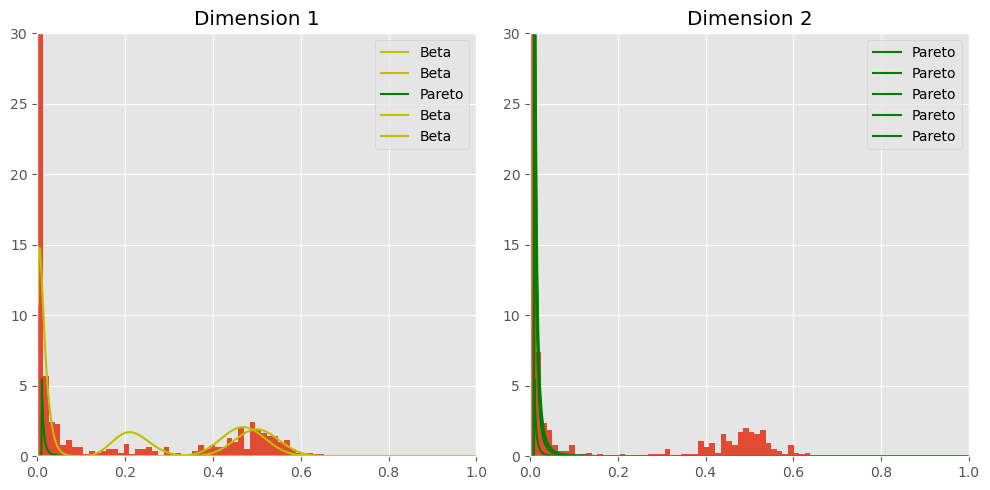

Iteration 200: Loss = 1725019.625
Iteration 400: Loss = 1662162.375
phi_beta [[1.6587318e-01 2.0173767e-04]
 [4.9836141e-01 5.0235790e-01]
 [6.4182308e-09 4.2175850e-01]
 [4.2028442e-01 2.2525479e-04]
 [3.0784763e-03 3.8562026e-02]]
delta [[[0.5415691  0.45843083]
  [0.11037397 0.8896261 ]]

 [[0.02301045 0.9769895 ]
  [0.43319663 0.56680334]]

 [[0.10051028 0.89948976]
  [0.24524242 0.7547576 ]]

 [[0.6780709  0.32192907]
  [0.07753216 0.9224678 ]]

 [[0.003191   0.99680895]
  [0.46524653 0.53475344]]]


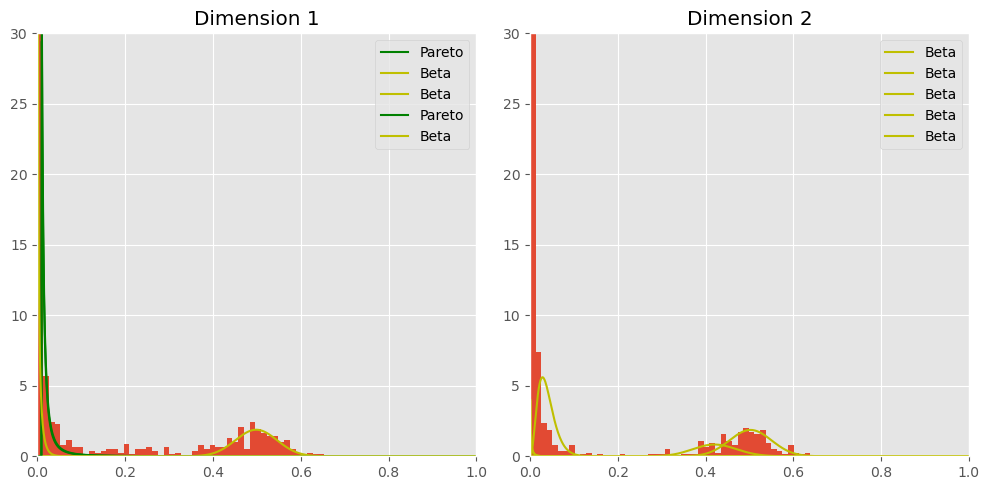

Iteration 600: Loss = 1650136.5
Iteration 800: Loss = 1631709.125
phi_beta [[1.7018269e-01 8.1466402e-05]
 [4.9909058e-01 5.0246102e-01]
 [2.7000264e-09 4.2239076e-01]
 [4.5030221e-01 8.9005553e-05]
 [1.2856168e-03 4.0563598e-02]]
delta [[[0.5453368  0.45466325]
  [0.03459384 0.9654061 ]]

 [[0.00671521 0.9932848 ]
  [0.1655579  0.8344421 ]]

 [[0.03327983 0.96672016]
  [0.30893672 0.6910633 ]]

 [[0.5930642  0.40693578]
  [0.02491436 0.9750856 ]]

 [[0.00108654 0.9989134 ]
  [0.45448977 0.54551023]]]


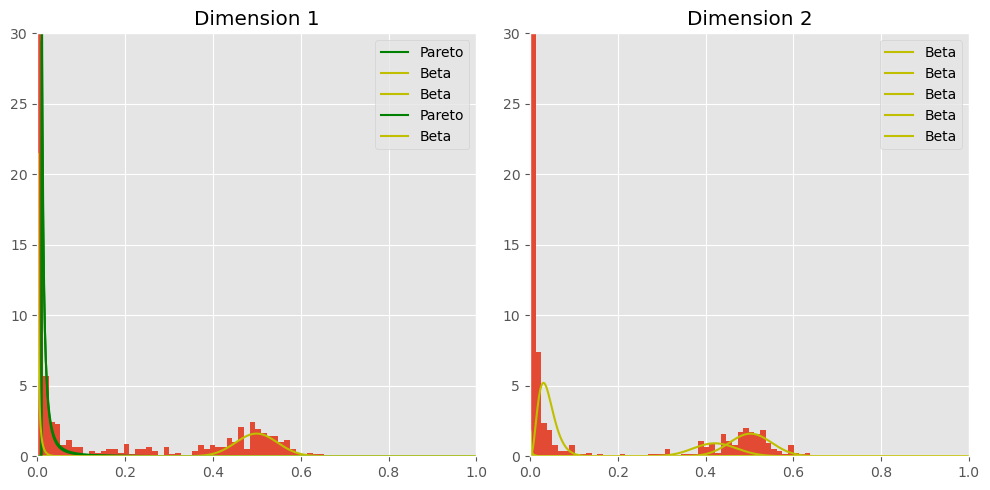

Iteration 1000: Loss = 1620759.875
Iteration 1200: Loss = 1615764.875
phi_beta [[1.6475660e-01 4.4252636e-05]
 [4.9924555e-01 5.0247937e-01]
 [1.5511514e-09 4.2239180e-01]
 [4.5325345e-01 4.6972353e-05]
 [7.2993053e-04 3.9551642e-02]]
delta [[[5.1876187e-01 4.8123816e-01]
  [1.7173029e-02 9.8282695e-01]]

 [[3.2880737e-03 9.9671197e-01]
  [8.2974449e-02 9.1702557e-01]]

 [[1.6718162e-02 9.8328179e-01]
  [3.5316885e-01 6.4683115e-01]]

 [[5.8304256e-01 4.1695738e-01]
  [1.2007379e-02 9.8799264e-01]]

 [[5.7169911e-04 9.9942821e-01]
  [3.9691585e-01 6.0308409e-01]]]


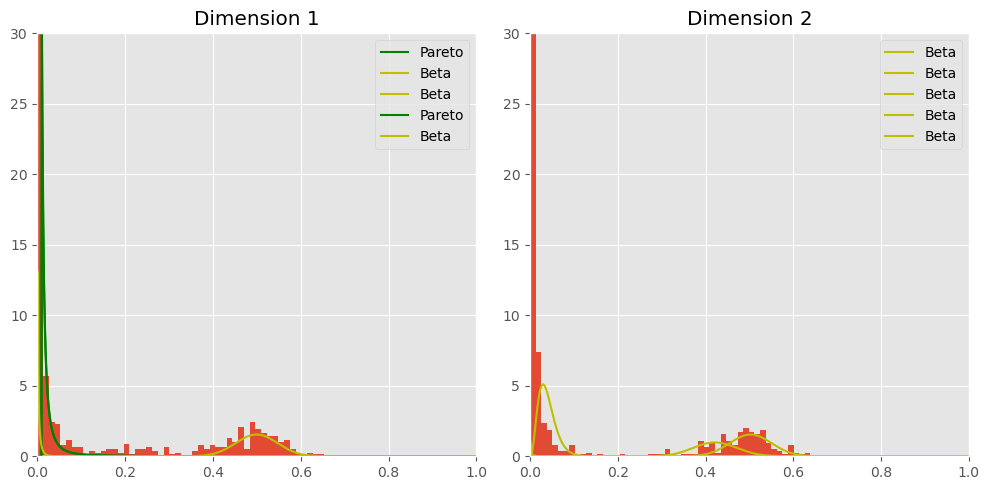

Iteration 1400: Loss = 1626718.25
Iteration 1600: Loss = 1618198.625
phi_beta [[1.6967909e-01 2.7577271e-05]
 [4.9930710e-01 5.0248897e-01]
 [8.6600932e-10 4.2238560e-01]
 [4.5534524e-01 2.8565199e-05]
 [4.7036071e-04 3.8316462e-02]]
delta [[[5.6987154e-01 4.3012851e-01]
  [1.0231773e-02 9.8976821e-01]]

 [[1.9448227e-03 9.9805522e-01]
  [4.9408369e-02 9.5059162e-01]]

 [[9.8240376e-03 9.9017590e-01]
  [4.1164964e-01 5.8835036e-01]]

 [[5.4397488e-01 4.5602512e-01]
  [7.1057682e-03 9.9289423e-01]]

 [[3.5341785e-04 9.9964654e-01]
  [3.1249774e-01 6.8750226e-01]]]


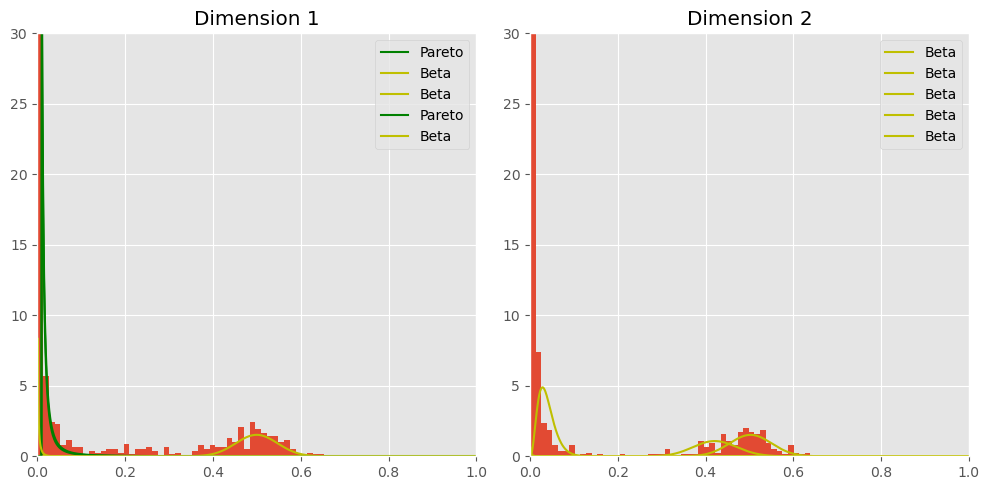

Iteration 1800: Loss = 1629134.5
Iteration 2000: Loss = 1618255.5
phi_beta [[1.6665868e-01 1.8831335e-05]
 [4.9933663e-01 5.0249606e-01]
 [6.4402761e-10 4.2245498e-01]
 [4.5488289e-01 1.9021061e-05]
 [3.3444542e-04 3.9627697e-02]]
delta [[[5.2830690e-01 4.7169313e-01]
  [6.8259425e-03 9.9317402e-01]]

 [[1.2774130e-03 9.9872261e-01]
  [3.2409456e-02 9.6759051e-01]]

 [[6.4383955e-03 9.9356163e-01]
  [4.5466873e-01 5.4533130e-01]]

 [[5.8037508e-01 4.1962487e-01]
  [4.6619354e-03 9.9533808e-01]]

 [[2.4242878e-04 9.9975759e-01]
  [3.1420749e-01 6.8579251e-01]]]


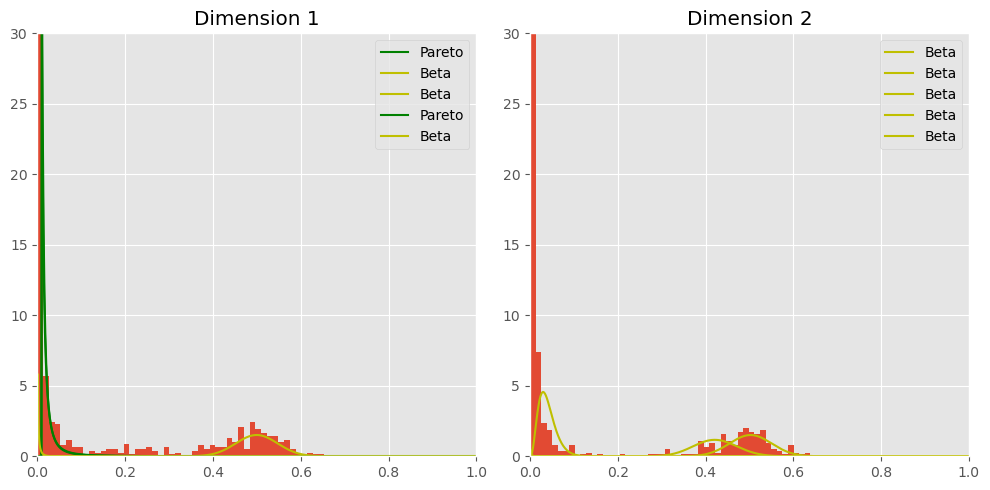

Iteration 2200: Loss = 1633722.75
Iteration 2400: Loss = 1609277.625
phi_beta [[1.60778880e-01 1.33919712e-05]
 [4.99351323e-01 5.02497613e-01]
 [5.90614335e-10 4.24906135e-01]
 [4.54169363e-01 1.34475895e-05]
 [2.40783978e-04 3.90575379e-02]]
delta [[[4.9587268e-01 5.0412732e-01]
  [4.7544711e-03 9.9524552e-01]]

 [[8.8857498e-04 9.9911135e-01]
  [2.2638351e-02 9.7736162e-01]]

 [[4.4067441e-03 9.9559325e-01]
  [4.6494344e-01 5.3505653e-01]]

 [[5.8604640e-01 4.1395360e-01]
  [3.2501193e-03 9.9674988e-01]]

 [[1.7032312e-04 9.9982965e-01]
  [2.9763252e-01 7.0236748e-01]]]


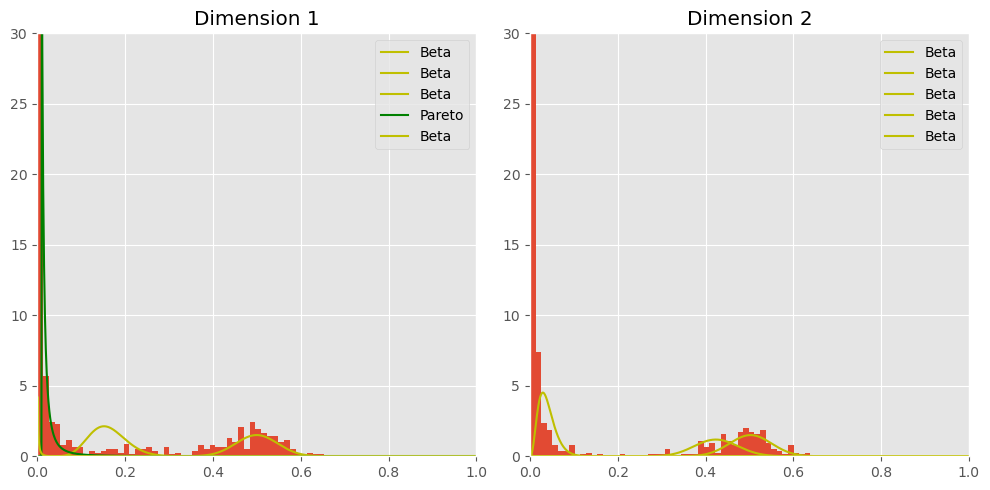

Iteration 2600: Loss = 1607172.5
Iteration 2800: Loss = 1622455.25
phi_beta [[1.6821870e-01 9.7334350e-06]
 [4.9935681e-01 5.0249970e-01]
 [5.1170473e-10 4.2244378e-01]
 [4.5623475e-01 9.9102826e-06]
 [1.7736857e-04 3.8312320e-02]]
delta [[[5.7033485e-01 4.2966521e-01]
  [3.4229546e-03 9.9657708e-01]]

 [[6.4314780e-04 9.9935681e-01]
  [1.6459303e-02 9.8354071e-01]]

 [[3.2009783e-03 9.9679899e-01]
  [4.1292140e-01 5.8707863e-01]]

 [[5.3530782e-01 4.6469218e-01]
  [2.3771035e-03 9.9762291e-01]]

 [[1.2374182e-04 9.9987626e-01]
  [3.1583443e-01 6.8416560e-01]]]


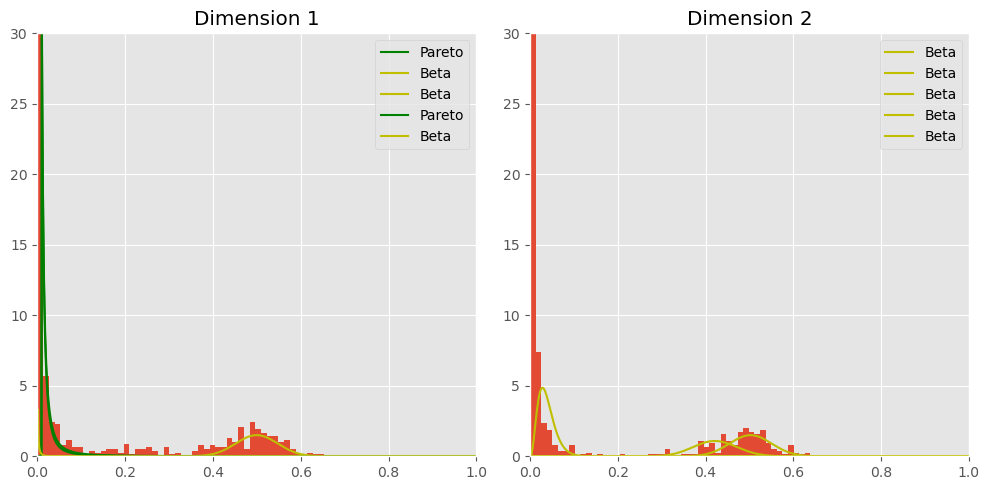

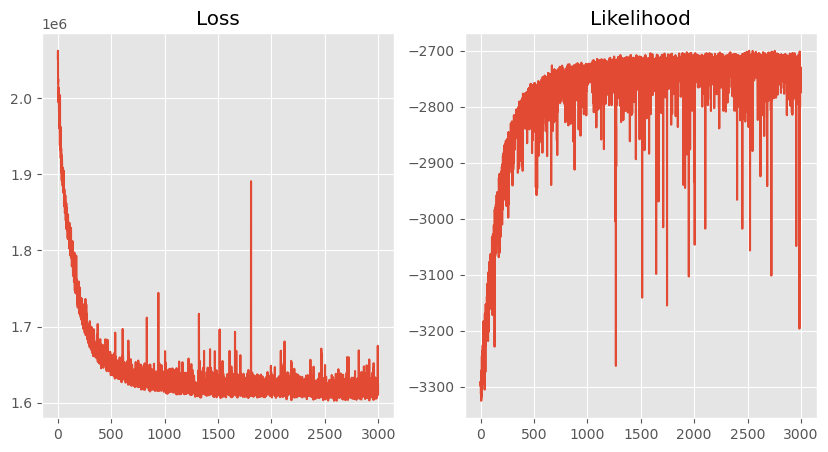

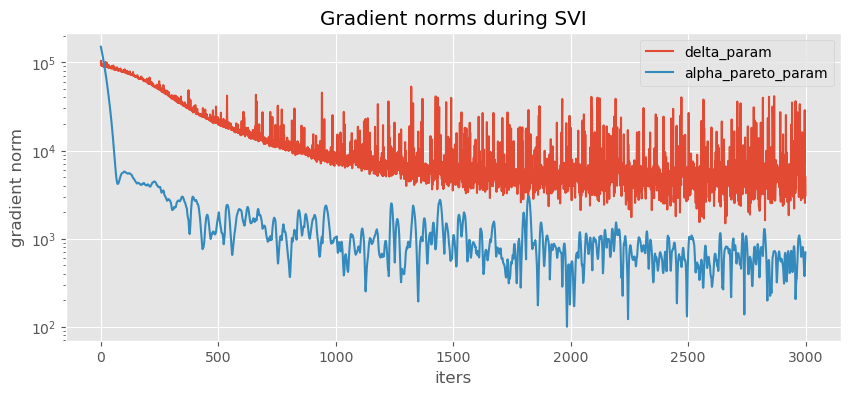

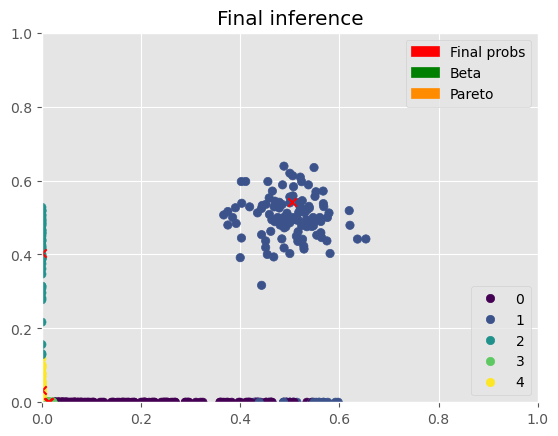

In [69]:
mb = mobster_MV(NV, DP, K = 5, seed = 123)
mb.fit(num_iter = 3000, lr = 0.005)

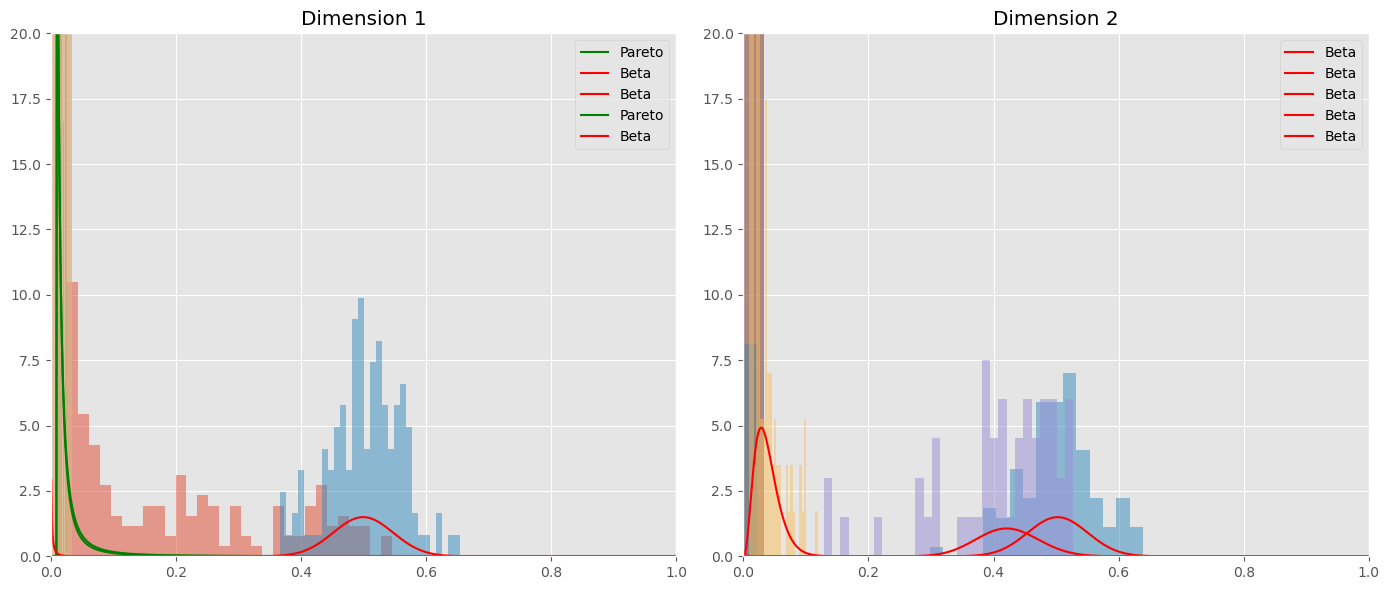

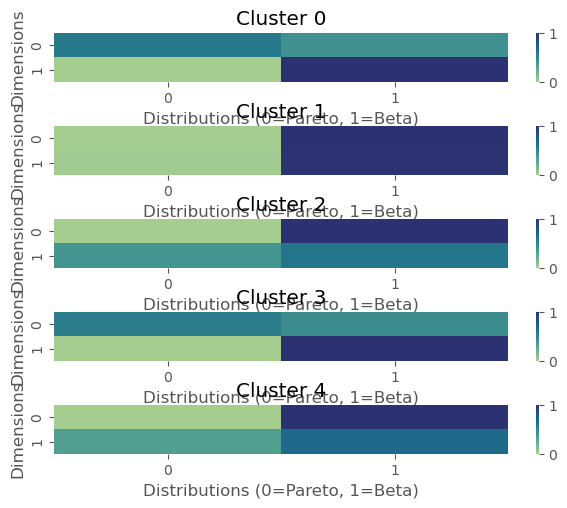

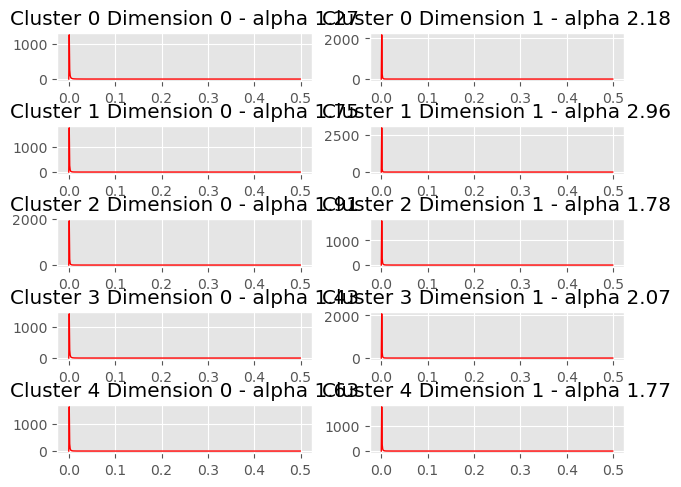

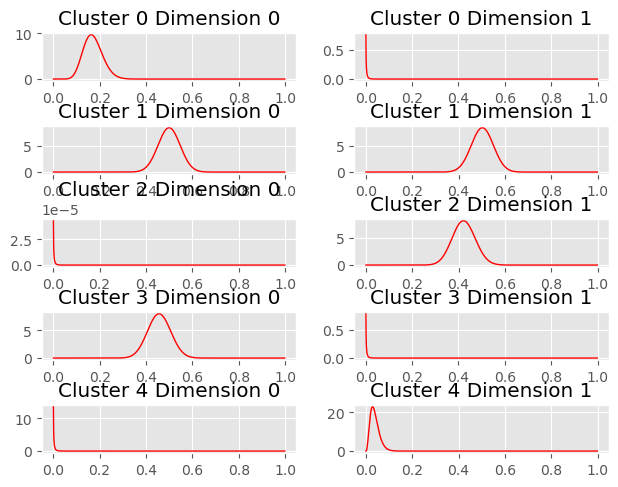

In [70]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [71]:
mb.params

{'weights_param': tensor([0.2439, 0.1781, 0.1321, 0.2303, 0.2156], grad_fn=<DivBackward0>),
 'alpha_prior_param': tensor([[1.7993, 4.4035],
         [2.8760, 9.6745],
         [3.3874, 2.9877],
         [2.0789, 3.9556],
         [2.5427, 2.9250]], grad_fn=<AddBackward0>),
 'alpha_pareto_param': tensor([[1.2695, 2.1755],
         [1.7495, 2.9626],
         [1.9132, 1.7842],
         [1.4328, 2.0682],
         [1.6264, 1.7656]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[1.7125e-01, 8.4120e-06],
         [4.9936e-01, 5.0250e-01],
         [4.7366e-10, 4.2254e-01],
         [4.5665e-01, 8.5901e-06],
         [1.5404e-04, 3.8438e-02]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[ 82.1229, 100.0068],
         [111.6901, 111.2679],
         [ 99.9597,  99.7092],
         [100.0548,  99.9948],
         [ 99.7566,  96.9762]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[5.7437e-01, 4.2563e-01],
          [2.9469e-03, 9.9705e-01]],
 
         [[5.5350e-04, 9.9945e-01],
 

### rRACES longitudinal data

In [72]:
NV_r = pd.read_csv("../rRACES_data/NV_long.csv")
DP_r = pd.read_csv("../rRACES_data/DP_long.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([1224, 2])
torch.Size([1224, 2])


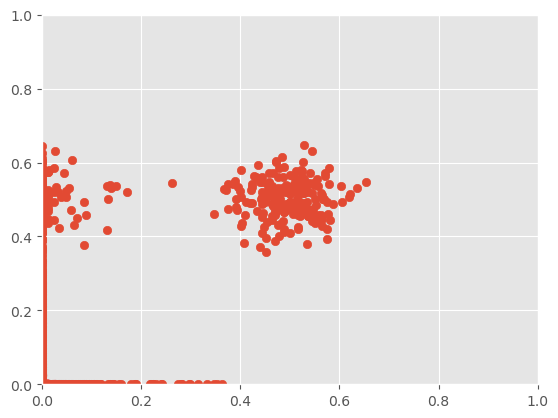

In [73]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

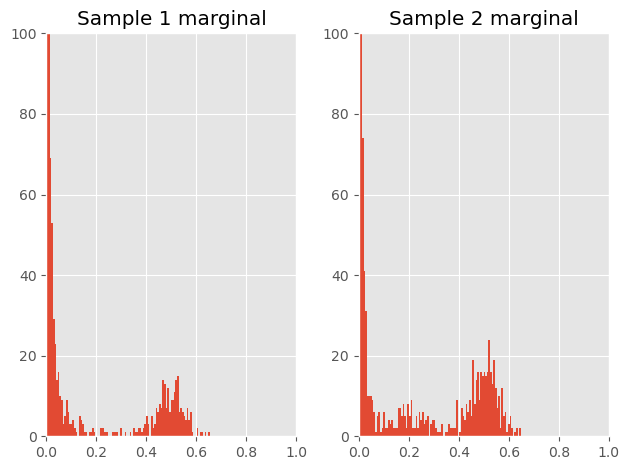

In [74]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 100)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 100)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[1.4442e-02, 1.1785e-02],
        [4.9358e-01, 5.0280e-01],
        [1.6109e-02, 4.9525e-01],
        [2.2913e-01, 1.0000e-03],
        [2.2352e-08, 2.1557e-01]])


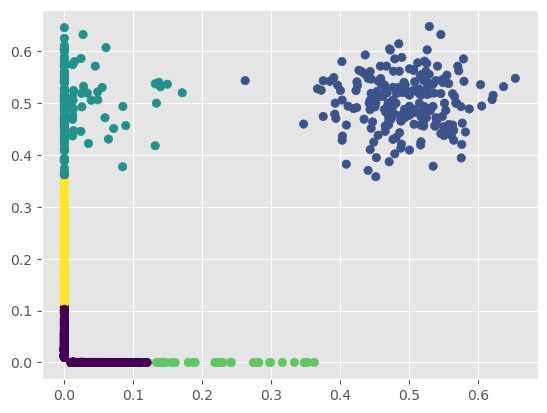

In [75]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

kmeans_centers:  tensor([[2.2878e-02, 1.1322e-02],
        [4.4452e-01, 4.9081e-01],
        [1.6109e-02, 4.9525e-01],
        [5.3156e-01, 5.1208e-01],
        [2.2352e-08, 2.1557e-01]])
Iteration 0: Loss = 8967012.0
weights_param tensor([0.3180, 0.1125, 0.2514, 0.0573, 0.2607], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0198, 2.0201],
        [2.0201, 2.0200],
        [2.0201, 2.0184],
        [2.0201, 2.0201],
        [2.0200, 2.0201]], grad_fn=<AddBackward0>)
alpha_pareto_param tensor([[1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[2.3092e-02, 1.1212e-02],
        [4.4509e-01, 4.9099e-01],
        [1.6151e-02, 4.9539e-01],
        [5.1000e-01, 5.1000e-01],
        [2.2130e-08, 2.1503e-01]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 99.0092,  99.0044],
        [ 99.0875, 101.0049],
        [ 99.0278, 101.0050],
        [ 99.1207, 101.0039],
     

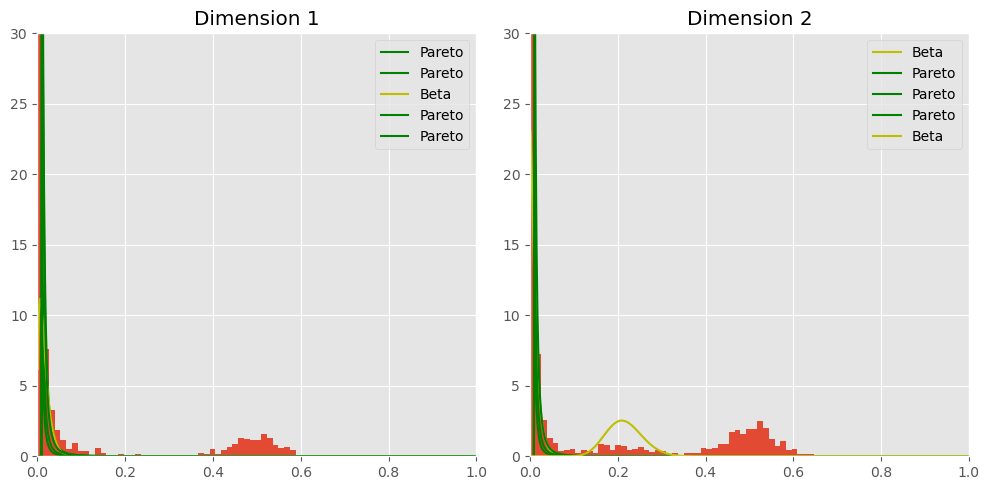

Iteration 200: Loss = 7367848.0
Iteration 400: Loss = 7093653.5
phi_beta [[6.7874961e-02 2.7804733e-03]
 [4.8511961e-01 5.0193185e-01]
 [5.5070110e-03 4.8176226e-01]
 [5.0999981e-01 5.0999981e-01]
 [4.6033888e-09 1.9299033e-01]]
delta [[[0.6244683  0.37553167]
  [0.00233197 0.99766797]]

 [[0.48913443 0.51086557]
  [0.1630784  0.8369216 ]]

 [[0.02921905 0.970781  ]
  [0.74199736 0.25800267]]

 [[0.89440763 0.1055924 ]
  [0.95995414 0.04004589]]

 [[0.08574964 0.9142503 ]
  [0.45320764 0.5467924 ]]]


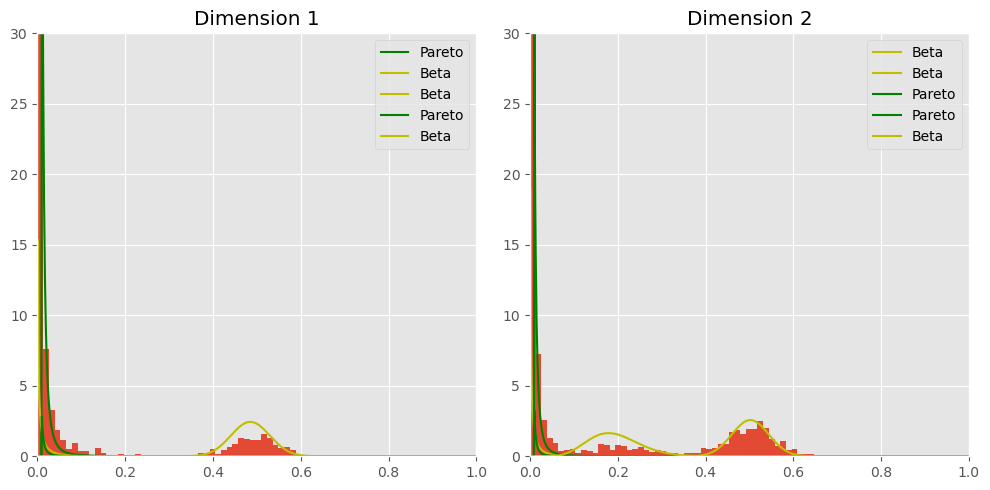

Iteration 600: Loss = 6977816.5
Iteration 800: Loss = 6969621.5
phi_beta [[8.5473761e-02 1.3116422e-03]
 [4.9118680e-01 5.0332284e-01]
 [4.9608336e-03 4.8812842e-01]
 [5.0999981e-01 5.0999981e-01]
 [1.8969286e-09 1.9270988e-01]]
delta [[[6.8488902e-01 3.1511098e-01]
  [8.0785534e-04 9.9919218e-01]]

 [[2.2393009e-01 7.7606994e-01]
  [5.2004963e-02 9.4799501e-01]]

 [[1.2238629e-02 9.8776138e-01]
  [5.3691167e-01 4.6308833e-01]]

 [[9.4435924e-01 5.5640824e-02]
  [9.5957190e-01 4.0428158e-02]]

 [[2.7635580e-02 9.7236437e-01]
  [5.4262263e-01 4.5737734e-01]]]


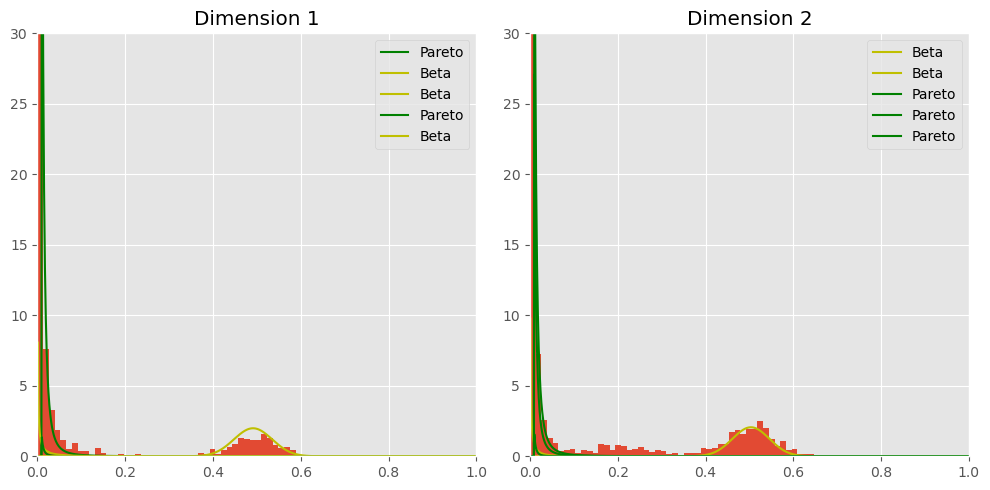

Iteration 1000: Loss = 6915895.5
Iteration 1200: Loss = 6870977.0
phi_beta [[8.4605128e-02 6.7317713e-04]
 [4.9293521e-01 5.0336599e-01]
 [7.5446828e-03 4.9261066e-01]
 [5.0999981e-01 5.0999987e-01]
 [9.1333707e-10 1.9146033e-01]]
delta [[[6.6559833e-01 3.3440167e-01]
  [4.0750613e-04 9.9959248e-01]]

 [[1.4292161e-01 8.5707831e-01]
  [2.4810720e-02 9.7518921e-01]]

 [[8.3184130e-03 9.9168164e-01]
  [3.6147386e-01 6.3852614e-01]]

 [[9.5968682e-01 4.0313169e-02]
  [9.5829272e-01 4.1707300e-02]]

 [[1.3511591e-02 9.8648840e-01]
  [5.8131522e-01 4.1868478e-01]]]


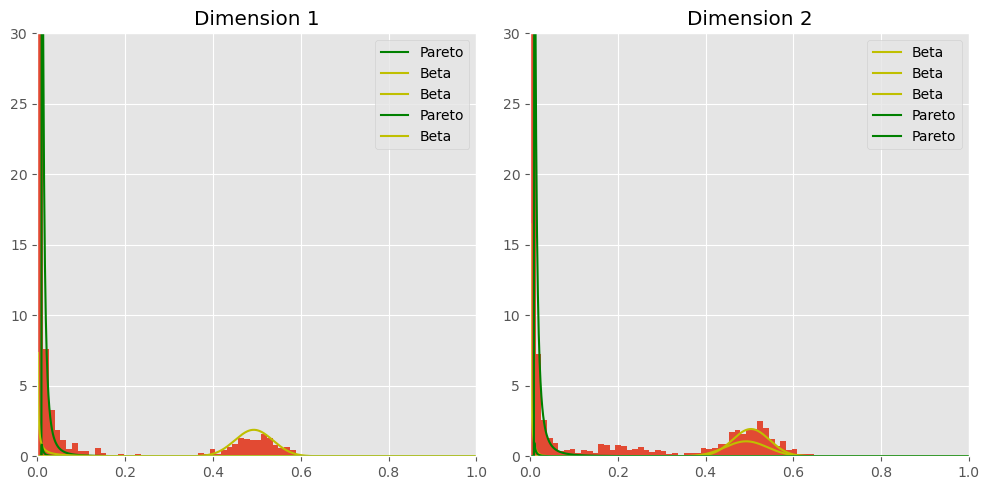

Iteration 1400: Loss = 6859766.0
Iteration 1600: Loss = 6844242.0
phi_beta [[8.7499917e-02 3.8260466e-04]
 [4.9355578e-01 5.0313199e-01]
 [1.1439329e-02 4.9598333e-01]
 [5.0999981e-01 5.0999993e-01]
 [6.6497208e-10 1.9262776e-01]]
delta [[[6.7460960e-01 3.2539040e-01]
  [2.4624975e-04 9.9975377e-01]]

 [[1.0387897e-01 8.9612103e-01]
  [1.4515499e-02 9.8548454e-01]]

 [[6.5355799e-03 9.9346441e-01]
  [2.2257972e-01 7.7742028e-01]]

 [[9.6736813e-01 3.2631941e-02]
  [9.5720142e-01 4.2798519e-02]]

 [[7.7991076e-03 9.9220091e-01]
  [5.9957218e-01 4.0042785e-01]]]


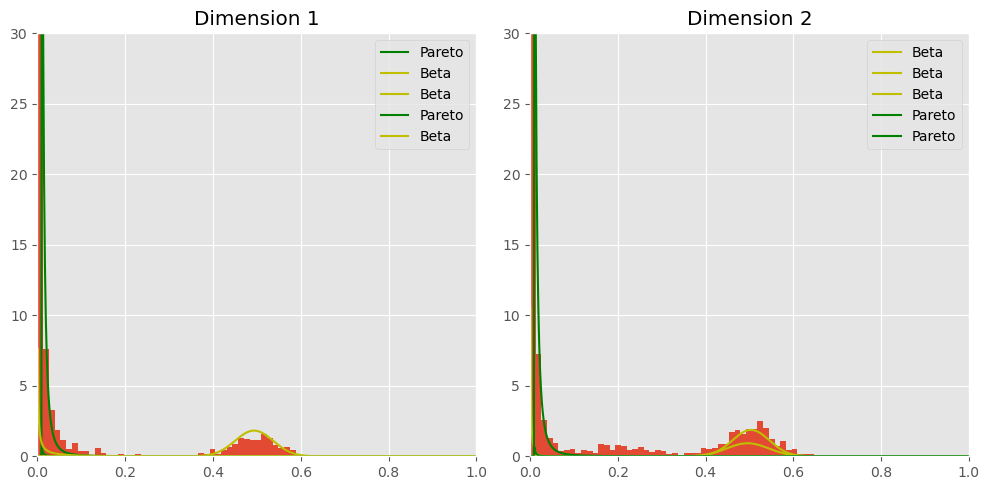

Iteration 1800: Loss = 6888061.5
Iteration 2000: Loss = 6919964.0
phi_beta [[8.6076871e-02 2.4627120e-04]
 [4.9382827e-01 5.0295097e-01]
 [1.4891044e-02 4.9874952e-01]
 [5.0999975e-01 5.0999993e-01]
 [6.7721240e-10 1.9155018e-01]]
delta [[[6.7292655e-01 3.2707343e-01]
  [1.6345084e-04 9.9983656e-01]]

 [[7.9843216e-02 9.2015684e-01]
  [9.4635878e-03 9.9053639e-01]]

 [[5.1627695e-03 9.9483722e-01]
  [1.0727133e-01 8.9272869e-01]]

 [[9.7216642e-01 2.7833581e-02]
  [9.5630294e-01 4.3697026e-02]]

 [[5.0330632e-03 9.9496692e-01]
  [6.0154122e-01 3.9845881e-01]]]


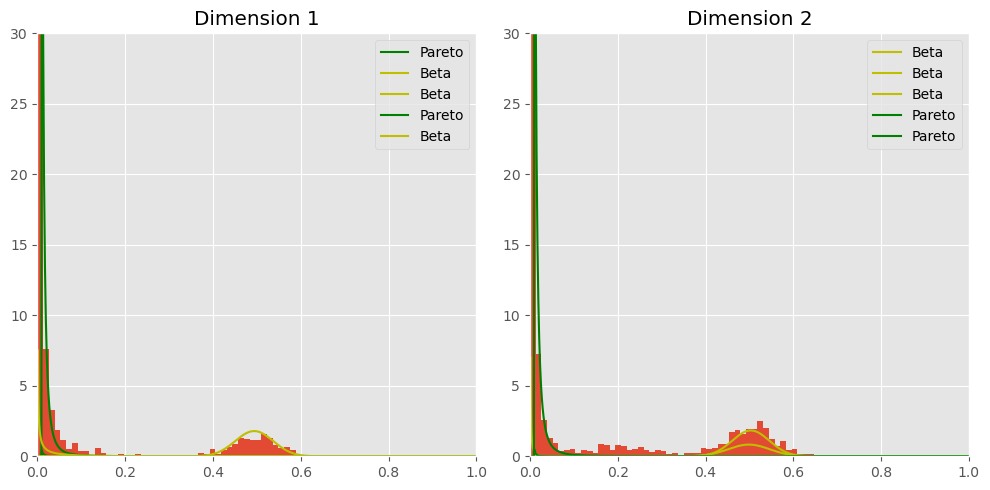

Iteration 2200: Loss = 6887575.5
Iteration 2400: Loss = 6946533.0
phi_beta [[8.7897226e-02 1.6944845e-04]
 [4.9394369e-01 5.0286520e-01]
 [1.6272096e-02 4.9978772e-01]
 [5.0999975e-01 5.0999993e-01]
 [6.9234574e-10 1.9049990e-01]]
delta [[[6.7873061e-01 3.2126936e-01]
  [1.1349859e-04 9.9988651e-01]]

 [[6.3427053e-02 9.3657291e-01]
  [6.5766177e-03 9.9342334e-01]]

 [[4.2260336e-03 9.9577397e-01]
  [6.0077142e-02 9.3992281e-01]]

 [[9.7549313e-01 2.4506809e-02]
  [9.5542556e-01 4.4574421e-02]]

 [[3.4612550e-03 9.9653876e-01]
  [5.9798026e-01 4.0201971e-01]]]


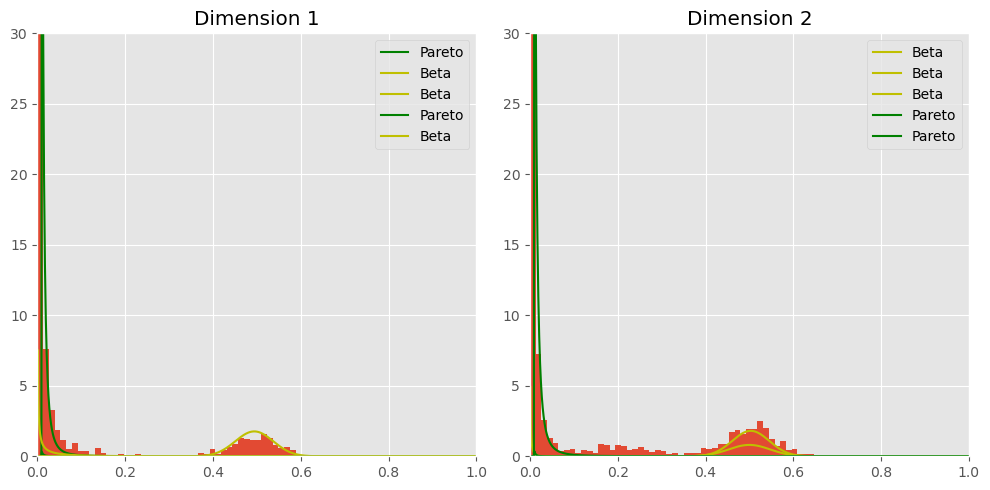

Iteration 2600: Loss = 6871654.0
Iteration 2800: Loss = 6921178.0
phi_beta [[8.3189063e-02 1.2826548e-04]
 [4.9397004e-01 5.0281042e-01]
 [1.6937615e-02 5.0180805e-01]
 [5.0999975e-01 5.0999993e-01]
 [6.9580225e-10 1.9026883e-01]]
delta [[[6.5219736e-01 3.4780261e-01]
  [8.5187865e-05 9.9991477e-01]]

 [[5.1612839e-02 9.4838721e-01]
  [4.7744745e-03 9.9522555e-01]]

 [[3.5656842e-03 9.9643433e-01]
  [5.2794643e-02 9.4720536e-01]]

 [[9.7824335e-01 2.1756591e-02]
  [9.5499539e-01 4.5004651e-02]]

 [[2.4845107e-03 9.9751556e-01]
  [5.8160496e-01 4.1839507e-01]]]


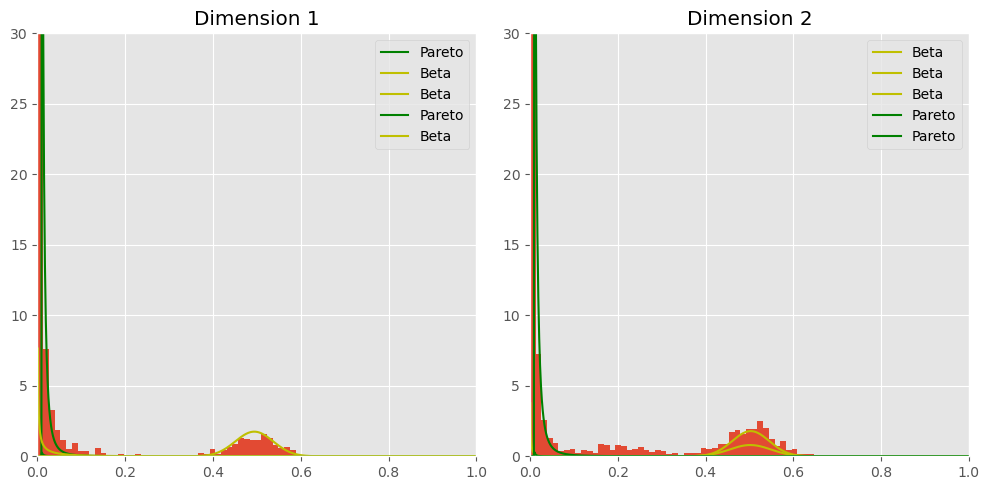

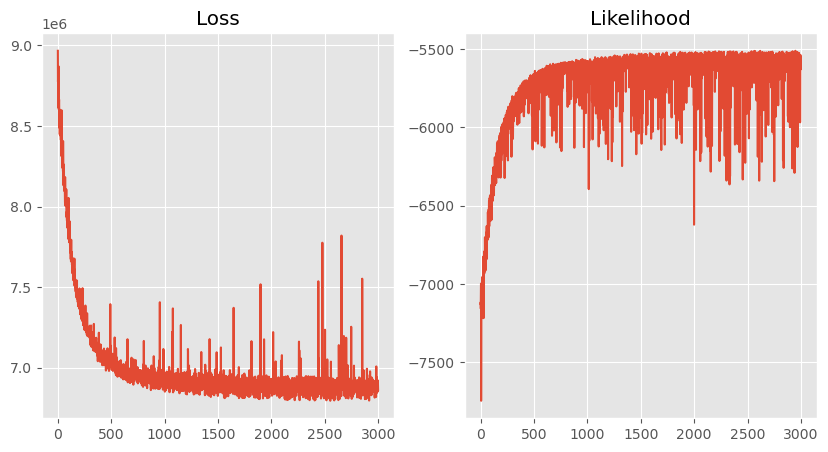

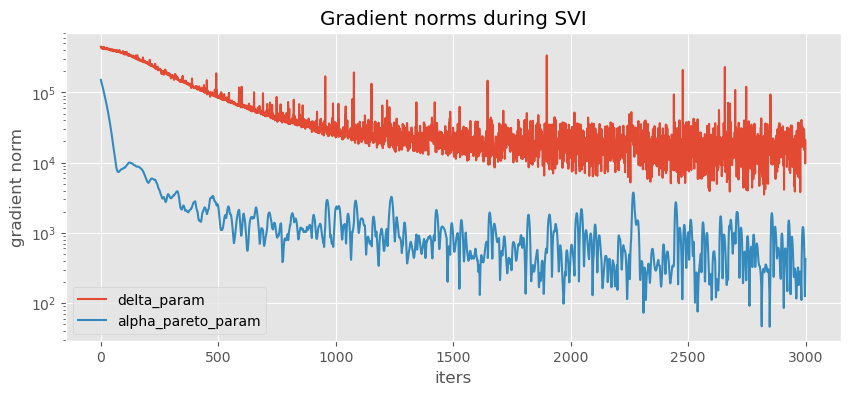

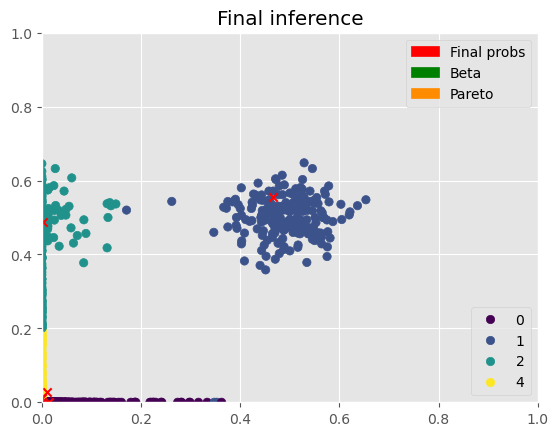

In [76]:
mb = mobster_MV(NV, DP, K = 5, seed = 25)
mb.fit(num_iter = 3000, lr = 0.005)

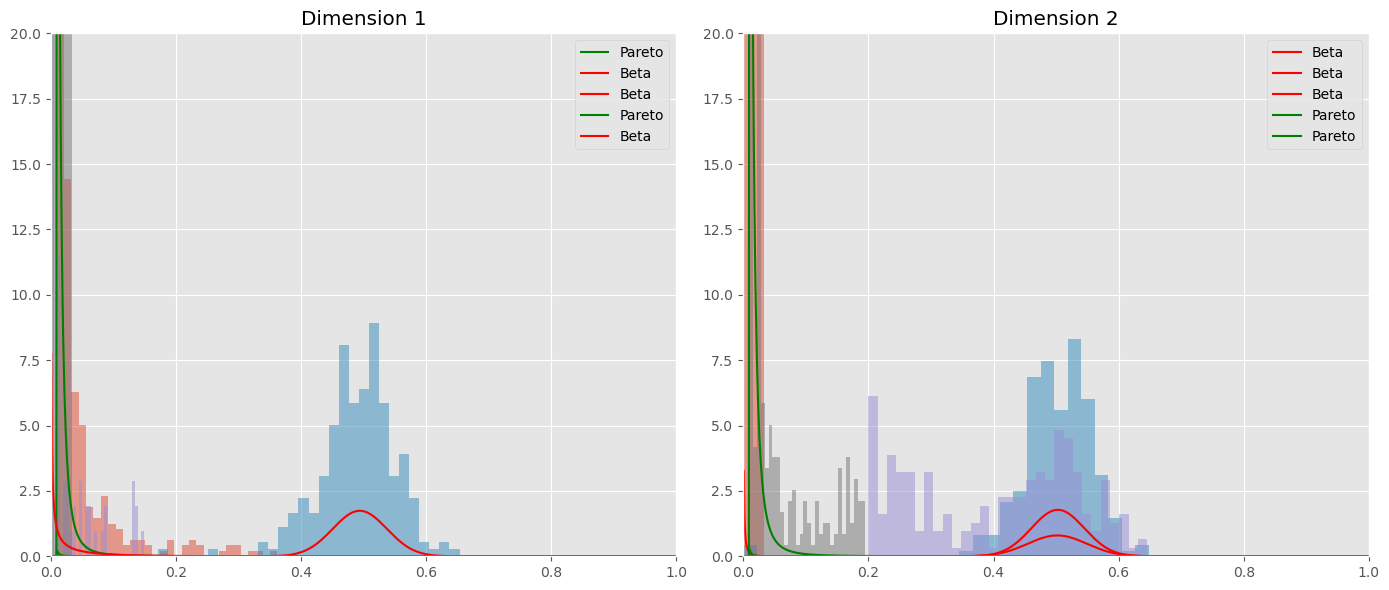

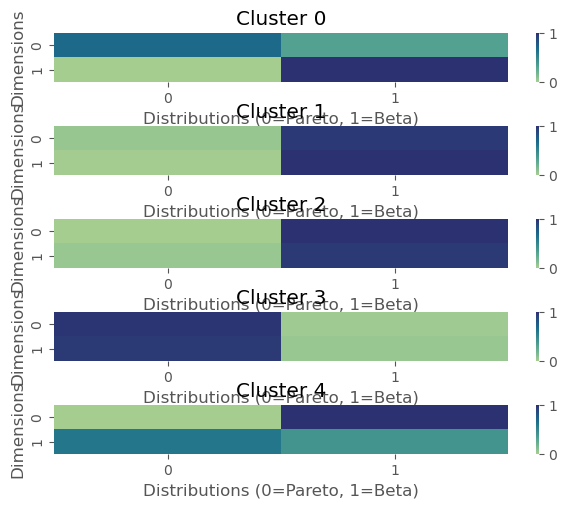

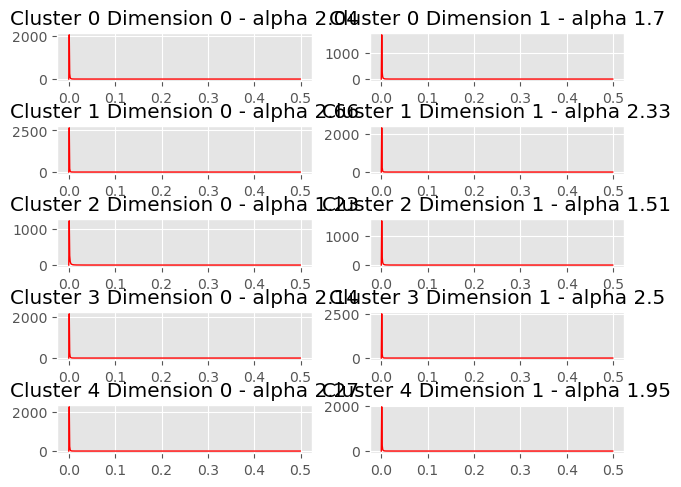

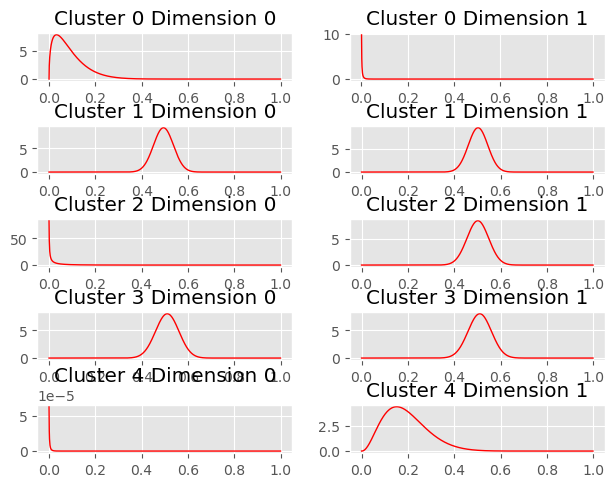

In [77]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [78]:
# Without small gaussian noise
mb.params

{'weights_param': tensor([0.3341, 0.1870, 0.0932, 0.0011, 0.3847], grad_fn=<DivBackward0>),
 'alpha_prior_param': tensor([[3.8644, 2.7280],
         [7.1830, 5.1536],
         [1.7203, 2.2741],
         [4.2585, 6.0862],
         [4.8528, 3.4897]], grad_fn=<AddBackward0>),
 'alpha_pareto_param': tensor([[2.0448, 1.6967],
         [2.6647, 2.3328],
         [1.2346, 1.5146],
         [2.1421, 2.4988],
         [2.2726, 1.9500]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[8.8318e-02, 1.1084e-04],
         [4.9397e-01, 5.0278e-01],
         [1.7020e-02, 5.0188e-01],
         [5.1000e-01, 5.1000e-01],
         [6.9822e-10, 1.9257e-01]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[ 16.6787,  99.2955],
         [136.5016, 142.3131],
         [ 10.1480, 115.5153],
         [ 99.9963, 100.0122],
         [ 99.9886,  16.9998]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[6.7997e-01, 3.2003e-01],
          [7.3357e-05, 9.9993e-01]],
 
         [[4.6887e-02, 9.5311e-01],
 